<h2>프로젝트 추진배경</h2>

- 반도체 제조공정 배경
    - 최근 AI/빅데이터 분야에서 데이터 처리량이 급증하면서, 고대역폭메모리(HBM)에 대한 수요가 증가함.
    - 하지만, HBM은 높은 기술적 난이도로 인해 기존 D램보다 비싼 가격대를 형성함. ~ $180/chip
    - 수율 조건을 만족하면서, 불량칩이 연속적으로 생성되는 경우가 발생.

- 불량 원인
    - 진성불량 : 불량 판정을 받았으며, 실제로도 불량인 경우. ex) 적층된 웨이퍼 간 연결고리인 범프에 이물질이 혼입된 경우 발생.
    - 가성불량 : 불량 판정을 받았지만, 실제로는 정상인 경우. ex) 검사 장비에 이물질 부착으로 인한 측정 오류.

- 검사 장비에 이물질이 부착된 경우, 지속적으로 동일한 지점에서 불량이 발생함. 
- 이에 대해 조치를 취하지 않으면, 매 검사마다 1~2개의 불량칩이 발생하므로 비용적인 손실이 매우 큼.

<h3>따라서, 수율조건을 만족하면서 연속적으로 결함이 발생할 때, 실시간으로 문제 원인을 분석하는 모델을 개발하고자 함.</h3>

---
## Flow Chart

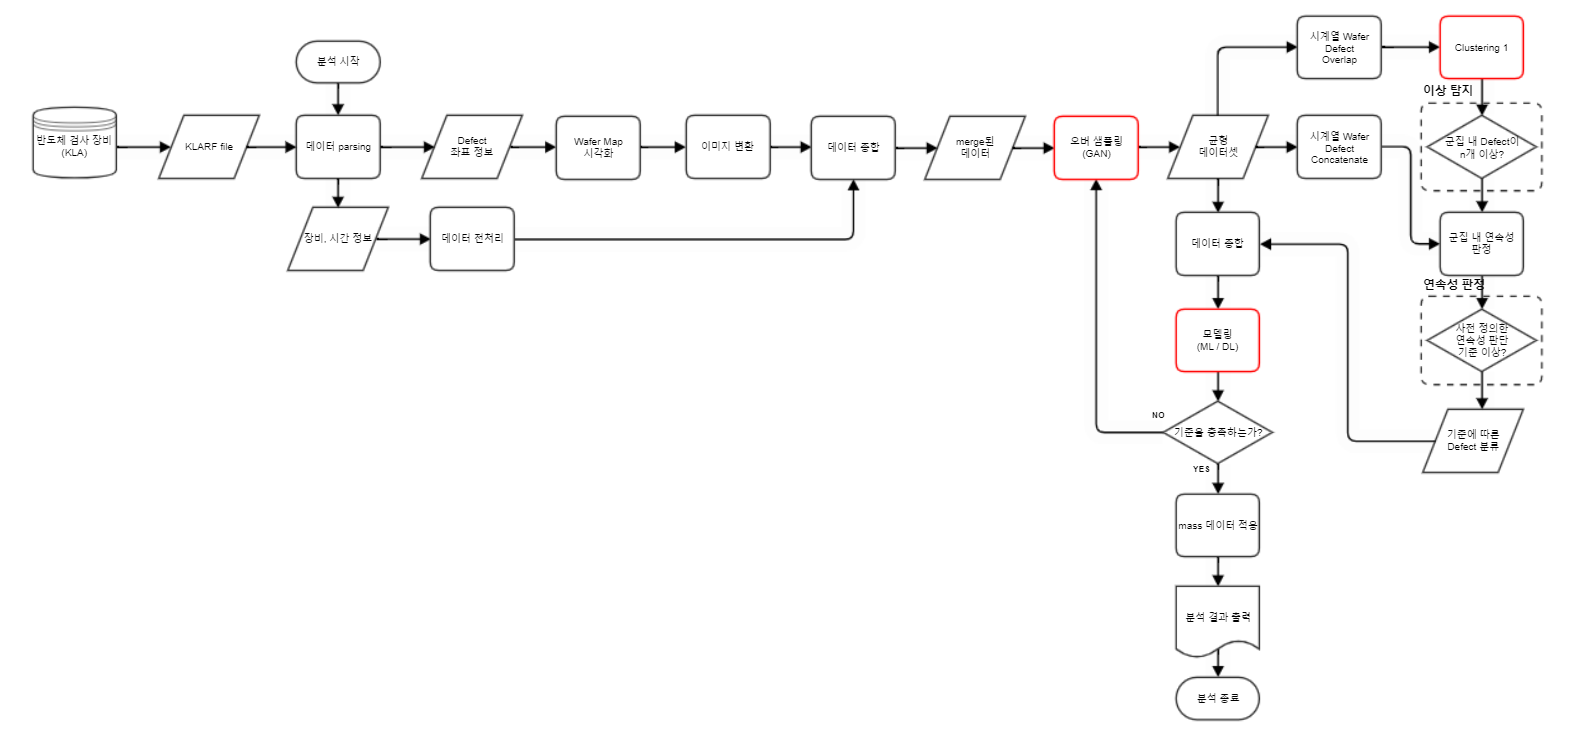

In [228]:
# import 
import pandas as pd
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
import seaborn as sns

import os, glob, joblib
from tqdm import tqdm
from datetime import datetime
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score ,roc_curve, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

---
## KLARF file parsing

In [2]:
file_path = glob.glob("klarfsample/*")

len(file_path)

1000

In [3]:
# 실행할 때마다 한 줄씩 읽어오기
# readlines()로 한번에 시도하면, 용량이 큰 파일의 경우엔 out of memory 가능성.

def readfile(file_path):
    readlines = []
    with open(file_path, 'r') as f:
        i = 1
        while True:
            line = f.readline()
            if not line:
                break
            line = str(i) + ' ' + line
            readlines.append(line.strip('\n').strip(';').split(' '))
            i += 1    
    return readlines

readfile(file_path[0])

[['1', 'FileVersion', '1', '1'],
 ['2', 'FileTimestamp', '01-01-23', '21:16:19'],
 ['3', 'TiffSpec', '6.0', 'G', 'R'],
 ['4',
  'InspectionStationID',
  '"ASAC',
  'TECHNOLOGY',
  'INC"',
  '"A3D02"',
  '"A3D02"'],
 ['5', 'SampleType', 'WAFER'],
 ['6', 'ResultTimestamp', '01-01-23', '21:16:19'],
 ['7', 'LotID', '"AS10330WP"'],
 ['8', 'SampleSize', '1', '300'],
 ['9', 'DeviceID', '"AC1"'],
 ['10', 'SetupID', '"Metrology-Type-01"', '01-01-23', '21:16:19'],
 ['11', 'StepID', '"Metrology-Type-01"'],
 ['12', 'SampleOrientationMarkType', 'NOTCH'],
 ['13', 'OrientationMarkLocation', 'DOWN'],
 ['14', 'TiffFilename', 'AS10330WP_AS10330-14_01-01-23_83.tif'],
 ['15', 'DiePitch', '9.308326e+003', '8.178364e+003'],
 ['16', 'DiePitch', '8.000000e+003', '8.000000e+003'],
 ['17', 'WaferID', '', '"14"'],
 ['18', 'Slot', '14'],
 ['19', 'SampleCenterLocation', '0.000', '0.000'],
 ['20', 'InspectionTest', '1'],
 ['21', 'SampleTestPlan', '536'],
 ['22', '18', '26'],
 ['23', '17', '26'],
 ['24', '16', '26']

### KLARF file의 설비, 제품 및 시간에 대한 데이터 parsing

In [4]:
# KLARF file로부터 데이터 parsing
temp_df = pd.DataFrame()
fname = []
for i, fp in enumerate(file_path):
    dict_klarf = {}
    for line in readfile(fp):
        if not line[1].lstrip('-').isnumeric():
            dict_klarf[line[1]] = ' '.join(line[2:])
    fname.append(os.path.split(fp)[1].split('.')[0])
    temp = pd.DataFrame(dict_klarf, index=[i])
    temp_df = pd.concat([temp_df, temp])

temp_df.columns = temp_df.columns.str.lower()
temp_df['filename'] = fname
cols = ['filename']
cols.extend(temp_df.columns[:-1])

temp_df = temp_df[cols]
temp_df.head(3)

filename fileversion      filetimestamp tiffspec  \
0   AS10330WP_AS10330-14_01-01-23_83         1 1  01-01-23 21:16:19  6.0 G R   
1  AS10103S1_AS10103-14_01-06-23_578         1 1  01-06-23 05:35:07  6.0 G R   
2   AC10022T_AC10022-02_01-07-23_780         1 1  01-07-23 23:14:07  6.0 G R   

                     inspectionstationid sampletype    resulttimestamp  \
0  "ASAC TECHNOLOGY INC" "A3D02" "A3D02"      WAFER  01-01-23 21:16:19   
1  "ASAC TECHNOLOGY INC" "A3D02" "A3D02"      WAFER  01-06-23 05:35:07   
2  "ASAC TECHNOLOGY INC" "A3D01" "A3D01"      WAFER  01-07-23 23:14:07   

         lotid samplesize deviceid  ... slot samplecenterlocation  \
0  "AS10330WP"      1 300    "AC1"  ...   14          0.000 0.000   
1  "AS10103S1"      1 300    "AS1"  ...   14          0.000 0.000   
2   "AC10022T"      1 300    "AC1"  ...   02          0.000 0.000   

  inspectiontest sampletestplan    areapertest  \
0              1            536  4.978698e+010   
1              1            536  4.978698e+010   
2              1            536  4.978698e+010   

                                    defectrecordspec defectlist  \
0  17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...              
1  17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...              
2  17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...              

                                summaryspec summarylist endoffile  
0  5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE                        
1  5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE                        
2  5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE                        

[3 rows x 27 columns]

In [5]:
# unique값이 1인 columns 정리
singleCols = []
for col in temp_df.columns:
    if len(temp_df[col].unique()) == 1:
        singleCols.append(col)
        print('==='*20)
        print(col)
        print(temp_df[col].unique())
    
# 위에서 정리한 columns에 이미 dataframe으로 만든 DefectList, SummaryList columns 추가
singleCols.extend(["defectlist", "summarylist"])

fileversion
['1 1']
tiffspec
['6.0 G R']
sampletype
['WAFER']
samplesize
['1 300']
sampleorientationmarktype
['NOTCH']
orientationmarklocation
['DOWN']
diepitch
['8.000000e+003 8.000000e+003']
samplecenterlocation
['0.000 0.000']
inspectiontest
['1']
sampletestplan
['536']
areapertest
['4.978698e+010']
defectrecordspec
['17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZE DEFECTAREA DSIZE CLASSNUMBER TEST CLUSTERNUMBER ROUGHBINNUMBER FINEBINNUMBER REVIEWSAMPLE IMAGECOUNT IMAGELIST']
defectlist
['']
summaryspec
['5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE']
summarylist
['']
endoffile
['']


In [6]:
selectCols = [
    "filename",
    "filetimestamp",
    "inspectionstationid",
    "resulttimestamp",
    "lotid",
    "deviceid",
    "setupid",
    "stepid",
    "tifffilename",
    "waferid",
    "slot"
    ]
# 특정 columns만 추출
temp_df = temp_df[selectCols]

In [7]:
# column 비교 후 제거 함수
# 보존할 column = col1
# 제거할 column = col2
def eliminate(df, col1, col2):
    '''
    col1: 남길 컬럼
    col2: 제거할 컬럼
    '''
    if df[df[col1] != df[col2]].size == 0:
        df.drop(columns=col2, inplace=True)
        print(f'"{col2}" Column 제거됨.')
    return df

# FileTimestamp column과 ResultTimestamp column이 동일하면 해당 컬럼 삭제
temp_df = eliminate(temp_df, "filetimestamp", "resulttimestamp")
temp_df.head(3)

"resulttimestamp" Column 제거됨.


filename      filetimestamp  \
0   AS10330WP_AS10330-14_01-01-23_83  01-01-23 21:16:19   
1  AS10103S1_AS10103-14_01-06-23_578  01-06-23 05:35:07   
2   AC10022T_AC10022-02_01-07-23_780  01-07-23 23:14:07   

                     inspectionstationid        lotid deviceid  \
0  "ASAC TECHNOLOGY INC" "A3D02" "A3D02"  "AS10330WP"    "AC1"   
1  "ASAC TECHNOLOGY INC" "A3D02" "A3D02"  "AS10103S1"    "AS1"   
2  "ASAC TECHNOLOGY INC" "A3D01" "A3D01"   "AC10022T"    "AC1"   

                                 setupid               stepid  \
0  "Metrology-Type-01" 01-01-23 21:16:19  "Metrology-Type-01"   
1  "Metrology-Type-01" 01-06-23 05:35:07  "Metrology-Type-01"   
2  "Metrology-Type-02" 01-07-23 23:14:07  "Metrology-Type-02"   

                            tifffilename waferid slot  
0   AS10330WP_AS10330-14_01-01-23_83.tif    "14"   14  
1  AS10103S1_AS10103-14_01-06-23_578.tif    "14"   14  
2   AC10022T_AC10022-02_01-07-23_780.tif    "02"   02

In [8]:
# temp_df의 FileTimestamp를 datetime형으로 변환
# 현재 %m-%d-%y %H:%M:%S 형태로 되어있음. 이를 %Y-%m-%d %H:%M:%S

temp_df.filetimestamp = temp_df.filetimestamp.apply(lambda x: datetime.strptime(x, "%m-%d-%y %H:%M:%S"))
temp_df.head(3)

filename       filetimestamp  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07   

                     inspectionstationid        lotid deviceid  \
0  "ASAC TECHNOLOGY INC" "A3D02" "A3D02"  "AS10330WP"    "AC1"   
1  "ASAC TECHNOLOGY INC" "A3D02" "A3D02"  "AS10103S1"    "AS1"   
2  "ASAC TECHNOLOGY INC" "A3D01" "A3D01"   "AC10022T"    "AC1"   

                                 setupid               stepid  \
0  "Metrology-Type-01" 01-01-23 21:16:19  "Metrology-Type-01"   
1  "Metrology-Type-01" 01-06-23 05:35:07  "Metrology-Type-01"   
2  "Metrology-Type-02" 01-07-23 23:14:07  "Metrology-Type-02"   

                            tifffilename waferid slot  
0   AS10330WP_AS10330-14_01-01-23_83.tif    "14"   14  
1  AS10103S1_AS10103-14_01-06-23_578.tif    "14"   14  
2   AC10022T_AC10022-02_01-07-23_780.tif    "02"   02

In [9]:
# InspectionStationID column
print(temp_df.inspectionstationid.unique())

# A3D01, A3D02로 요약할 수 있음.
temp_df.inspectionstationid = temp_df.inspectionstationid.apply(lambda x: x.strip('"').split('" "')[-1])
temp_df.head(3)

['"ASAC TECHNOLOGY INC" "A3D02" "A3D02"'
 '"ASAC TECHNOLOGY INC" "A3D01" "A3D01"']


filename       filetimestamp inspectionstationid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19               A3D02   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07               A3D02   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07               A3D01   

         lotid deviceid                                setupid  \
0  "AS10330WP"    "AC1"  "Metrology-Type-01" 01-01-23 21:16:19   
1  "AS10103S1"    "AS1"  "Metrology-Type-01" 01-06-23 05:35:07   
2   "AC10022T"    "AC1"  "Metrology-Type-02" 01-07-23 23:14:07   

                stepid                           tifffilename waferid slot  
0  "Metrology-Type-01"   AS10330WP_AS10330-14_01-01-23_83.tif    "14"   14  
1  "Metrology-Type-01"  AS10103S1_AS10103-14_01-06-23_578.tif    "14"   14  
2  "Metrology-Type-02"   AC10022T_AC10022-02_01-07-23_780.tif    "02"   02

In [10]:
# # "LotID", "DeviceID", "StepID", "WaferID" columns에 대해 " " 제거
# temp_df[["LotID", "DeviceID", "StepID", "WaferID"]] = \
#     temp_df[["LotID", "DeviceID", "StepID", "WaferID"]].applymap(lambda x: x.strip(' "'))
# temp_df.head(3)
# 모든 columns에 대해 (") 제거
temp_df[["setupid", "lotid", "deviceid", "stepid", "waferid"]] = \
    temp_df[["setupid", "lotid", "deviceid", "stepid", "waferid"]].applymap(lambda x: x.replace('"',''))
temp_df.head(3)

filename       filetimestamp inspectionstationid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19               A3D02   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07               A3D02   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07               A3D01   

       lotid deviceid                              setupid             stepid  \
0  AS10330WP      AC1  Metrology-Type-01 01-01-23 21:16:19  Metrology-Type-01   
1  AS10103S1      AS1  Metrology-Type-01 01-06-23 05:35:07  Metrology-Type-01   
2   AC10022T      AC1  Metrology-Type-02 01-07-23 23:14:07  Metrology-Type-02   

                            tifffilename waferid slot  
0   AS10330WP_AS10330-14_01-01-23_83.tif      14   14  
1  AS10103S1_AS10103-14_01-06-23_578.tif      14   14  
2   AC10022T_AC10022-02_01-07-23_780.tif      02   02

In [11]:
# WaferID column과 Slot column이 동일한지 확인.
# 동일하면 Slot column 제거
# 동일하지 않다면, Fab에 문제가 생긴것..

temp_df = eliminate(temp_df, "waferid", "slot")
temp_df.head(3)

filename       filetimestamp inspectionstationid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19               A3D02   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07               A3D02   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07               A3D01   

       lotid deviceid                              setupid             stepid  \
0  AS10330WP      AC1  Metrology-Type-01 01-01-23 21:16:19  Metrology-Type-01   
1  AS10103S1      AS1  Metrology-Type-01 01-06-23 05:35:07  Metrology-Type-01   
2   AC10022T      AC1  Metrology-Type-02 01-07-23 23:14:07  Metrology-Type-02   

                            tifffilename waferid slot  
0   AS10330WP_AS10330-14_01-01-23_83.tif      14   14  
1  AS10103S1_AS10103-14_01-06-23_578.tif      14   14  
2   AC10022T_AC10022-02_01-07-23_780.tif      02   02

In [12]:
# SetupID column에서 timestamp가 FileTimestamp와 일치하는지 확인.
# 완벽히 일치한다면 해당 timestamp만 제거.
if temp_df[temp_df.setupid.apply(lambda x: datetime.strptime(' '.join(x.split(" ")[1:]).strip(' '), "%m-%d-%y %H:%M:%S"))
        != temp_df.filetimestamp].size == 0:
    temp_df.setupid = temp_df.setupid.apply(lambda x: x.split(" ")[0])
    print('timestamp 제거됨.')
temp_df.head(3)

timestamp 제거됨.


filename       filetimestamp inspectionstationid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19               A3D02   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07               A3D02   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07               A3D01   

       lotid deviceid            setupid             stepid  \
0  AS10330WP      AC1  Metrology-Type-01  Metrology-Type-01   
1  AS10103S1      AS1  Metrology-Type-01  Metrology-Type-01   
2   AC10022T      AC1  Metrology-Type-02  Metrology-Type-02   

                            tifffilename waferid slot  
0   AS10330WP_AS10330-14_01-01-23_83.tif      14   14  
1  AS10103S1_AS10103-14_01-06-23_578.tif      14   14  
2   AC10022T_AC10022-02_01-07-23_780.tif      02   02

In [13]:
# 수정된 SetupID column에서 Metrology-Type이 StepID와 일치하는지 확인.
# 완벽히 일치한다면 해당 column 제거.
temp_df = eliminate(temp_df, 'stepid', 'setupid')
temp_df.head(3)

"setupid" Column 제거됨.


filename       filetimestamp inspectionstationid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19               A3D02   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07               A3D02   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07               A3D01   

       lotid deviceid             stepid  \
0  AS10330WP      AC1  Metrology-Type-01   
1  AS10103S1      AS1  Metrology-Type-01   
2   AC10022T      AC1  Metrology-Type-02   

                            tifffilename waferid slot  
0   AS10330WP_AS10330-14_01-01-23_83.tif      14   14  
1  AS10103S1_AS10103-14_01-06-23_578.tif      14   14  
2   AC10022T_AC10022-02_01-07-23_780.tif      02   02

In [14]:
# StepID column 종류 확인.
temp_df.stepid.unique()

array(['Metrology-Type-01', 'Metrology-Type-02', 'Metrology-type-01',
       'Metrology-type-02'], dtype=object)

In [15]:
# StepID의 column 통일
temp_df.stepid = temp_df.stepid.apply(lambda x: x.upper())
temp_df.head(3)

filename       filetimestamp inspectionstationid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19               A3D02   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07               A3D02   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07               A3D01   

       lotid deviceid             stepid  \
0  AS10330WP      AC1  METROLOGY-TYPE-01   
1  AS10103S1      AS1  METROLOGY-TYPE-01   
2   AC10022T      AC1  METROLOGY-TYPE-02   

                            tifffilename waferid slot  
0   AS10330WP_AS10330-14_01-01-23_83.tif      14   14  
1  AS10103S1_AS10103-14_01-06-23_578.tif      14   14  
2   AC10022T_AC10022-02_01-07-23_780.tif      02   02

In [16]:
# TiffFilename column이 FileName column과 일치하면 제거.
temp_df[["filename", "tifffilename"]] = temp_df[["filename", "tifffilename"]].applymap(lambda x: x.split('.')[0])
temp_df = eliminate(temp_df, "filename", "tifffilename")
temp_df.head(3)

"tifffilename" Column 제거됨.


filename       filetimestamp inspectionstationid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19               A3D02   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07               A3D02   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07               A3D01   

       lotid deviceid             stepid waferid slot  
0  AS10330WP      AC1  METROLOGY-TYPE-01      14   14  
1  AS10103S1      AS1  METROLOGY-TYPE-01      14   14  
2   AC10022T      AC1  METROLOGY-TYPE-02      02   02

In [17]:
# WaferID에 LotID 정보 추가
temp_df.waferid = temp_df.lotid.apply(lambda x: re.split('\d+', x)[0]+re.split('\D+', x)[1]) + '-' + temp_df.waferid
temp_df.head(3)

filename       filetimestamp inspectionstationid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19               A3D02   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07               A3D02   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07               A3D01   

       lotid deviceid             stepid      waferid slot  
0  AS10330WP      AC1  METROLOGY-TYPE-01  AS10330- 14   14  
1  AS10103S1      AS1  METROLOGY-TYPE-01  AS10103- 14   14  
2   AC10022T      AC1  METROLOGY-TYPE-02  AC10022- 02   02

In [18]:
# columns 이름 변경
# FileTimestamp -> Timestamp
# InspectionStationID -> MachineID
temp_df.rename(columns={'filetimestamp': 'timestamp',
                        'inspectionstationid': 'machineid'}, inplace=True)
temp_df.head(3)

filename           timestamp machineid      lotid  \
0   AS10330WP_AS10330-14_01-01-23_83 2023-01-01 21:16:19     A3D02  AS10330WP   
1  AS10103S1_AS10103-14_01-06-23_578 2023-01-06 05:35:07     A3D02  AS10103S1   
2   AC10022T_AC10022-02_01-07-23_780 2023-01-07 23:14:07     A3D01   AC10022T   

  deviceid             stepid      waferid slot  
0      AC1  METROLOGY-TYPE-01  AS10330- 14   14  
1      AS1  METROLOGY-TYPE-01  AS10103- 14   14  
2      AC1  METROLOGY-TYPE-02  AC10022- 02   02

In [19]:
# columns 순서 변경
newcols = ['filename', 'lotid', 'waferid', 'timestamp', 'machineid', 'stepid', 'deviceid']
temp_df = temp_df[newcols]
temp_df.head(3)

filename      lotid      waferid  \
0   AS10330WP_AS10330-14_01-01-23_83  AS10330WP  AS10330- 14   
1  AS10103S1_AS10103-14_01-06-23_578  AS10103S1  AS10103- 14   
2   AC10022T_AC10022-02_01-07-23_780   AC10022T  AC10022- 02   

            timestamp machineid             stepid deviceid  
0 2023-01-01 21:16:19     A3D02  METROLOGY-TYPE-01      AC1  
1 2023-01-06 05:35:07     A3D02  METROLOGY-TYPE-01      AS1  
2 2023-01-07 23:14:07     A3D01  METROLOGY-TYPE-02      AC1

In [20]:
# timestamp 순으로 정렬
temp_df = temp_df.sort_values('timestamp').reset_index(drop=True)
temp_df.head(3)

filename      lotid      waferid  \
0  AC10002SA_AC10002-01_01-01-23_1  AC10002SA  AC10002- 01   
1   AS10001T_AS10001-01_01-01-23_2   AS10001T  AS10001- 01   
2   AS10001T_AS10001-02_01-01-23_3   AS10001T  AS10001- 02   

            timestamp machineid             stepid deviceid  
0 2023-01-01 04:10:00     A3D02  METROLOGY-TYPE-01      AC1  
1 2023-01-01 04:12:49     A3D01  METROLOGY-TYPE-01      AS1  
2 2023-01-01 04:38:19     A3D01  METROLOGY-TYPE-01      AS1

### Wafer Map Visuallization

In [21]:
# Wafer Map Frame을 생성하기 위한 좌표 추출
readlines = readfile(file_path[0])
cnt = 0
for line in readlines:
    if line[1] == 'SampleDieMap':
        firstRow = int(line[0])
        cnt += 1
    elif line[1] == 'SampleTestPlan' and cnt == 1:
        lastRow = int(line[0]) - 3
    elif line[1] == 'SampleTestPlan' and cnt == 0:
        firstRow = int(line[0])
    elif line[1] == 'AreaPerTest' and cnt == 0:
        lastRow = int(line[0]) - 2

wafer_x_coordinate = np.array([int(line[1]) for line in readlines[firstRow:lastRow+1]])
wafer_y_coordinate = np.array([int(line[2]) for line in readlines[firstRow:lastRow+1]])

wafer_x_coordinate += np.array([1-min(wafer_x_coordinate)]*len(wafer_x_coordinate))
wafer_y_coordinate += np.array([1-min(wafer_y_coordinate)]*len(wafer_y_coordinate))

x_min, x_max = min(wafer_x_coordinate), max(wafer_x_coordinate)
y_min, y_max = min(wafer_y_coordinate), max(wafer_y_coordinate)

print(f'x_min: {x_min}, x_max: {x_max}')
print(f'y_min: {y_min}, y_max: {y_max}')

base_wafer = np.zeros([x_max+2, y_max+2])
for x,y in zip(wafer_x_coordinate, wafer_y_coordinate):
    base_wafer[x,y] = 1

x_min: 1, x_max: 24
y_min: 1, y_max: 26


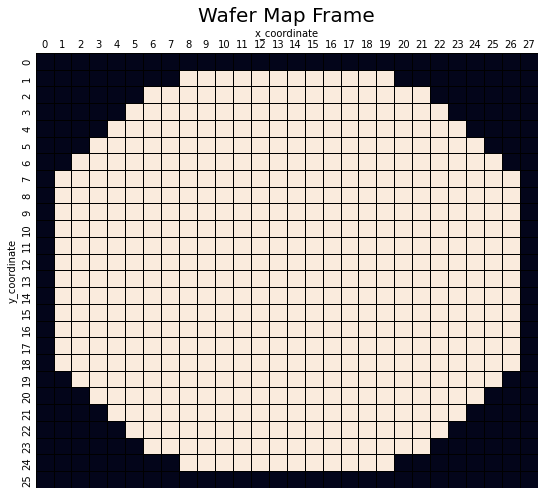

In [22]:
def visualization_wafer(map, size, title):
    plt.figure(figsize=(size+1,size))
    ax = sns.heatmap(map, linewidths=1, linecolor='black', cbar=False)
    plt.xlabel("x_coordinate")
    plt.ylabel("y_coordinate")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.title(title, fontsize=20)
    plt.show()
    
visualization_wafer(base_wafer, 8, "Wafer Map Frame")

In [23]:
# DefectList를 dataframe으로 변환.
defectList = []
for fp in tqdm(file_path):
    readlines = readfile(fp)
    for line in readlines:
        if line[1] == 'DefectList':
            defectRow = int(line[0])
        elif line[1] == 'SummarySpec':
            defectRowEND = int(line[0]) - 1
        else:
            continue
        
    defectCols = ['FILE']
    defectCols.extend(readlines[defectRow-2][3:])
    
    if readlines[defectRow][1].isnumeric():
        for line in readlines[defectRow:defectRowEND]:
            if len(line) == 18:
                temp = [os.path.split(fp)[1]]
                temp.extend(line[1:])
                defectList.append(temp)
    else:
        temp = [os.path.split(fp)[1]]
        temp.extend(np.zeros(17).tolist())
        defectList.append(temp)

defect_df = pd.DataFrame(data=defectList, columns=defectCols)
defect_df[["XINDEX", "YINDEX"]] = defect_df[["XINDEX", "YINDEX"]].astype('int')
defect_df.head()

100%|██████████| 1000/1000 [00:00<00:00, 3795.08it/s]


FILE DEFECTID      XREL       YREL  \
0   AS10330WP_AS10330-14_01-01-23_83.001      0.0       0.0        0.0   
1  AS10103S1_AS10103-14_01-06-23_578.001      0.0       0.0        0.0   
2   AC10022T_AC10022-02_01-07-23_780.001      0.0       0.0        0.0   
3  AS10016TK_AS10016-17_01-07-23_731.001        1   1.5e+01  2.826e+03   
4  AC10010S1_AC10010-07_01-03-23_297.001        1  5.98e+03  5.289e+03   

   XINDEX  YINDEX    XSIZE    YSIZE DEFECTAREA     DSIZE CLASSNUMBER TEST  \
0       0       0      0.0      0.0        0.0       0.0         0.0  0.0   
1       0       0      0.0      0.0        0.0       0.0         0.0  0.0   
2       0       0      0.0      0.0        0.0       0.0         0.0  0.0   
3       2       1  499.077  502.606          0  0.000000         232    1   
4       8       2  506.242  488.036          0  0.000000         232    1   

  CLUSTERNUMBER ROUGHBINNUMBER FINEBINNUMBER REVIEWSAMPLE IMAGECOUNT IMAGELIST  
0           0.0            0.0           0.0          0.0        0.0       0.0  
1           0.0            0.0           0.0          0.0        0.0       0.0  
2           0.0            0.0           0.0          0.0        0.0       0.0  
3             0            100             0            0          2         2  
4             0            100             0            0          2         2

In [24]:
# defect_df의 FILE columns 변경
defect_df.FILE = defect_df.FILE.apply(lambda x: x.split('.')[0])

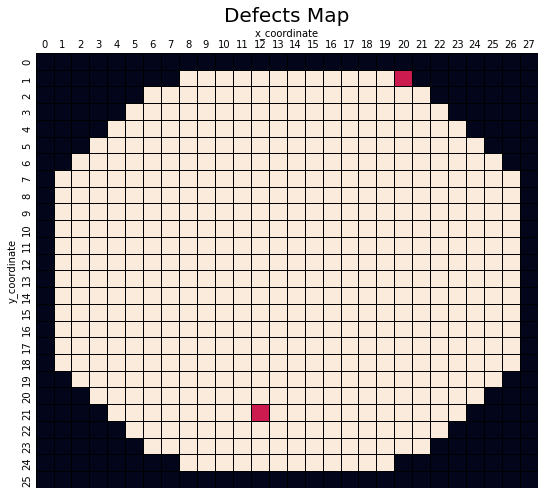

In [25]:
# defect 시각화
defectMaps=[]
for fp in file_path:
    base = base_wafer.copy()
    filename = os.path.split(fp)[1]
    defect_x = defect_df[defect_df.FILE == filename.split('.')[0]][["XINDEX"]].astype('int').values
    defect_y = defect_df[defect_df.FILE == filename.split('.')[0]][["YINDEX"]].astype('int').values
    
    if (defect_x == 0).all():
        pass
    else:
        for i in range(defect_x.size):
            base[defect_x[i][0], defect_y[i][0]] = 0.5
    defectMaps.append(base)
    
# 임의의 defect map 시각화
visualization_wafer(defectMaps[55],8, "Defects Map")

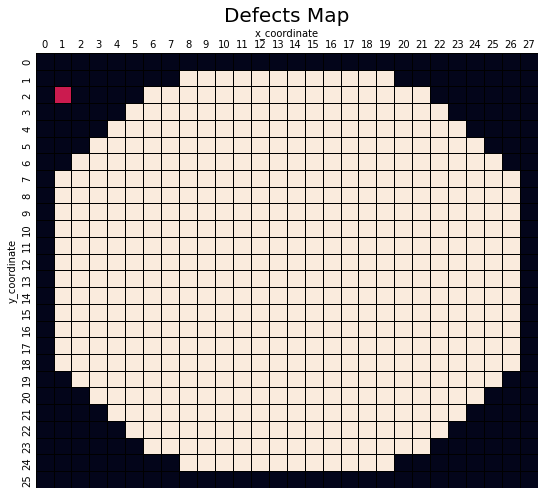

In [26]:
# defect가 wafer 영역 밖에서 표현되는 경우가 존재.
visualization_wafer(defectMaps[3],8, "Defects Map")

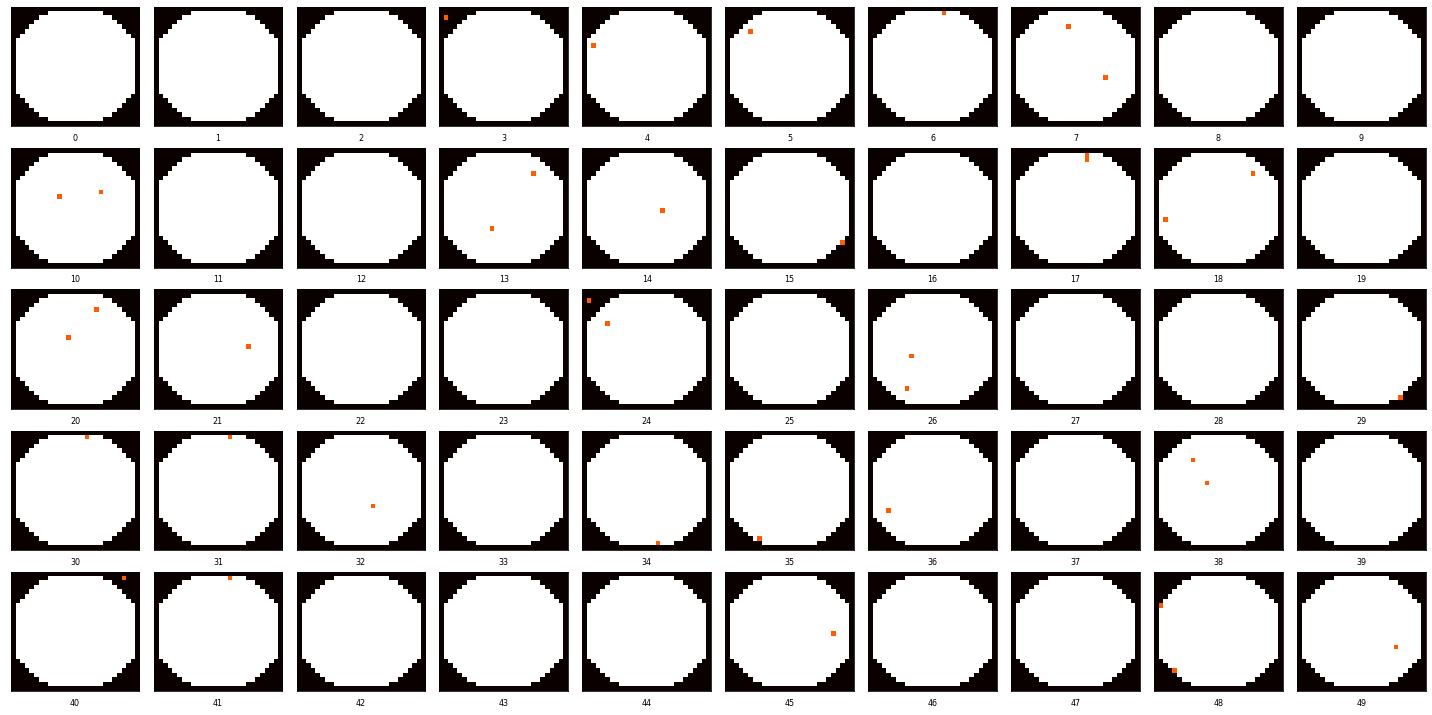

In [27]:
# 다중 wafer 시각화 (단순 추이를 보기 위함.)
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(20,10))
ax = ax.ravel(order='C')
for i in range(50):
    ax[i].imshow(defectMaps[i], cmap=cm.hot)
    ax[i].set_xlabel(f'{i}', fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## 분석용 데이터 생성

In [28]:
temp_df.head()

filename      lotid      waferid  \
0  AC10002SA_AC10002-01_01-01-23_1  AC10002SA  AC10002- 01   
1   AS10001T_AS10001-01_01-01-23_2   AS10001T  AS10001- 01   
2   AS10001T_AS10001-02_01-01-23_3   AS10001T  AS10001- 02   
3  AC10002SA_AC10002-03_01-01-23_4  AC10002SA  AC10002- 03   
4   AS10001T_AS10001-03_01-01-23_5   AS10001T  AS10001- 03   

            timestamp machineid             stepid deviceid  
0 2023-01-01 04:10:00     A3D02  METROLOGY-TYPE-01      AC1  
1 2023-01-01 04:12:49     A3D01  METROLOGY-TYPE-01      AS1  
2 2023-01-01 04:38:19     A3D01  METROLOGY-TYPE-01      AS1  
3 2023-01-01 04:41:51     A3D02  METROLOGY-TYPE-01      AC1  
4 2023-01-01 04:55:52     A3D01  METROLOGY-TYPE-01      AS1

In [29]:
defect_df["map"] = defect_df[["XINDEX", "YINDEX"]].apply(list, axis=1)
defect_df.head(3)

FILE DEFECTID XREL YREL  XINDEX  YINDEX XSIZE  \
0   AS10330WP_AS10330-14_01-01-23_83      0.0  0.0  0.0       0       0   0.0   
1  AS10103S1_AS10103-14_01-06-23_578      0.0  0.0  0.0       0       0   0.0   
2   AC10022T_AC10022-02_01-07-23_780      0.0  0.0  0.0       0       0   0.0   

  YSIZE DEFECTAREA DSIZE CLASSNUMBER TEST CLUSTERNUMBER ROUGHBINNUMBER  \
0   0.0        0.0   0.0         0.0  0.0           0.0            0.0   
1   0.0        0.0   0.0         0.0  0.0           0.0            0.0   
2   0.0        0.0   0.0         0.0  0.0           0.0            0.0   

  FINEBINNUMBER REVIEWSAMPLE IMAGECOUNT IMAGELIST     map  
0           0.0          0.0        0.0       0.0  [0, 0]  
1           0.0          0.0        0.0       0.0  [0, 0]  
2           0.0          0.0        0.0       0.0  [0, 0]

In [30]:
def appendFn(*listset):
    lst = []
    for list_ in listset:
        lst.append(list_)
    return lst

defect_temp = defect_df.groupby(['FILE'])["map"].apply(appendFn).reset_index()
defect_temp.map = defect_temp.map.apply(lambda x: np.array(x).squeeze(0))
defect_temp

FILE         map
0    AC10001TA_AC10001-01_01-01-23_41  [[24, 20]]
1    AC10001TA_AC10001-02_01-01-23_43  [[15, 17]]
2    AC10001TA_AC10001-03_01-01-23_45    [[0, 0]]
3    AC10001TA_AC10001-04_01-01-23_47    [[0, 0]]
4    AC10001TA_AC10001-05_01-01-23_49  [[16, 21]]
..                                ...         ...
995  AS20300S_AS20300-21_01-07-23_690    [[0, 0]]
996  AS20300S_AS20300-22_01-07-23_692    [[0, 0]]
997  AS20300S_AS20300-23_01-07-23_693    [[8, 5]]
998  AS20300S_AS20300-24_01-07-23_695    [[0, 0]]
999  AS20300S_AS20300-25_01-07-23_697   [[23, 3]]

[1000 rows x 2 columns]

In [31]:
df = pd.merge(temp_df, defect_temp, how='inner', left_on='filename', right_on='FILE').drop(columns=["FILE", "filename"])
df.head()

lotid      waferid           timestamp machineid             stepid  \
0  AC10002SA  AC10002- 01 2023-01-01 04:10:00     A3D02  METROLOGY-TYPE-01   
1   AS10001T  AS10001- 01 2023-01-01 04:12:49     A3D01  METROLOGY-TYPE-01   
2   AS10001T  AS10001- 02 2023-01-01 04:38:19     A3D01  METROLOGY-TYPE-01   
3  AC10002SA  AC10002- 03 2023-01-01 04:41:51     A3D02  METROLOGY-TYPE-01   
4   AS10001T  AS10001- 03 2023-01-01 04:55:52     A3D01  METROLOGY-TYPE-01   

  deviceid         map  
0      AC1    [[0, 0]]  
1      AS1  [[16, 15]]  
2      AS1    [[0, 0]]  
3      AC1    [[0, 0]]  
4      AS1    [[0, 0]]

## 연속성 판정을 위한 Feature Engineering

1. Defects의 좌표를 거리와 각도로 표현.
2. 시계열순으로 Shift하여 데이터 batch 생성
3. 생성된 batch에 대해 Fast Fourier Transform

In [32]:
# hyperparameter
class cfg:
    seed = 1234
    n_window = 3 # 한 batch에 확인할 wafer 수 -> 10
    origin = [(base_wafer.shape[0]-1)/2, (base_wafer.shape[1]-1)/2]
    #origin = [12.5, 13.5] # wafer의 원점 정의

In [33]:
# batch dataset visualization v2
def dist(origin, defects):
    if defects[0] == [0,0]:
        return [-1]
    distance = [-1]
    for i in range(len(defects)):
        dist = 0
        for j in range(len(defects[i])):
            dist += (origin[j]-defects[i][j])**2
        dist **= 1/2
        distance.append(int(dist))
    return distance

def theta(origin, defects):
    if defects[0] == [0,0]:
        return [-180]
    theta = [-180]
    for i in range(len(defects)):
        rc_x = defects[i][0] - origin[0]
        rc_y = defects[i][1] - origin[1]
        ang = int(np.rad2deg(np.arctan2(rc_y, rc_x)))
        theta.append(ang) # 가시성을 위해 rad -> deg
    return theta

df["distance"] = df.map.apply(lambda x:dist(cfg.origin, x))
df["degree"] = df.map.apply(lambda x:theta(cfg.origin, x))

df.head(30)

lotid      waferid           timestamp machineid             stepid  \
0   AC10002SA  AC10002- 01 2023-01-01 04:10:00     A3D02  METROLOGY-TYPE-01   
1    AS10001T  AS10001- 01 2023-01-01 04:12:49     A3D01  METROLOGY-TYPE-01   
2    AS10001T  AS10001- 02 2023-01-01 04:38:19     A3D01  METROLOGY-TYPE-01   
3   AC10002SA  AC10002- 03 2023-01-01 04:41:51     A3D02  METROLOGY-TYPE-01   
4    AS10001T  AS10001- 03 2023-01-01 04:55:52     A3D01  METROLOGY-TYPE-01   
5   AC10002SA  AC10002- 05 2023-01-01 05:03:39     A3D02  METROLOGY-TYPE-01   
6    AS10001T  AS10001- 04 2023-01-01 05:20:04     A3D01  METROLOGY-TYPE-01   
7   AC10002SA  AC10002- 07 2023-01-01 05:30:19     A3D02  METROLOGY-TYPE-01   
8    AS10001T  AS10001- 05 2023-01-01 05:40:36     A3D01  METROLOGY-TYPE-01   
9   AC10002SA  AC10002- 09 2023-01-01 05:55:43     A3D02  METROLOGY-TYPE-01   
10   AS10001T  AS10001- 06 2023-01-01 06:04:41     A3D01  METROLOGY-TYPE-01   
11  AC10002SA  AC10002- 11 2023-01-01 06:14:57     A3D02  METROLOGY-TYPE-01   
12   AS10001T  AS10001- 07 2023-01-01 06:36:04     A3D01  METROLOGY-TYPE-01   
13  AC10002SA  AC10002- 13 2023-01-01 06:38:14     A3D02  METROLOGY-TYPE-01   
14  AC10002SA  AC10002- 15 2023-01-01 07:04:25     A3D02  METROLOGY-TYPE-01   
15   AS10001T  AS10001- 08 2023-01-01 07:08:57     A3D01  METROLOGY-TYPE-01   
16   AS10001T  AS10001- 09 2023-01-01 07:27:58     A3D01  METROLOGY-TYPE-01   
17  AC10002SA  AC10002- 17 2023-01-01 07:33:54     A3D02  METROLOGY-TYPE-01   
18   AS10001T  AS10001- 10 2023-01-01 08:01:10     A3D01  METROLOGY-TYPE-01   
19  AC10002SA  AC10002- 19 2023-01-01 08:07:08     A3D02  METROLOGY-TYPE-01   
20  AC10002SA  AC10002- 21 2023-01-01 08:25:36     A3D02  METROLOGY-TYPE-01   
21   AS10001T  AS10001- 11 2023-01-01 08:31:27     A3D01  METROLOGY-TYPE-01   
22  AC10002SA  AC10002- 23 2023-01-01 08:48:01     A3D02  METROLOGY-TYPE-01   
23   AS10001T  AS10001- 12 2023-01-01 09:00:27     A3D01  METROLOGY-TYPE-01   
24  AS10003SA  AS10003- 01 2023-01-01 09:12:28     A3D02  METROLOGY-TYPE-01   
25   AS10001T  AS10001- 13 2023-01-01 09:23:10     A3D01  METROLOGY-TYPE-01   
26  AS10003SA  AS10003- 02 2023-01-01 09:38:53     A3D02  METROLOGY-TYPE-01   
27   AS10001T  AS10001- 14 2023-01-01 09:55:09     A3D01  METROLOGY-TYPE-01   
28  AS10003SA  AS10003- 03 2023-01-01 10:10:34     A3D02  METROLOGY-TYPE-01   
29   AS10001T  AS10001- 15 2023-01-01 10:27:40     A3D01  METROLOGY-TYPE-01   

   deviceid                   map     distance             degree  
0       AC1              [[0, 0]]         [-1]             [-180]  
1       AS1            [[16, 15]]      [-1, 3]         [-180, 23]  
2       AS1              [[0, 0]]         [-1]             [-180]  
3       AC1              [[0, 0]]         [-1]             [-180]  
4       AS1              [[0, 0]]         [-1]             [-180]  
5       AC1   [[17, 7], [22, 21]]  [-1, 7, 12]    [-180, -55, 38]  
6       AS1              [[0, 0]]         [-1]             [-180]  
7       AC1              [[0, 0]]         [-1]             [-180]  
8       AS1              [[0, 0]]         [-1]             [-180]  
9       AC1   [[4, 18], [10, 12]]   [-1, 9, 2]  [-180, 152, -149]  
10      AS1              [[0, 0]]         [-1]             [-180]  
11      AC1              [[0, 0]]         [-1]             [-180]  
12      AS1             [[3, 19]]     [-1, 10]        [-180, 149]  
13      AC1              [[0, 0]]         [-1]             [-180]  
14      AC1   [[12, 14], [7, 18]]   [-1, 0, 7]   [-180, 135, 140]  
15      AS1  [[14, 23], [19, 15]]   [-1, 9, 6]     [-180, 81, 12]  
16      AS1     [[4, 9], [8, 20]]   [-1, 9, 7]  [-180, -152, 124]  
17      AC1              [[0, 0]]         [-1]             [-180]  
18      AS1              [[0, 0]]         [-1]             [-180]  
19      AC1              [[0, 0]]         [-1]             [-180]  
20      AC1   [[13, 15], [10, 5]]   [-1, 1, 8]   [-180, 71, -106]  
21      AS1              [[0, 0]]         [-1]             [-1

In [34]:
def batch_graph(degree, distance, graph=True):
    intp = interpolate.interp1d(degree, distance, kind='linear') # linear, cubic, nearest ...
    xnew = np.arange(min(degree), max(degree), 0.1)
    
    if graph:
        fig = plt.figure(figsize=(5,2))
        plt.plot(degree, distance, "ro", xnew, intp(xnew))
        plt.xlim([-180, -180+360*cfg.n_window])
        plt.ylim([0, 20])
        xtick = np.array(degree) % 360
        plt.xticks(degree, xtick, rotation=45)
        plt.show()
    return intp, xnew

# FFT graph
def fft_graph(input, graph=True):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    freq = np.fft.fftfreq(len(Y), 1/1000)

    amp = amp[0:20]
    freq = freq[0:20]
    
    if graph:
        plt.figure(figsize=(5,2))
        plt.stem(freq, amp)
        plt.grid(True)
        plt.show()
    return amp

In [35]:
# 전체 데이터에 대해 진행.
def amp_data(input):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    return amp[0:20]

In [36]:
# fft그래프 visualization
def visualization_graph(df, case, graph=True):
    df["Case"] = case
    nRows = len(df) - cfg.n_window + 1
    for i in range(nRows):
        df_dist = df.distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
        df_deg = df.degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        batch_dist.append(-1)    
        batch_deg.append(-180 + 360*(n+1))    
            
        print(f"Index_{df.at[i+cfg.n_window-1, 'index']}")
        intp, xnew = batch_graph(batch_deg, batch_dist, graph)
        fft_graph(intp(xnew), graph)
    return 

Case9: ('A3D01', 'Metrology-Type-01', 'AC1')
Index_44


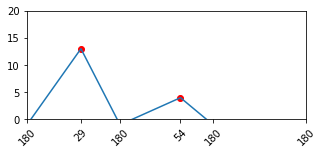

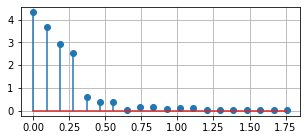

Index_46


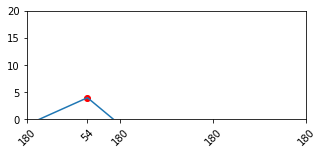

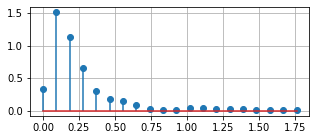

Index_48


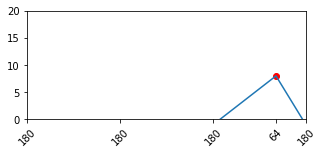

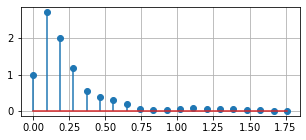

Index_49


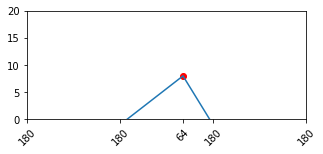

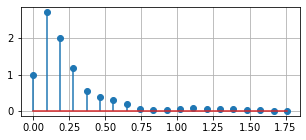

Index_51


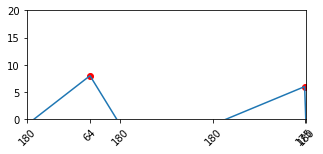

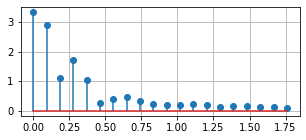

Index_53


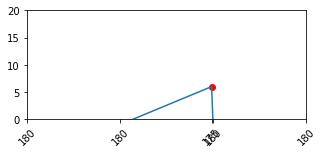

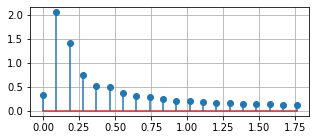

Index_55


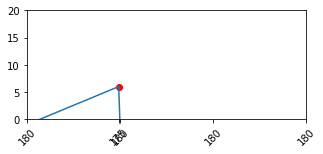

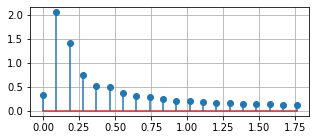

Index_56


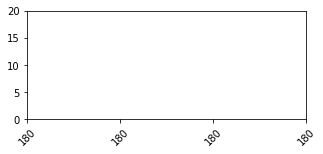

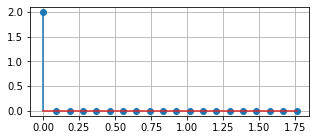

Index_58


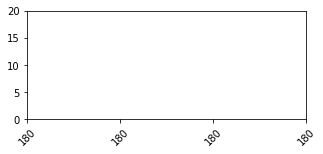

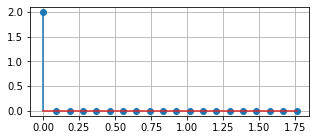

Index_61


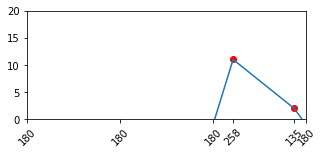

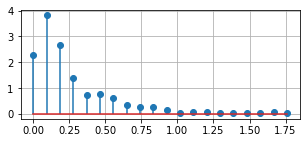

Index_62


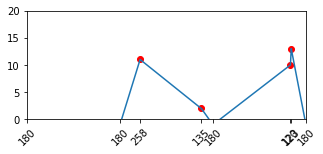

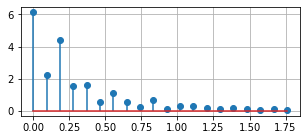

Index_64


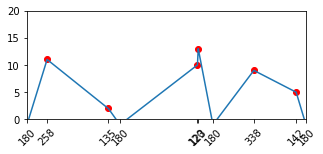

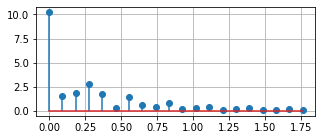

Index_66


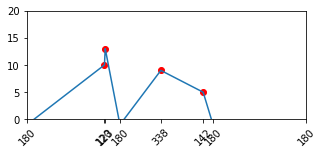

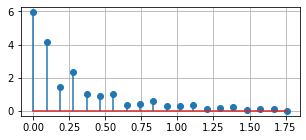

Index_69


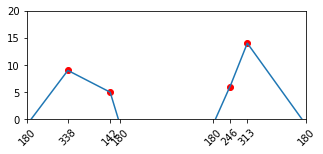

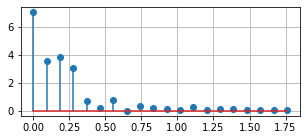

Index_71


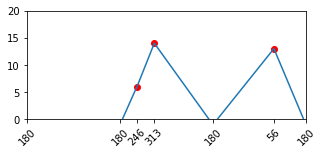

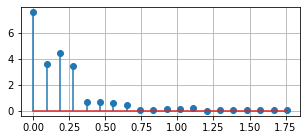

Index_73


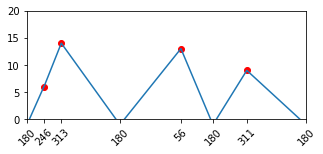

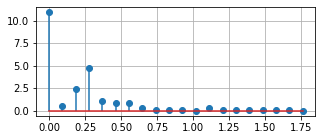

Index_75


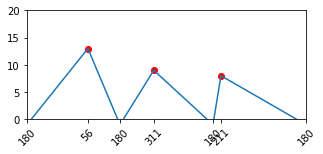

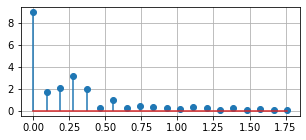

Index_77


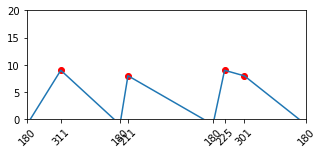

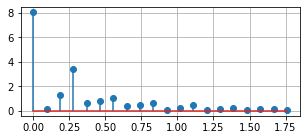

Index_79


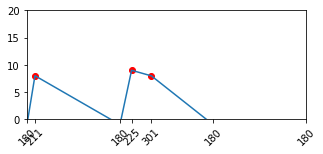

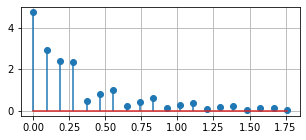

Index_81


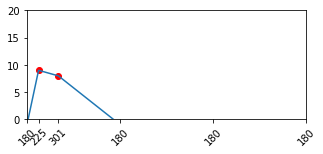

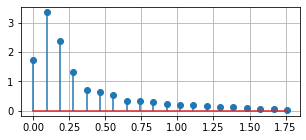

Index_83


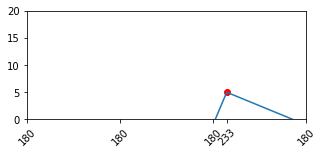

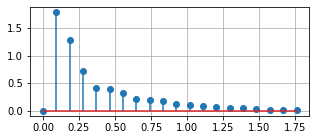

Index_85


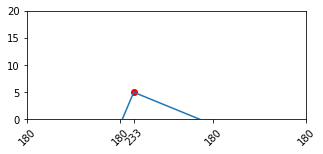

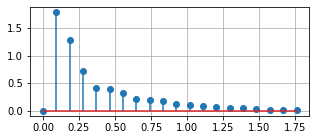

Index_86


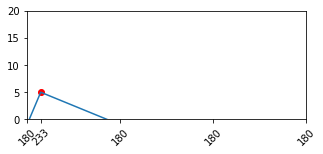

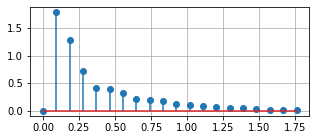

Index_284


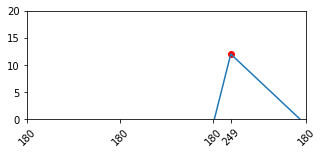

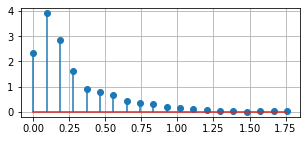

Index_286


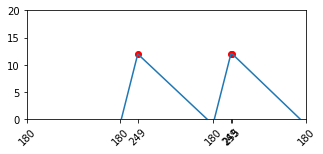

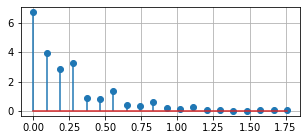

Index_288


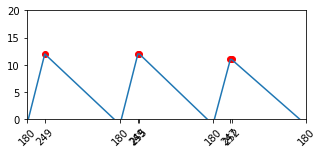

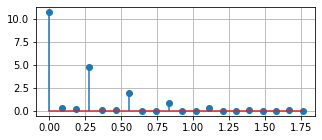

Index_290


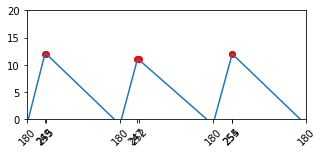

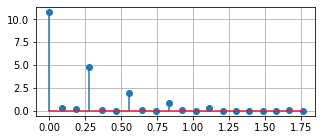

Index_292


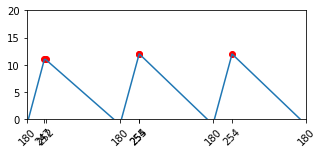

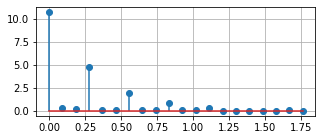

Index_294


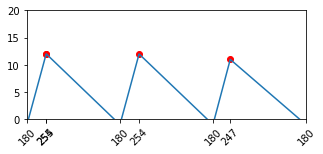

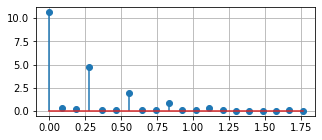

Index_296


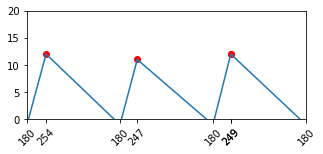

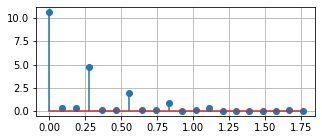

Index_365


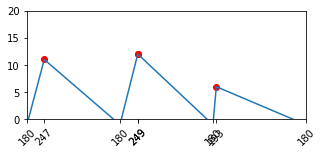

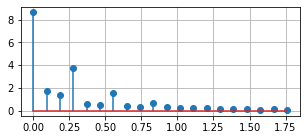

Index_367


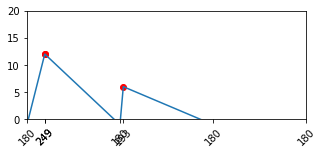

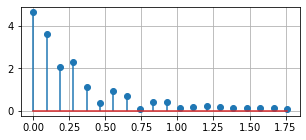

Index_369


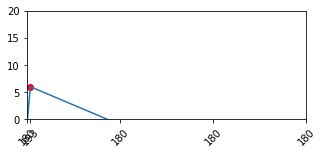

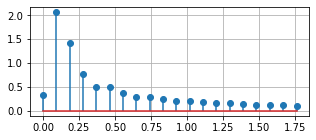

Index_371


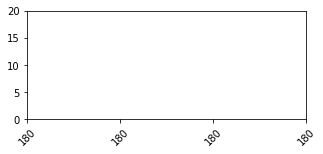

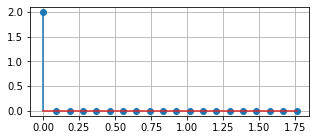

Index_373


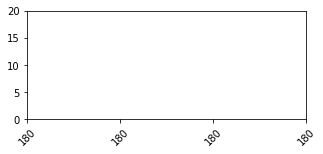

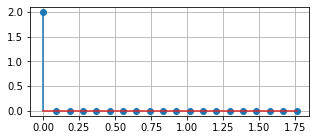

Index_376


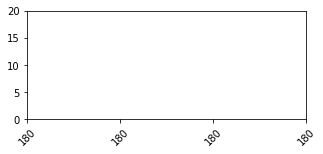

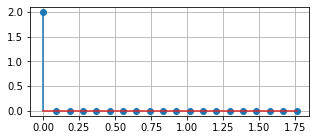

Index_378


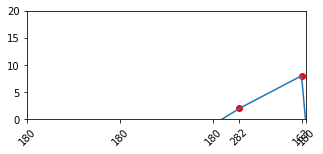

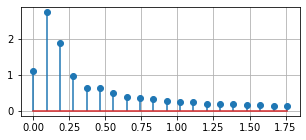

Index_380


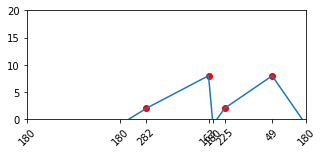

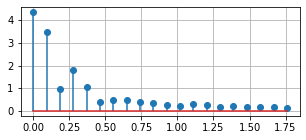

Index_383


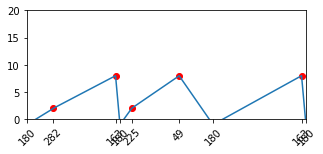

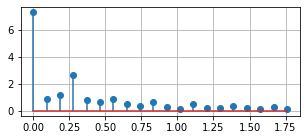

Index_385


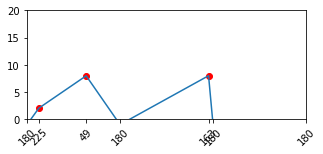

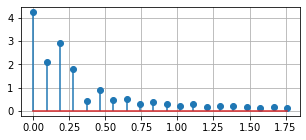

Index_386


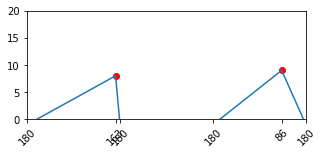

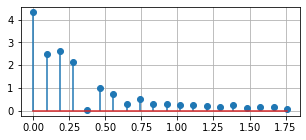

Index_388


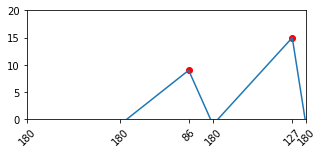

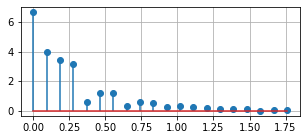

Index_390


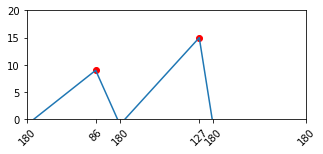

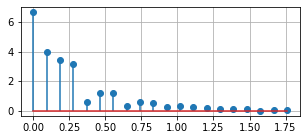

Index_392


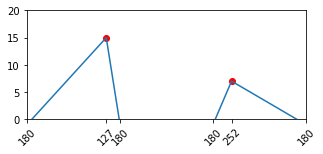

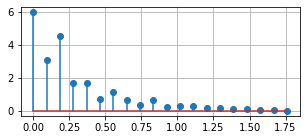

Index_394


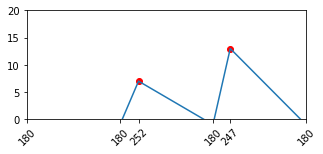

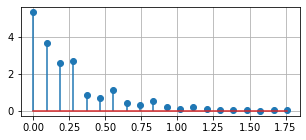

Index_396


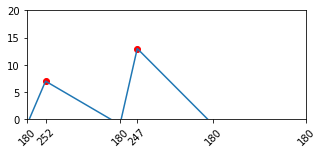

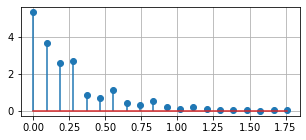

Index_398


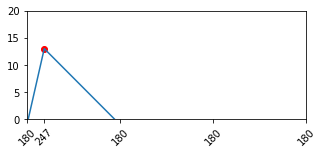

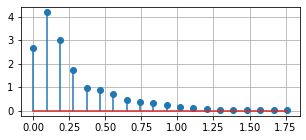

Index_399


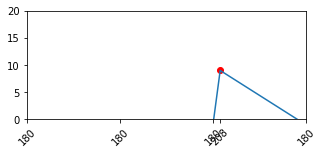

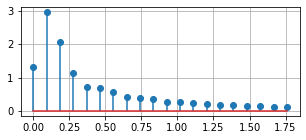

Index_601


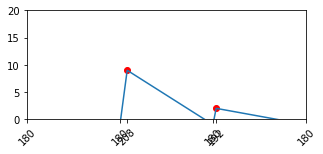

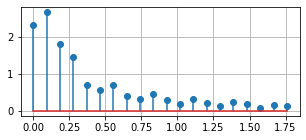

Index_603


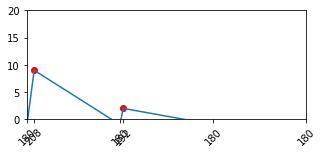

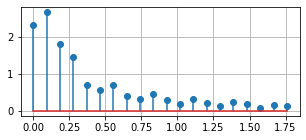

Index_605


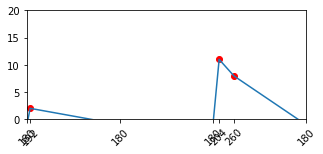

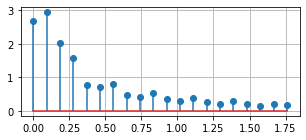

Index_607


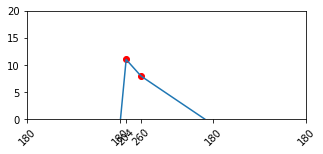

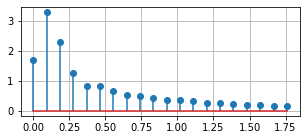

Index_609


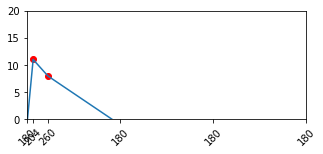

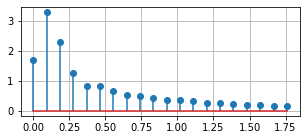

Index_611


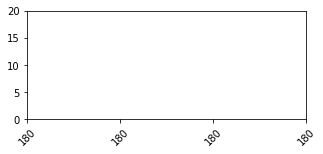

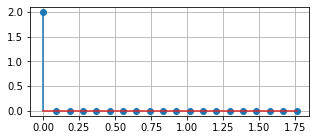

Index_613


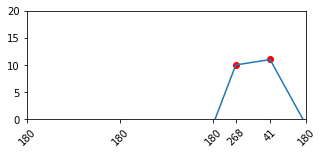

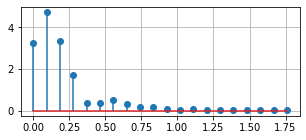

Index_615


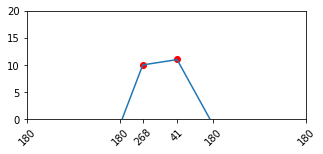

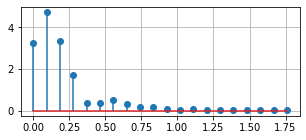

Index_618


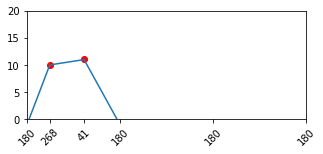

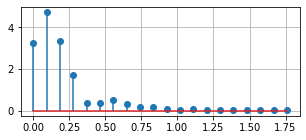

Index_620


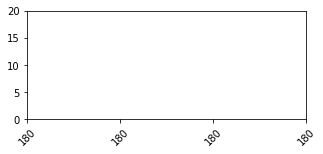

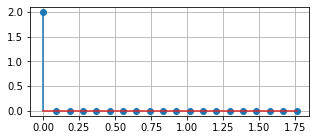

Index_622


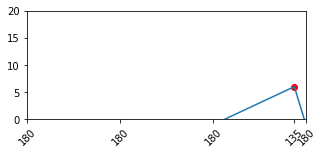

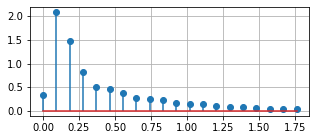

Index_624


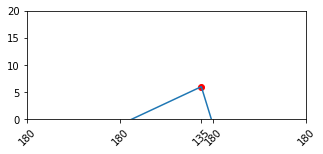

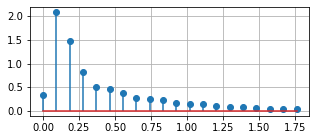

Index_625


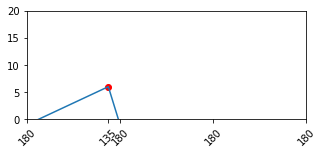

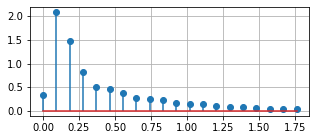

Index_627


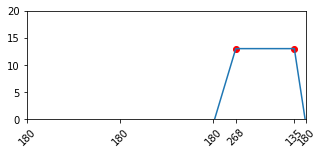

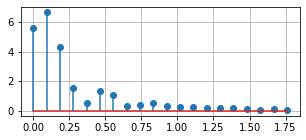

Index_629


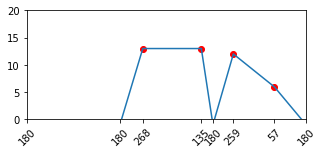

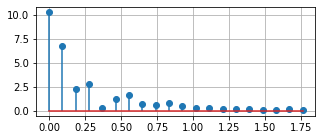

Index_631


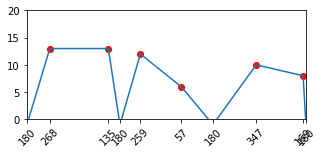

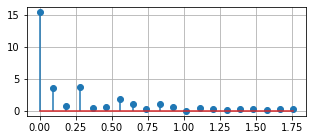

Index_632


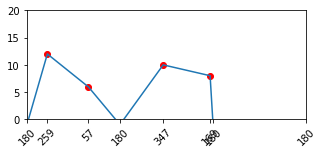

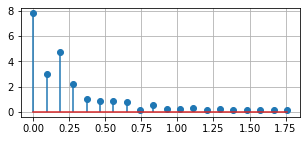

Index_634


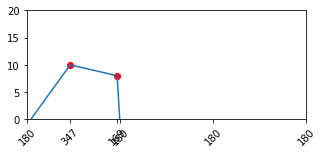

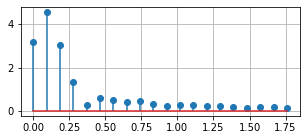

Index_636


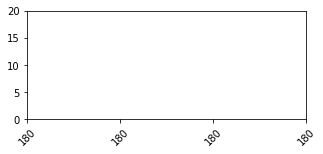

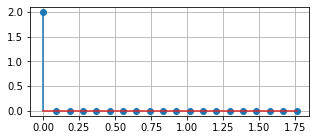

Index_638


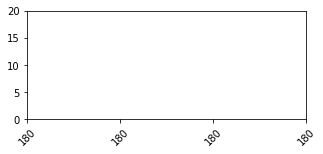

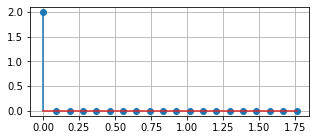

Index_640


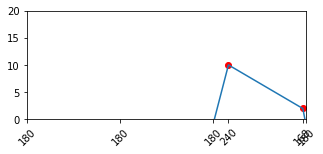

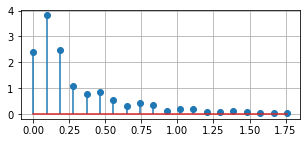

Index_642


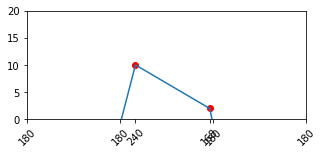

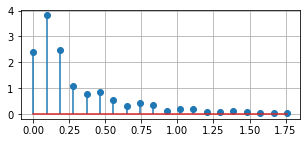

Index_643


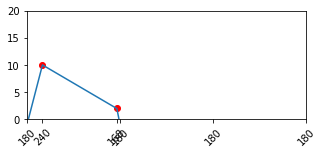

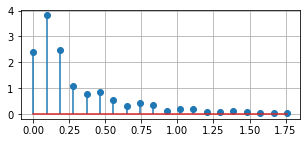

Index_646


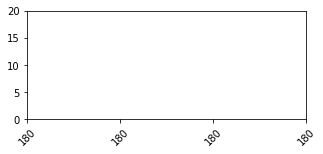

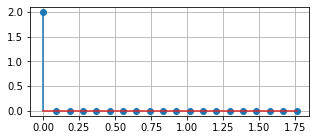

Index_647


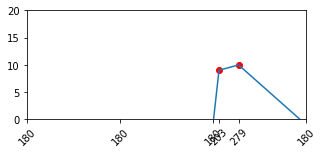

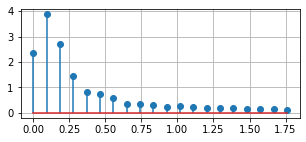

Index_958


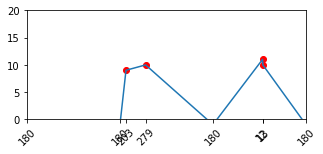

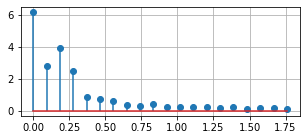

Index_959


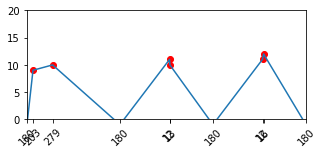

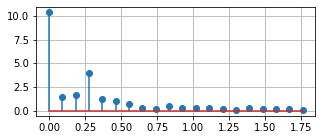

Index_962


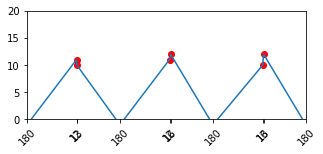

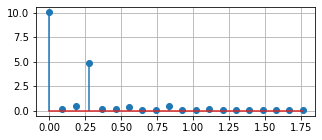

Index_964


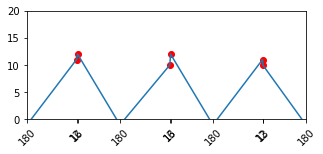

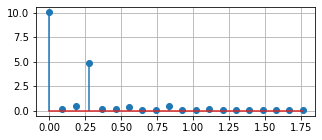

Index_965


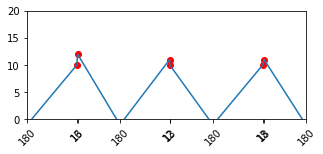

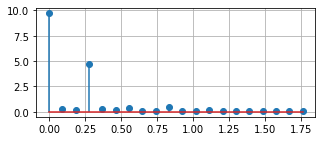

Index_967


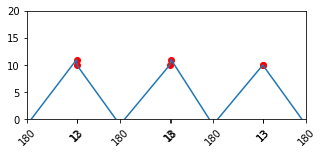

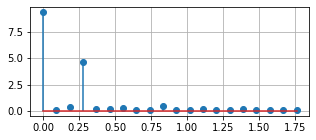

Index_969


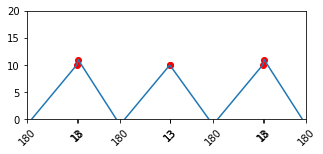

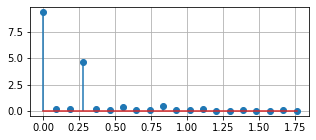

Index_970


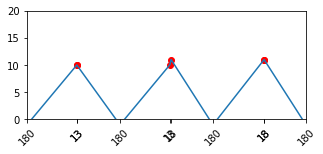

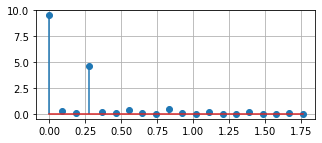

Index_972


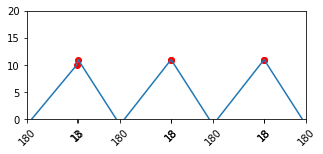

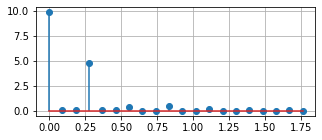

Index_974


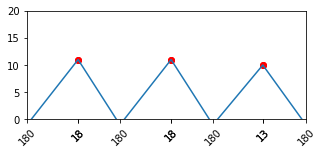

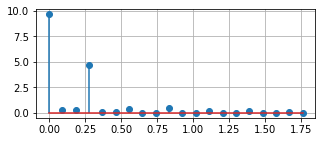

Index_976


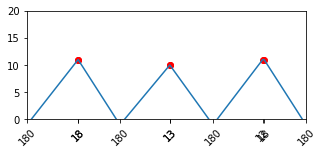

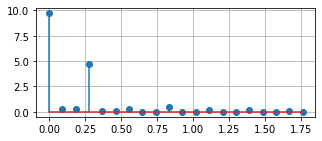

Index_978


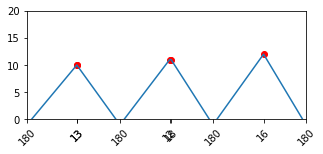

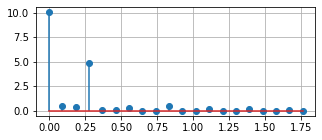

Index_980


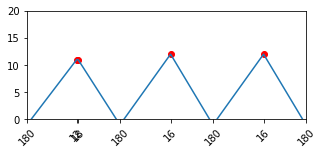

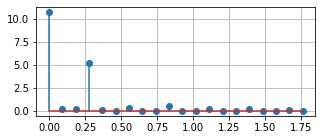

Index_982


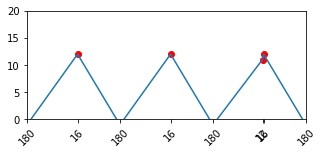

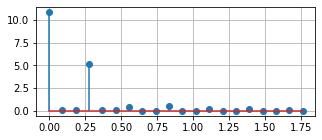

Index_985


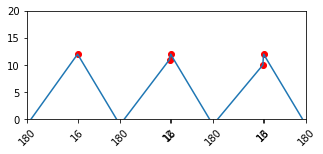

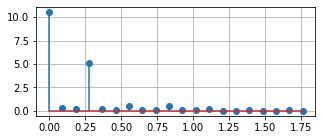

Index_986


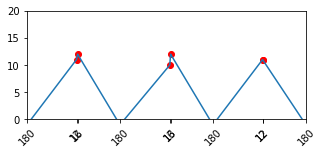

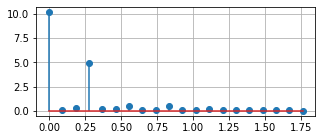

Index_988


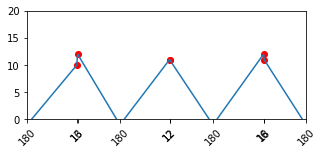

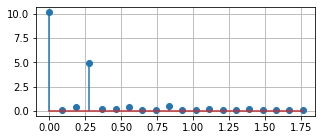

Index_991


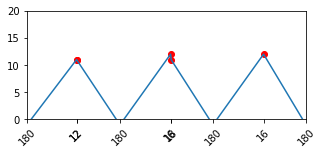

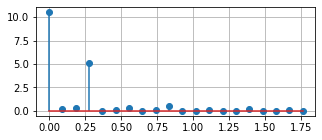

Index_993


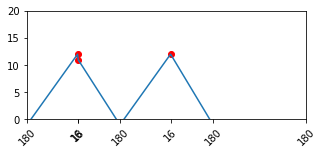

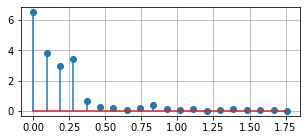

Index_994


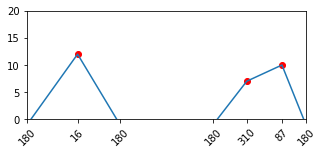

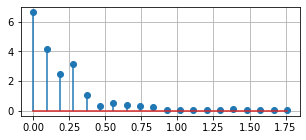

Index_995


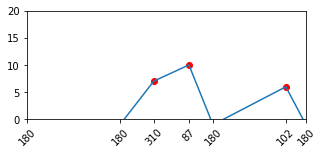

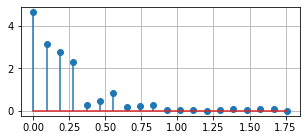

Index_996


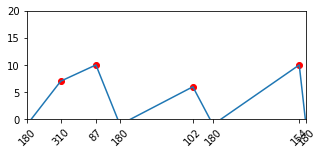

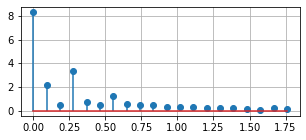

Index_997


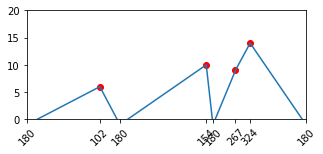

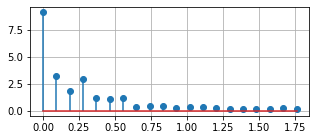

Index_998


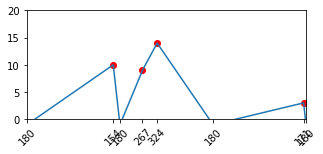

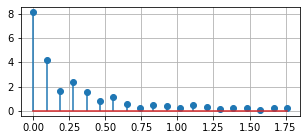

Index_999


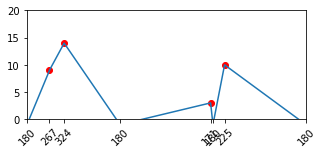

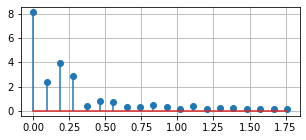

Case10: ('A3D01', 'Metrology-Type-01', 'AS1')
Index_4


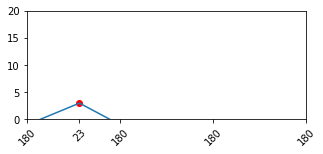

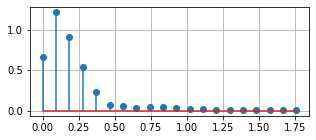

Index_6


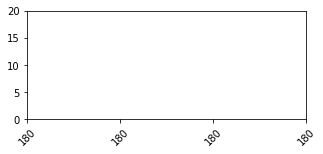

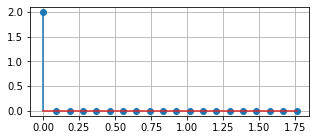

Index_8


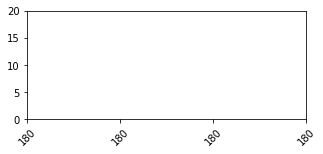

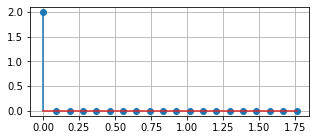

Index_10


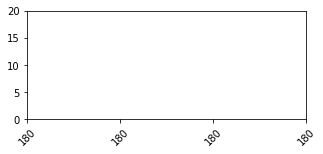

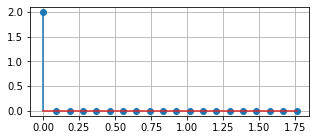

Index_12


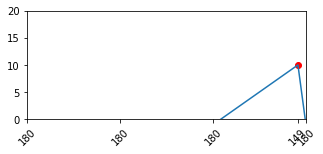

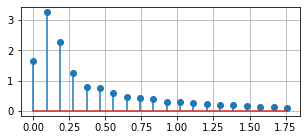

Index_15


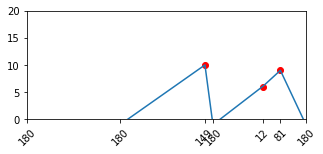

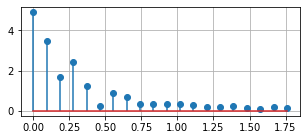

Index_16


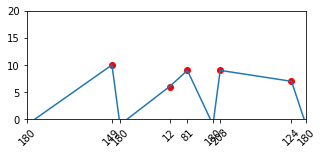

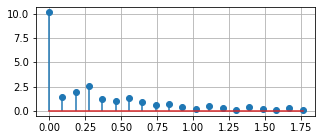

Index_18


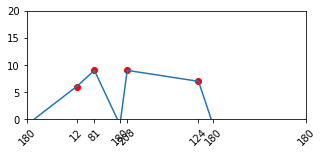

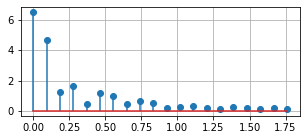

Index_21


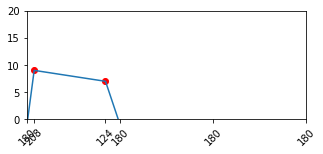

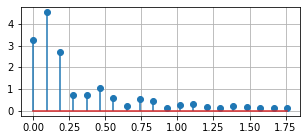

Index_23


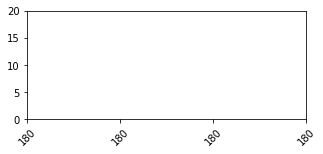

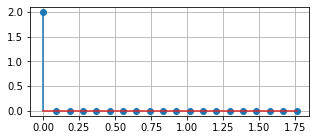

Index_25


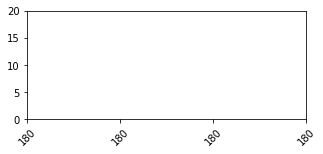

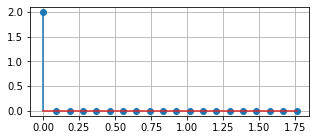

Index_27


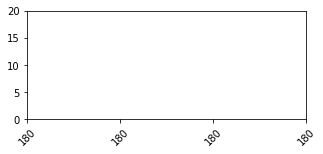

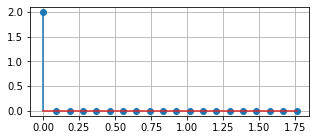

Index_29


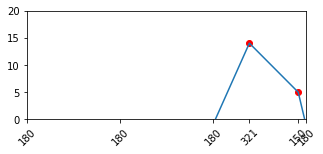

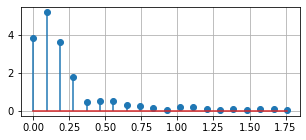

Index_31


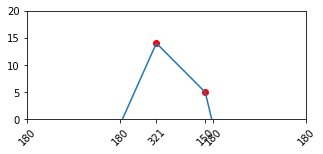

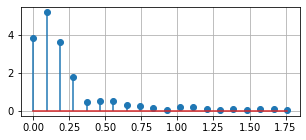

Index_33


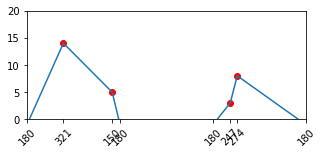

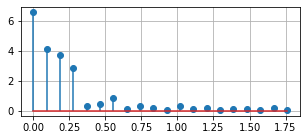

Index_35


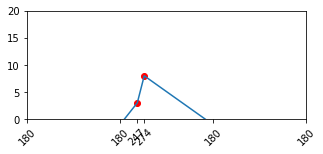

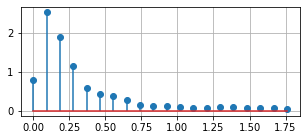

Index_37


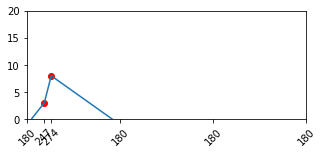

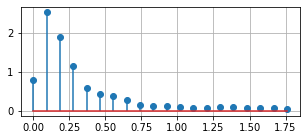

Index_39


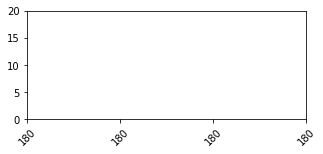

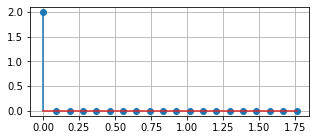

Index_89


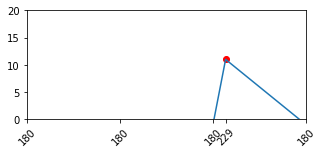

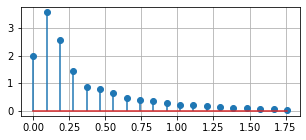

Index_91


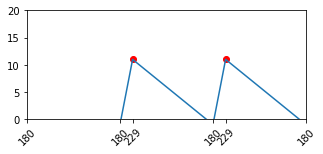

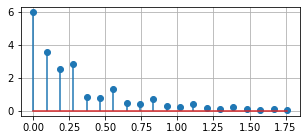

Index_93


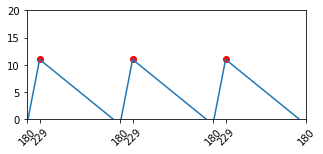

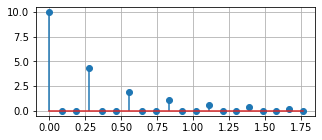

Index_94


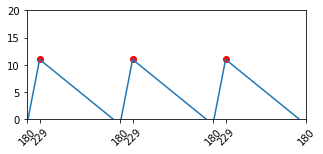

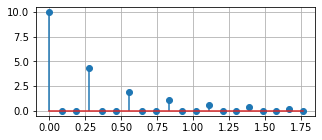

Index_96


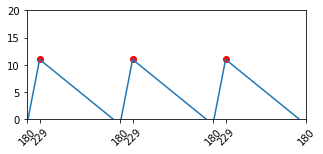

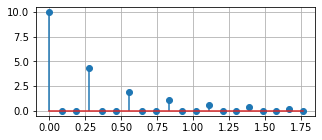

Index_98


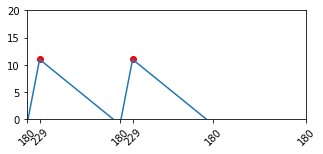

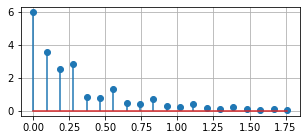

Index_100


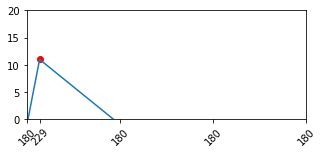

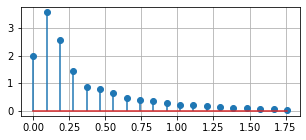

Index_103


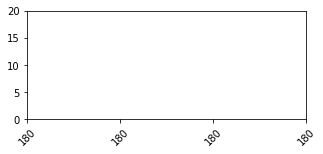

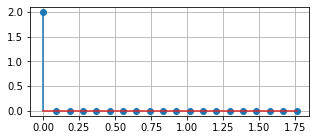

Index_105


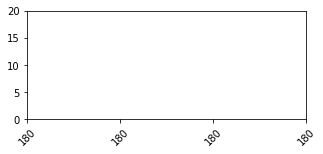

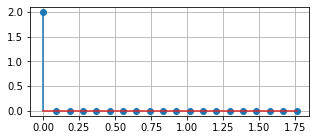

Index_107


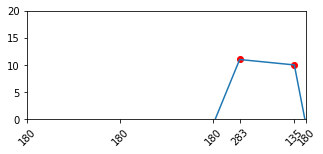

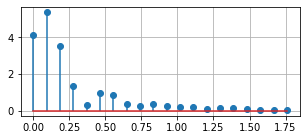

Index_109


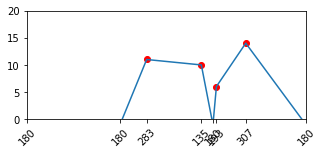

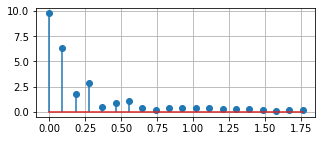

Index_110


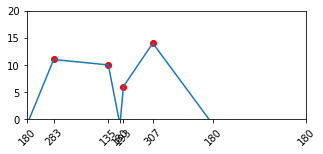

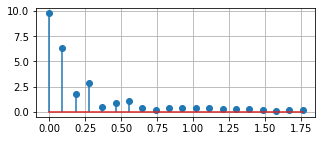

Index_113


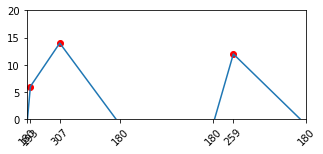

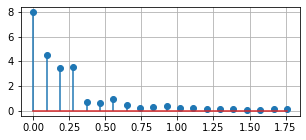

Index_115


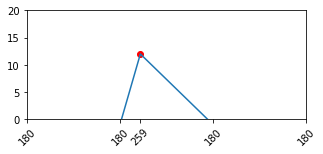

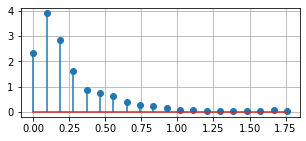

Index_117


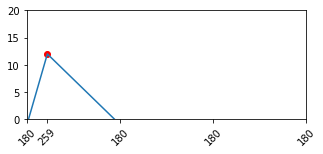

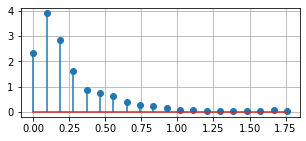

Index_118


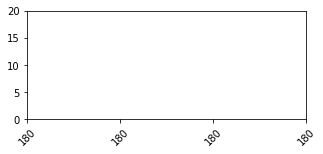

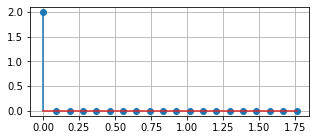

Index_120


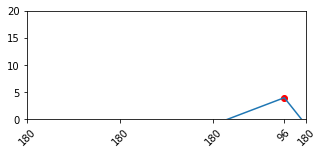

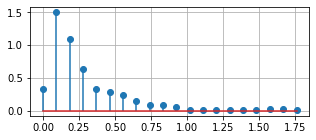

Index_122


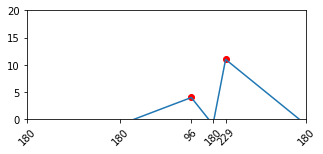

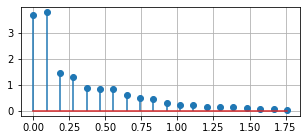

Index_124


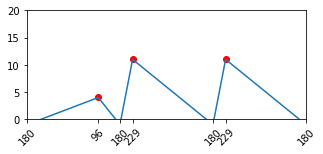

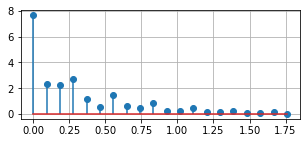

Index_126


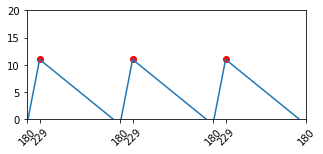

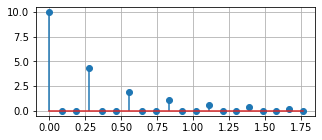

Index_128


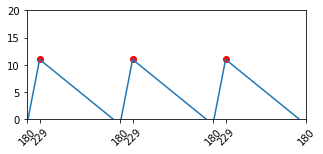

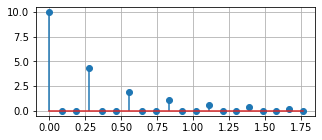

Index_131


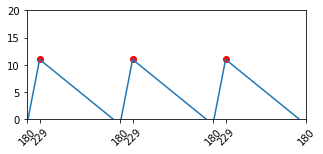

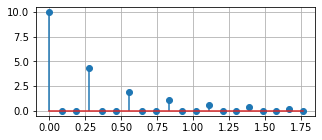

Index_132


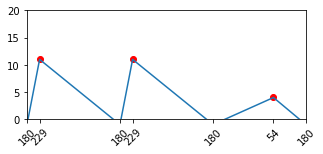

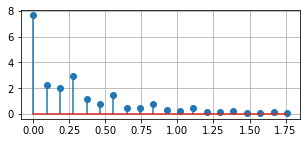

Index_134


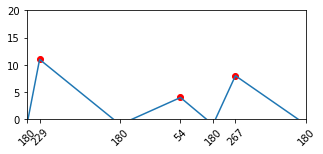

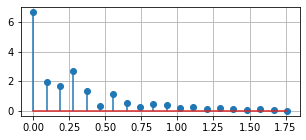

Index_136


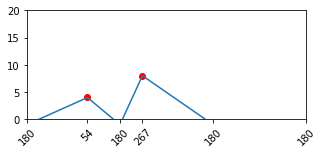

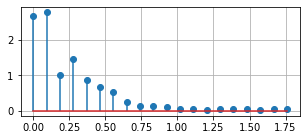

Index_138


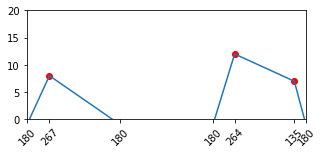

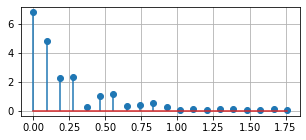

Index_140


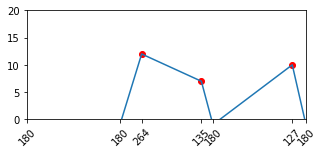

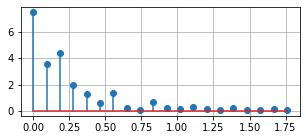

Index_142


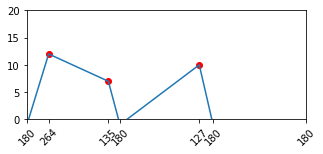

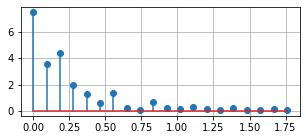

Index_144


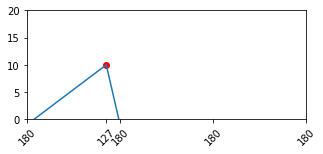

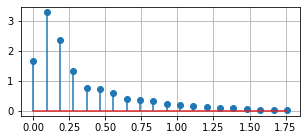

Index_146


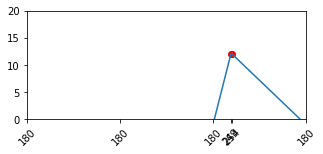

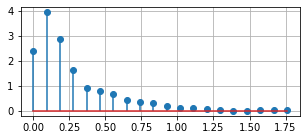

Index_149


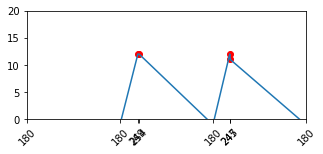

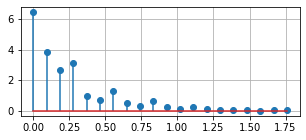

Index_151


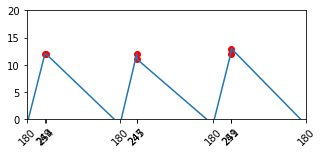

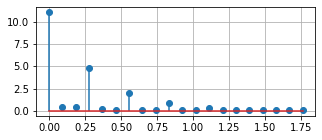

Index_153


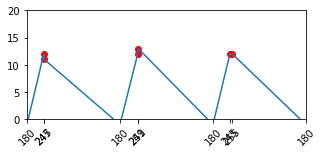

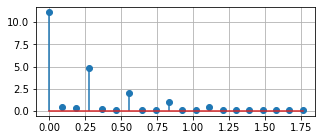

Index_155


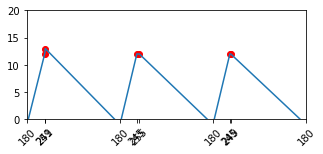

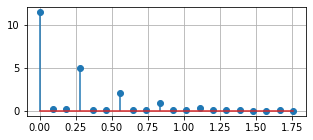

Index_157


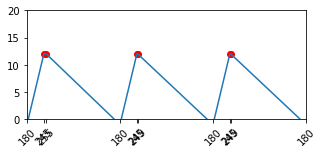

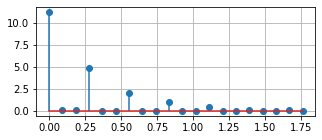

Index_159


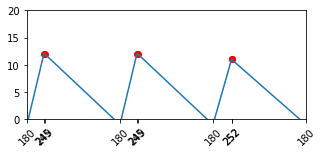

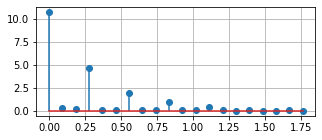

Index_162


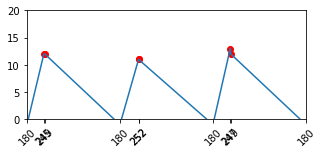

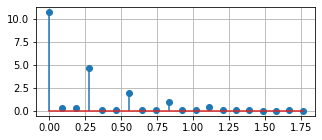

Index_163


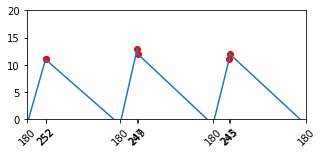

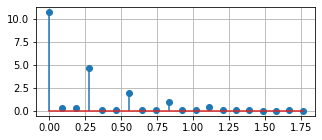

Index_165


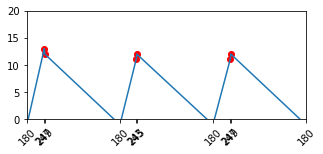

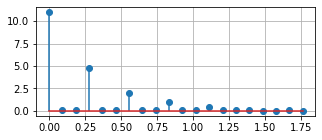

Index_167


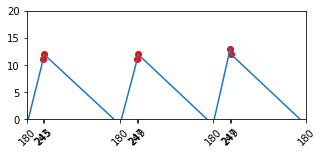

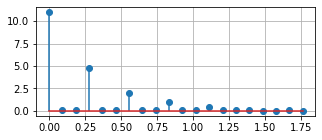

Index_169


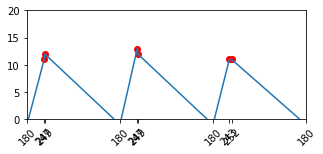

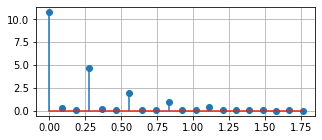

Index_171


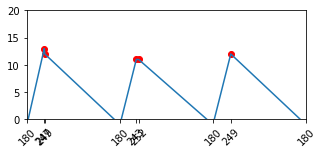

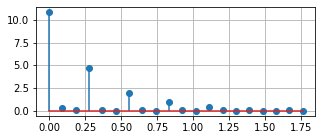

Index_172


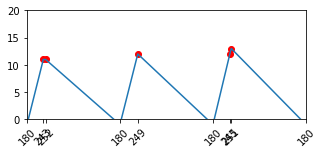

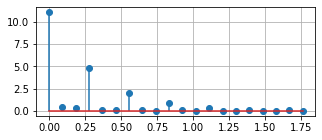

Index_174


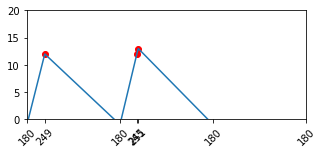

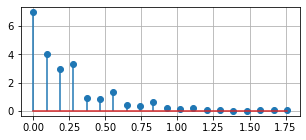

Index_176


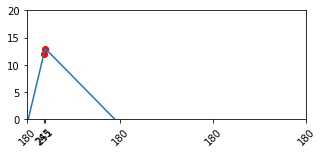

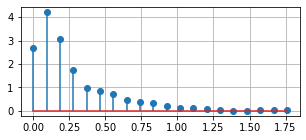

Index_179


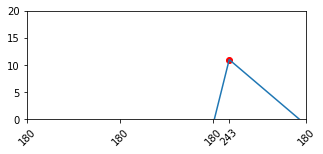

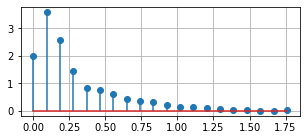

Index_180


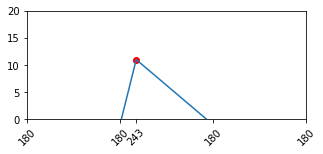

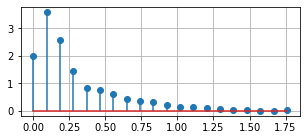

Index_182


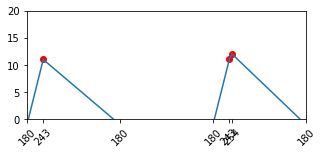

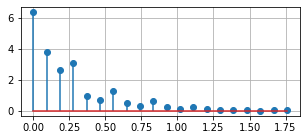

Index_185


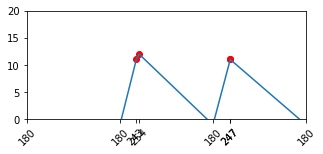

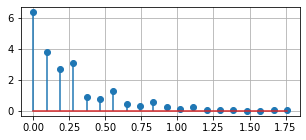

Index_187


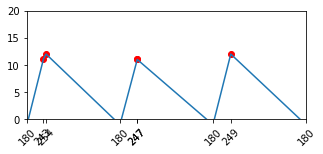

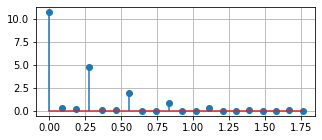

Index_189


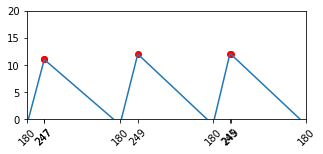

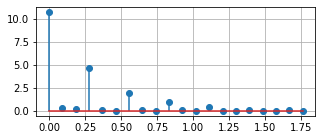

Index_191


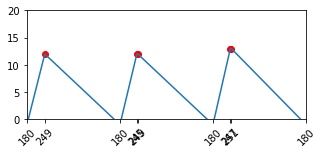

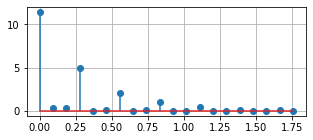

Index_192


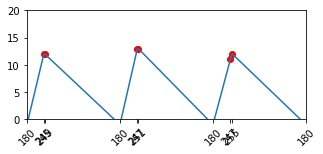

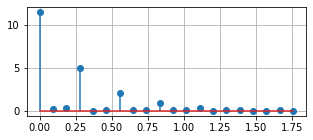

Index_194


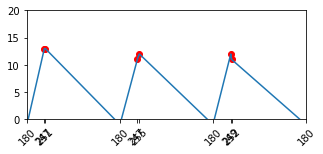

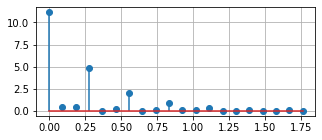

Index_196


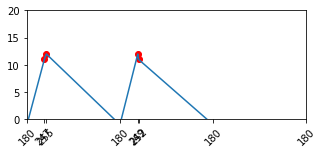

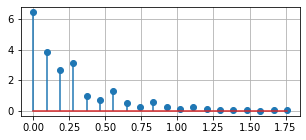

Index_198


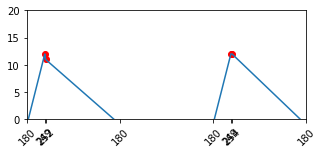

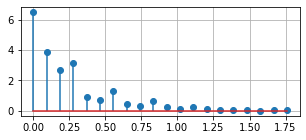

Index_200


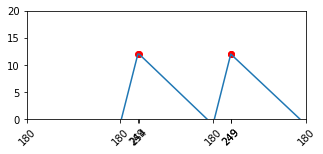

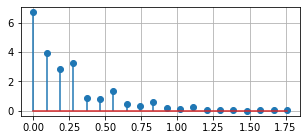

Index_202


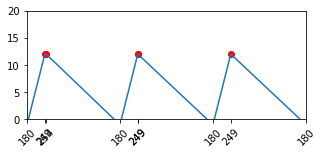

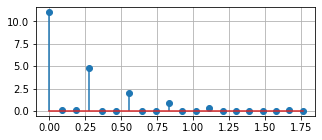

Index_204


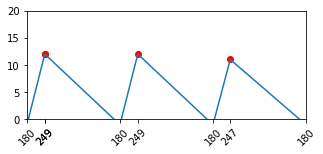

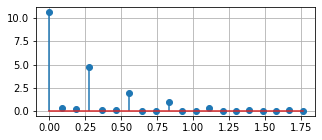

Index_206


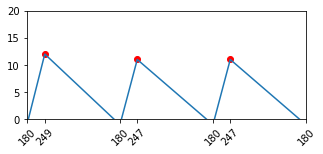

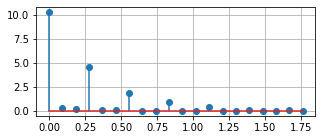

Index_209


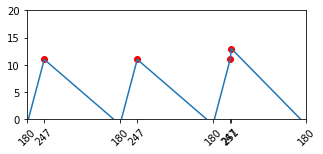

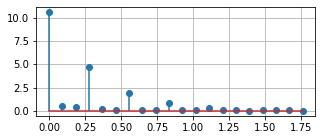

Index_211


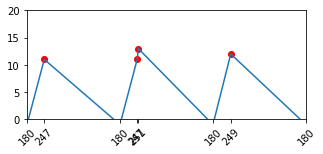

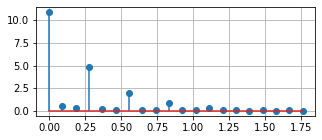

Index_213


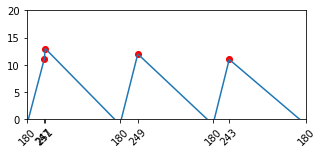

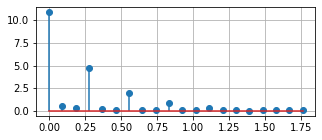

Index_215


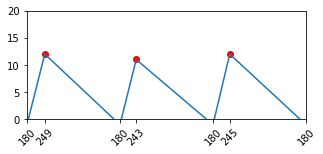

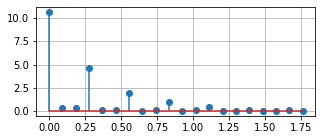

Index_217


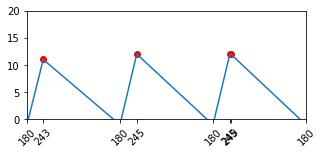

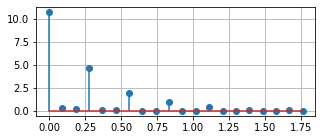

Index_219


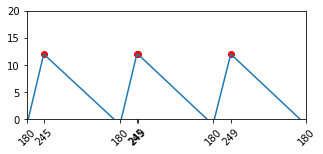

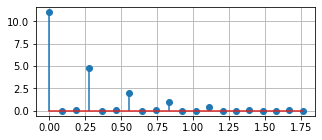

Index_221


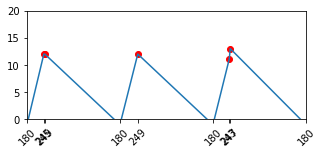

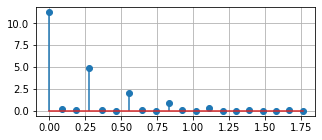

Index_223


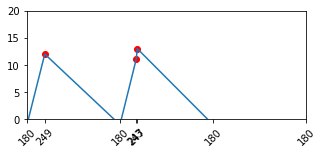

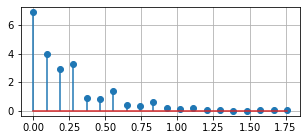

Index_225


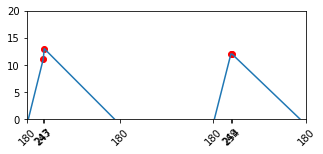

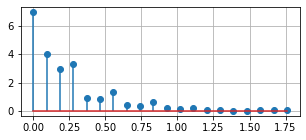

Index_227


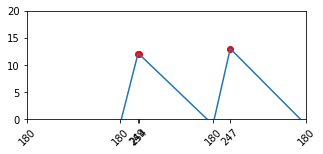

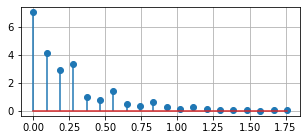

Index_229


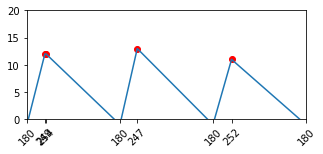

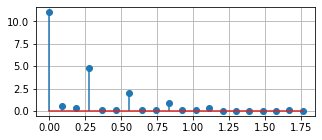

Index_231


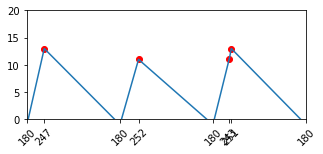

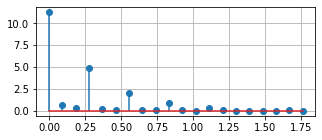

Index_311


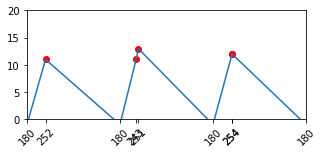

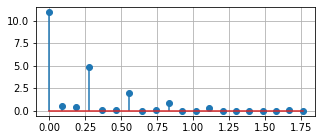

Index_313


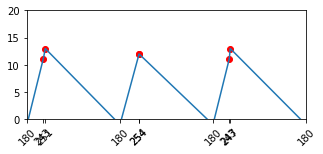

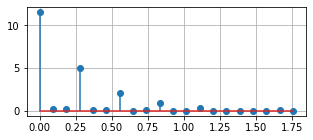

Index_315


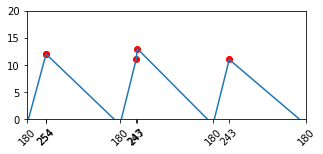

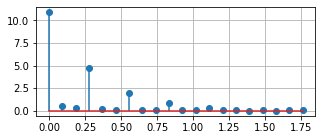

Index_317


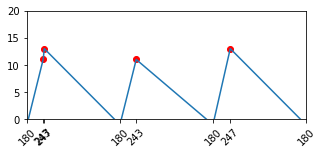

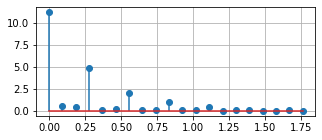

Index_319


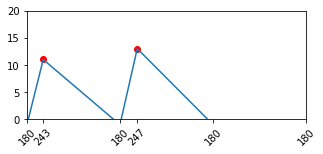

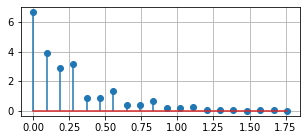

Index_321


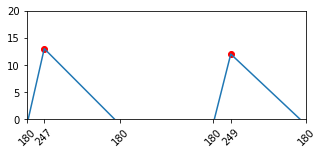

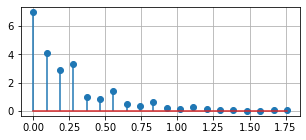

Index_328


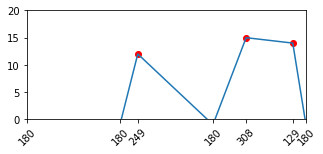

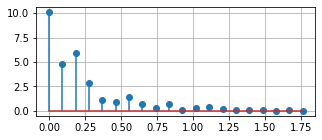

Index_330


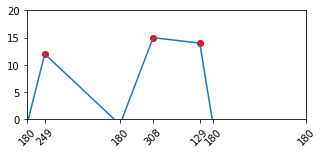

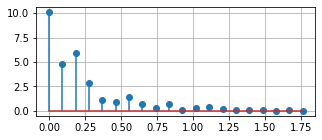

Index_333


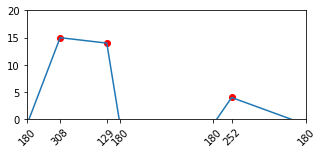

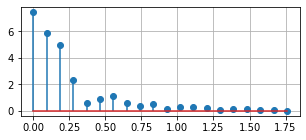

Index_335


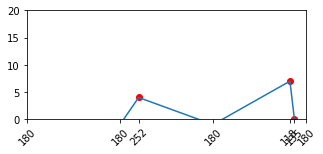

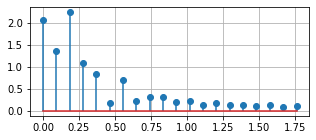

Index_336


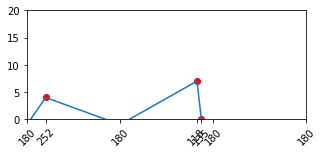

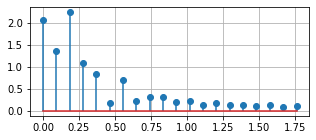

Index_339


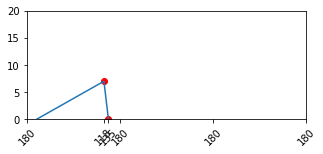

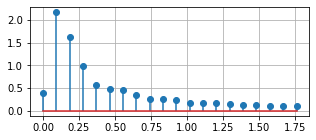

Index_341


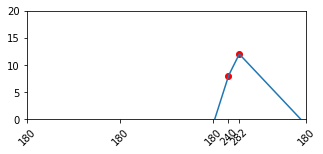

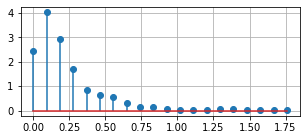

Index_343


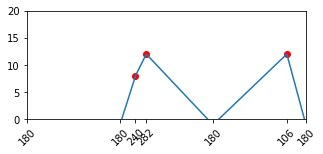

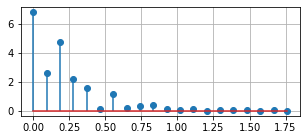

Index_344


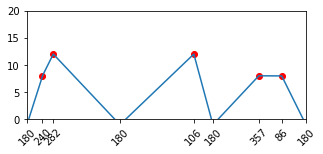

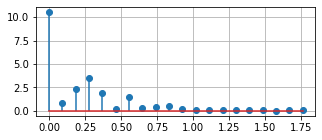

Index_346


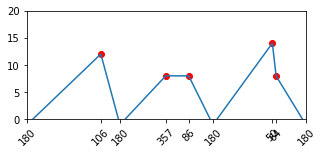

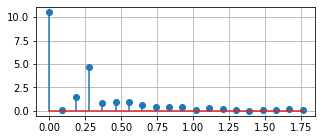

Index_348


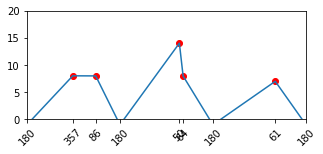

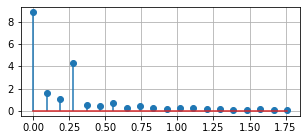

Index_350


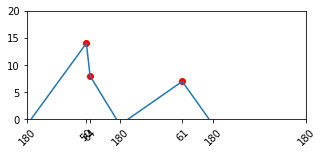

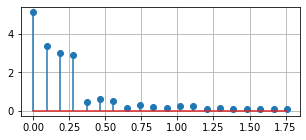

Index_352


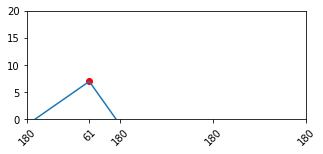

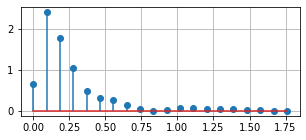

Index_353


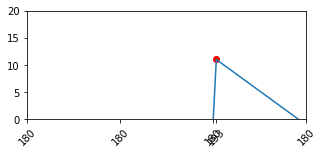

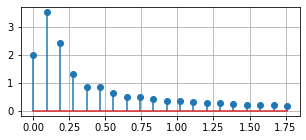

Index_355


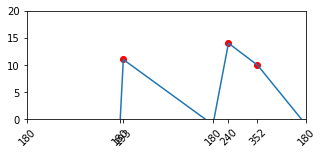

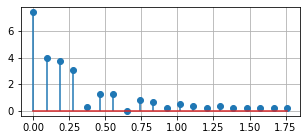

Index_356


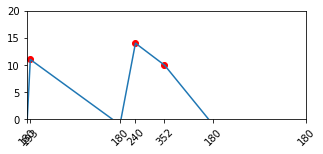

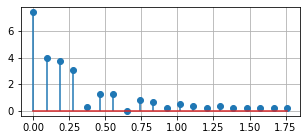

Index_358


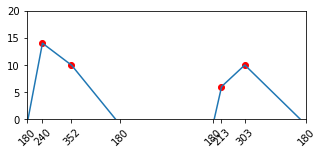

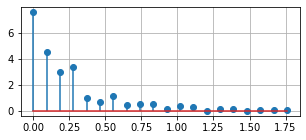

Index_361


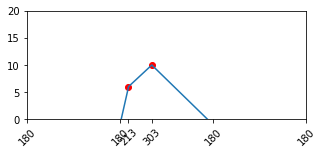

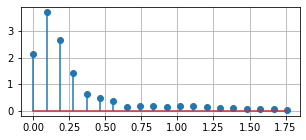

Index_363


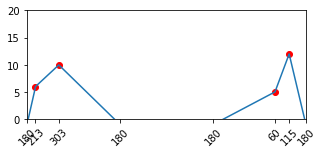

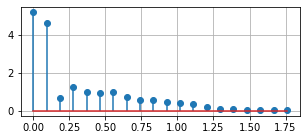

Index_499


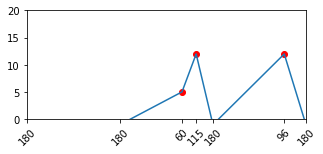

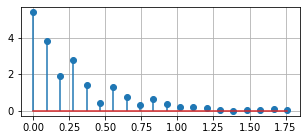

Index_501


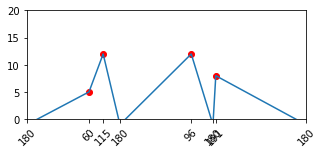

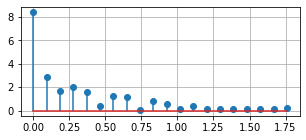

Index_503


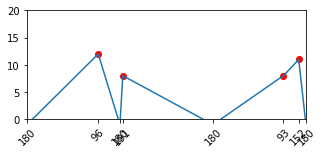

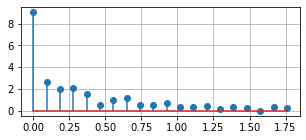

Index_505


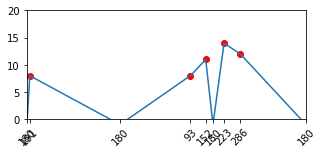

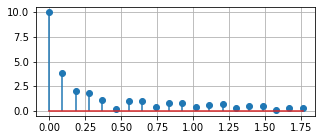

Index_507


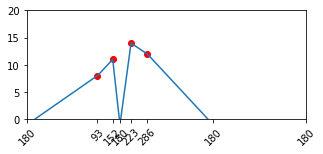

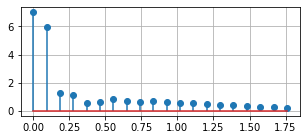

Index_509


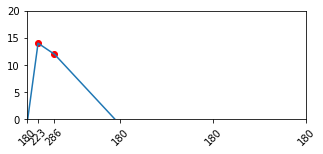

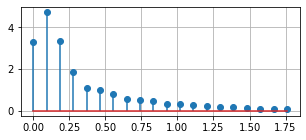

Index_511


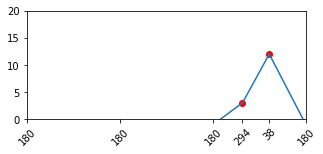

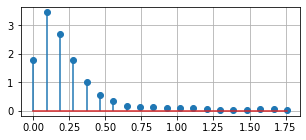

Index_513


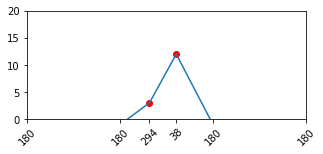

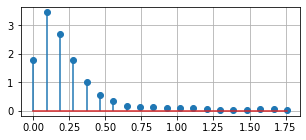

Index_515


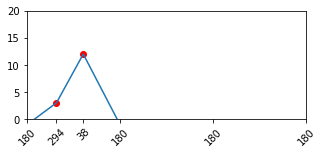

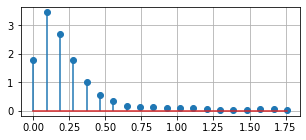

Index_518


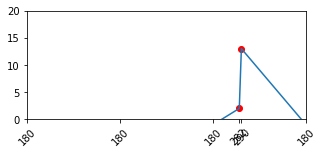

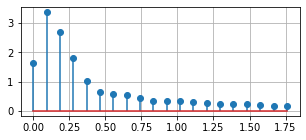

Index_520


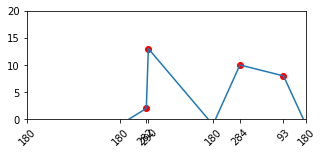

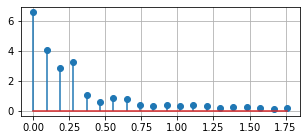

Index_521


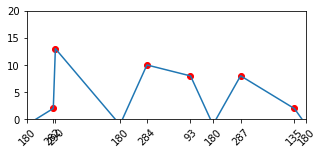

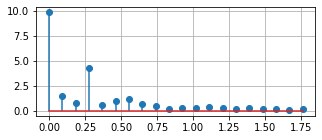

Index_523


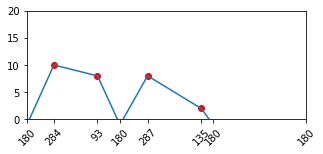

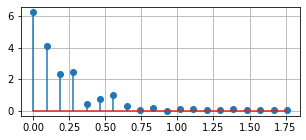

Index_526


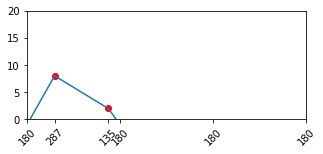

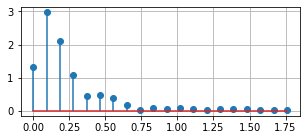

Index_528


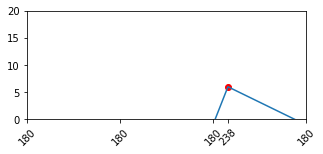

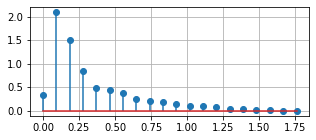

Index_530


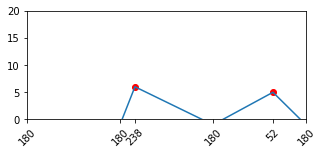

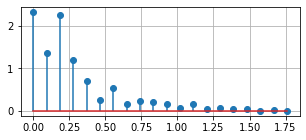

Index_532


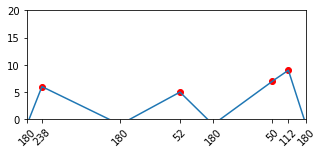

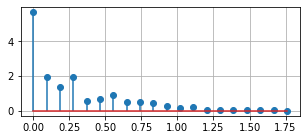

Index_534


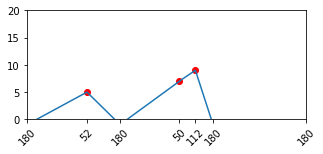

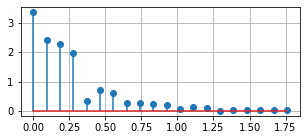

Index_536


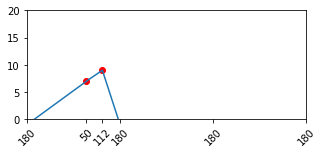

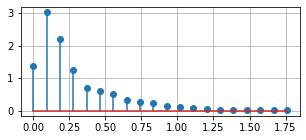

Index_538


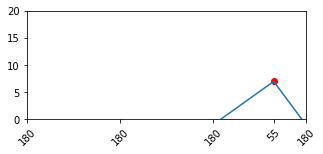

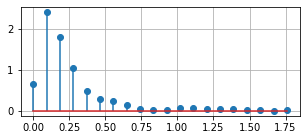

Index_540


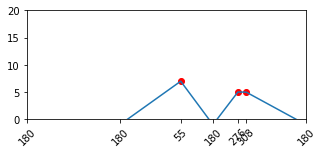

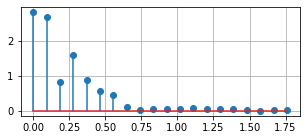

Index_543


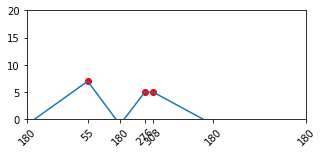

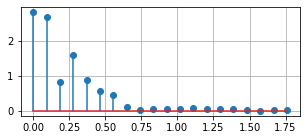

Index_544


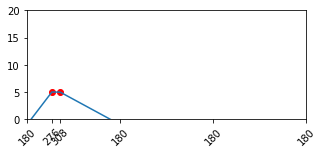

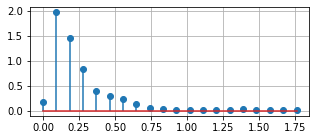

Index_546


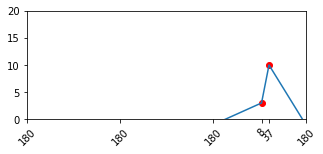

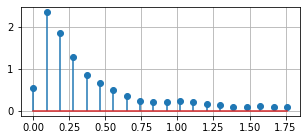

Index_548


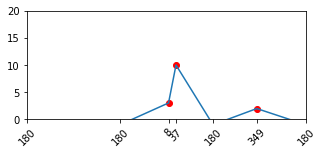

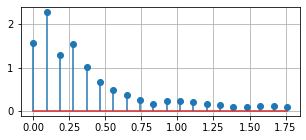

Index_551


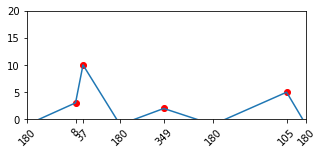

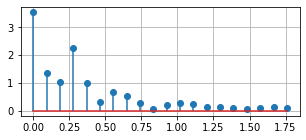

Index_552


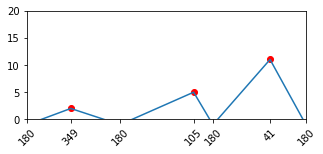

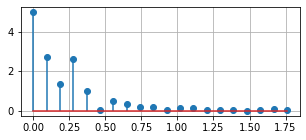

Index_554


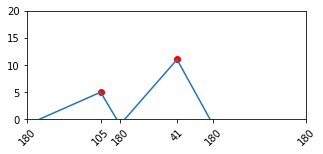

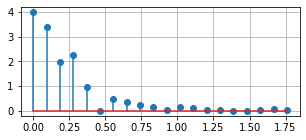

Index_555


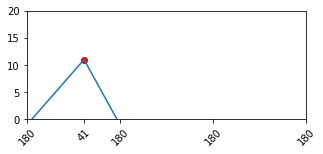

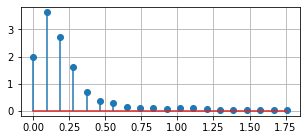

Index_558


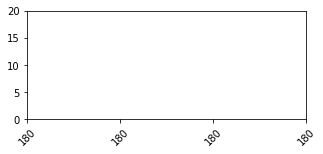

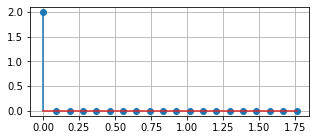

Index_560


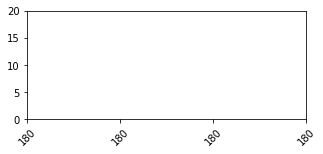

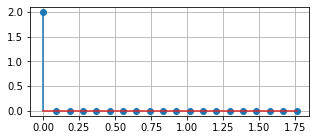

Index_562


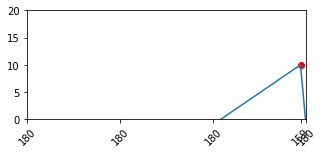

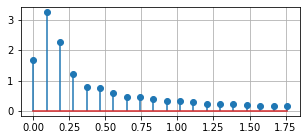

Index_564


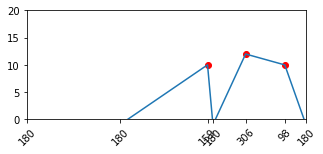

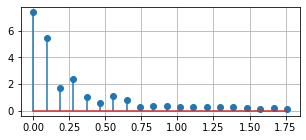

Index_566


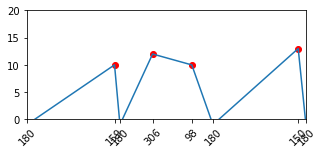

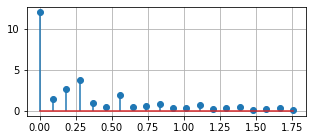

Index_568


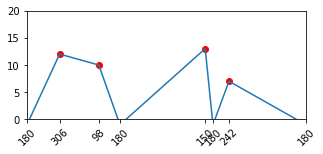

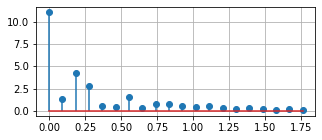

Index_569


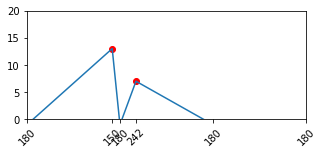

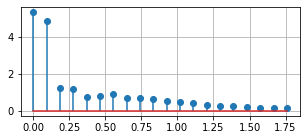

Index_572


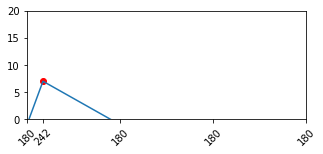

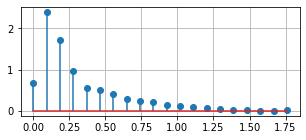

Index_574


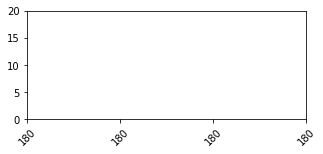

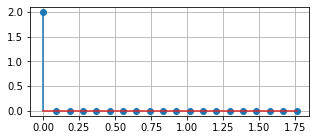

Index_576


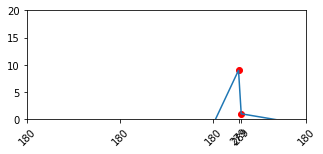

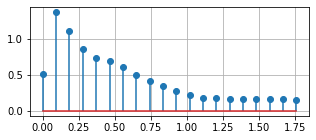

Index_578


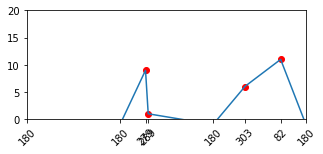

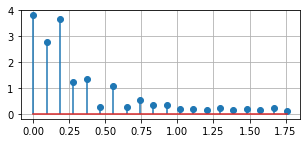

Index_580


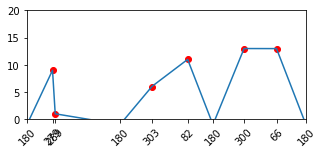

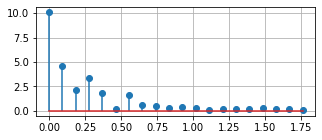

Index_581


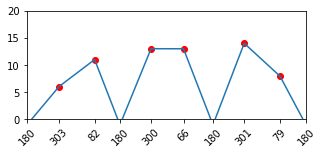

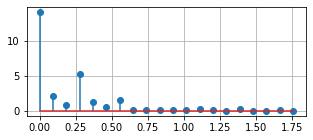

Index_584


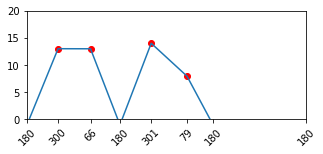

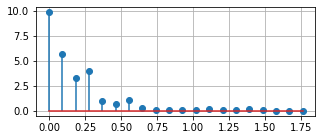

Index_586


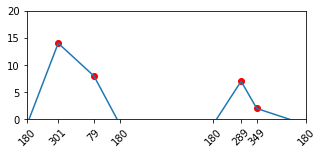

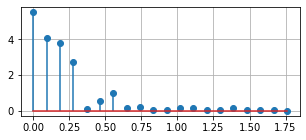

Index_588


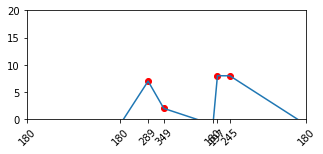

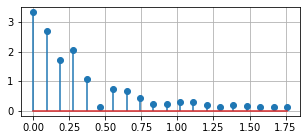

Index_591


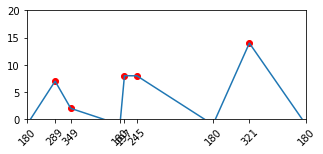

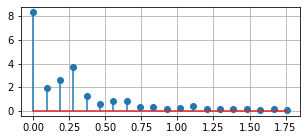

Index_593


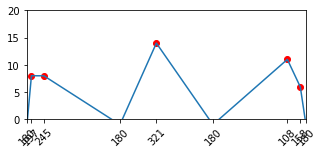

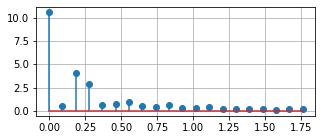

Index_595


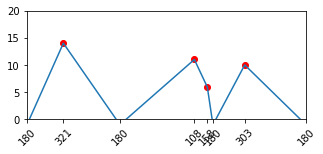

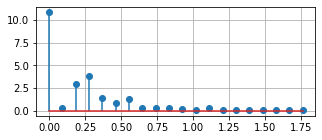

Index_597


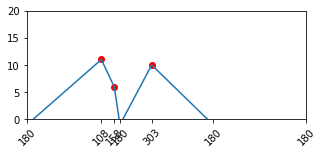

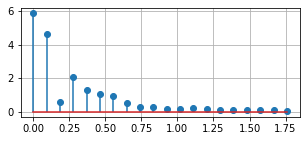

Index_599


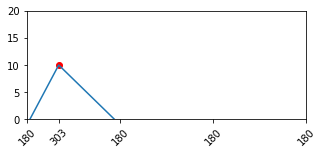

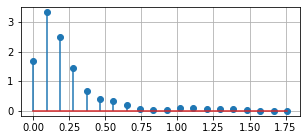

Index_649


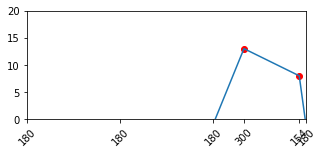

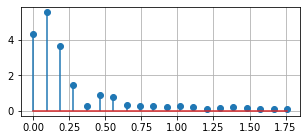

Index_652


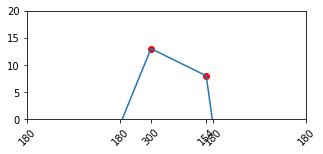

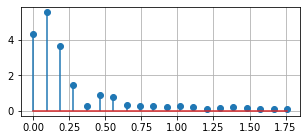

Index_653


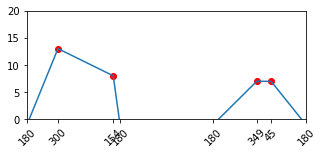

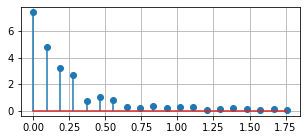

Index_655


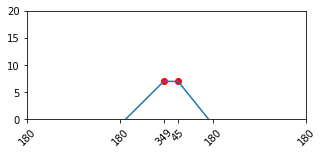

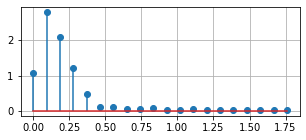

Index_657


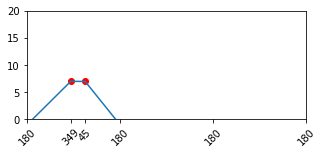

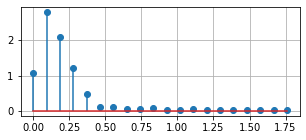

Index_659


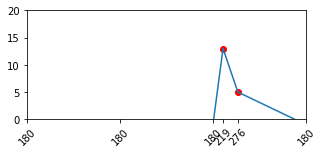

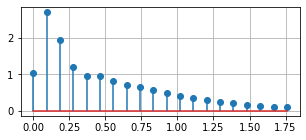

Index_661


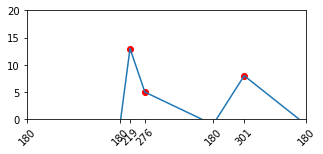

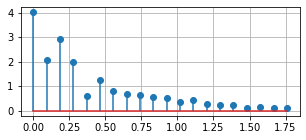

Index_662


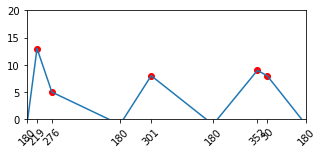

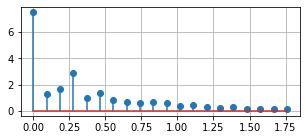

Index_665


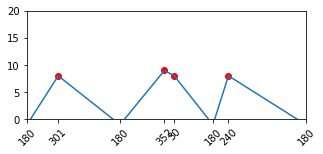

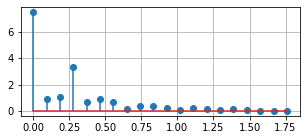

Index_667


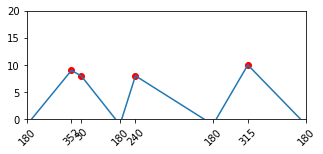

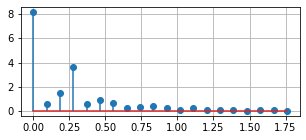

Index_669


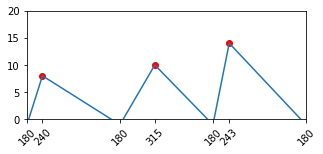

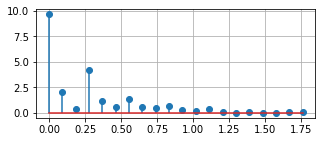

Index_670


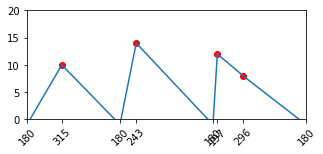

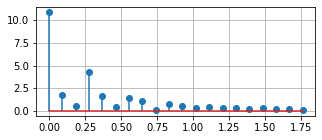

Index_673


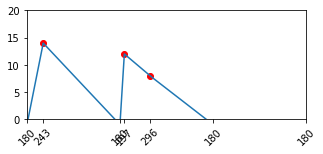

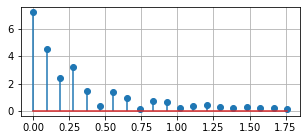

Index_674


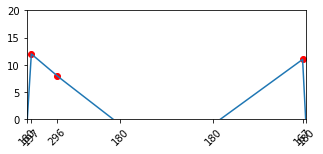

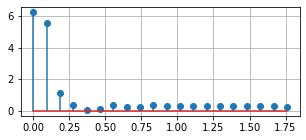

Index_676


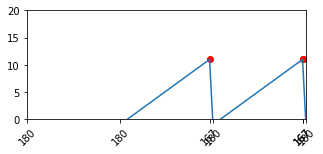

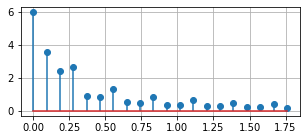

Index_678


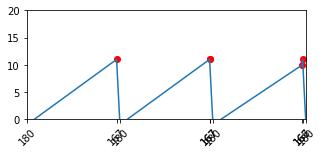

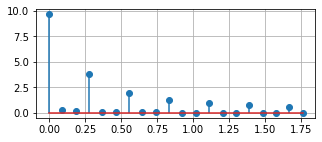

Index_680


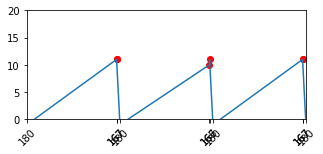

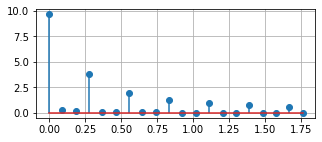

Index_682


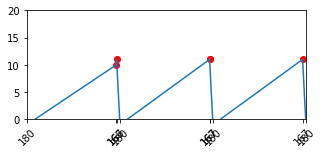

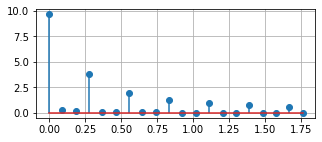

Index_684


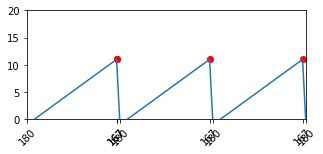

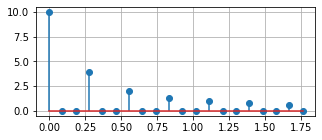

Index_686


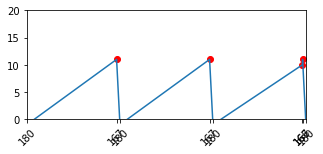

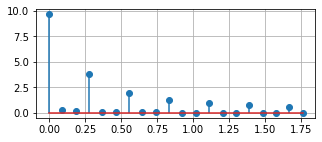

Index_688


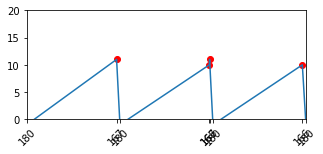

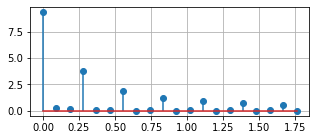

Index_690


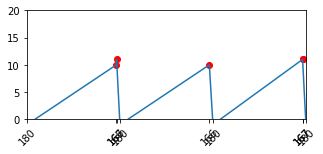

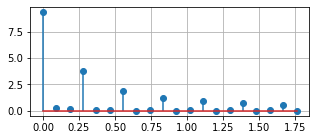

Index_693


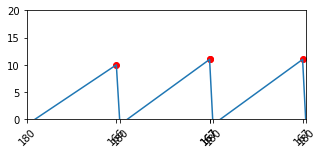

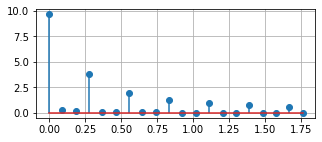

Index_695


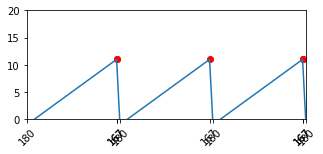

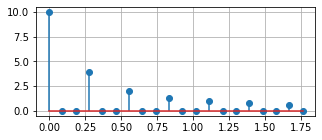

Index_697


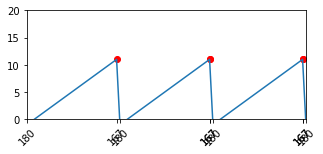

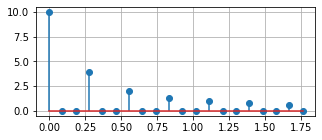

Index_699


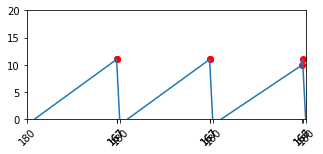

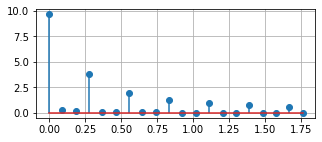

Index_701


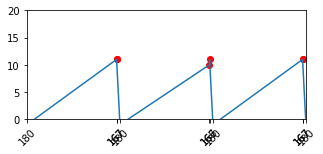

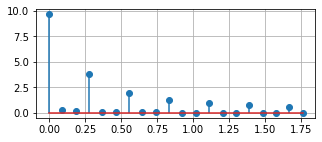

Index_703


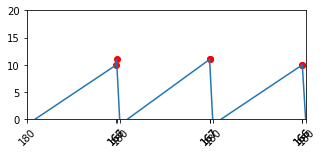

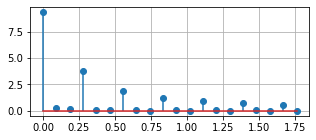

Index_705


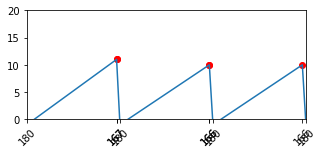

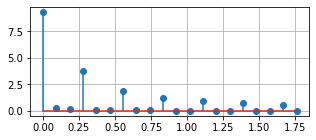

Index_707


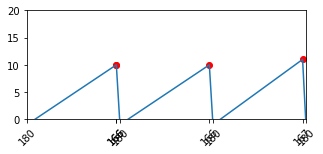

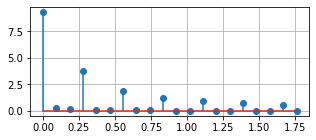

Index_709


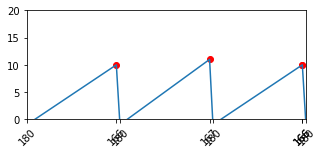

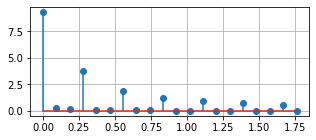

Index_711


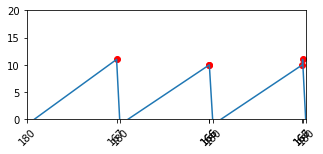

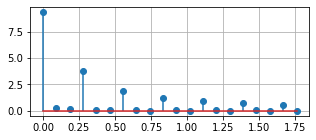

Index_712


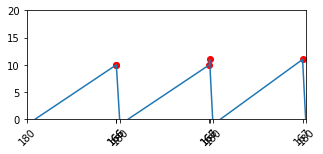

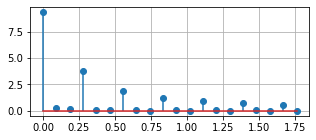

Index_714


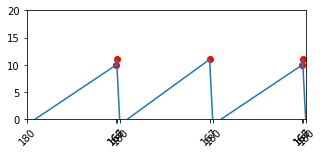

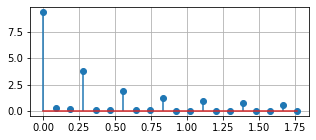

Index_716


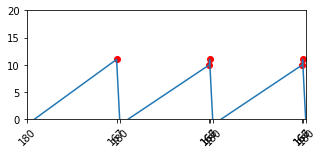

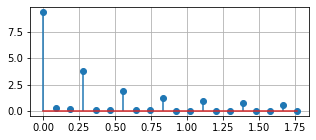

Index_719


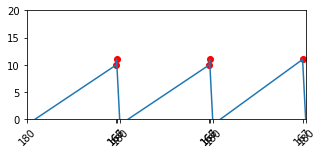

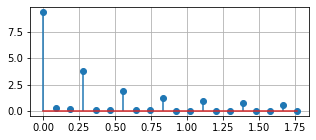

Index_721


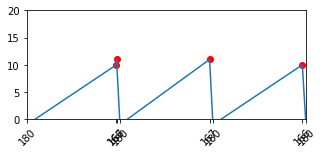

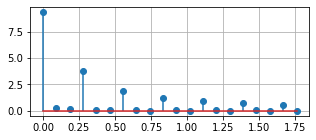

Index_722


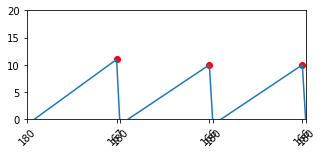

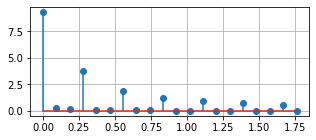

Index_724


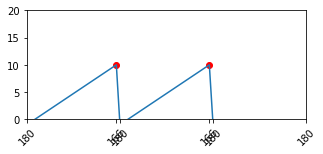

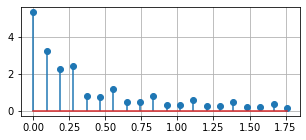

Index_727


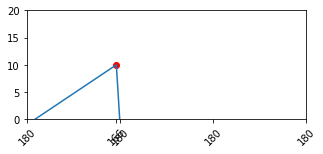

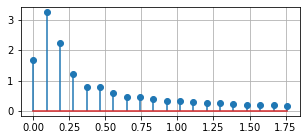

Index_729


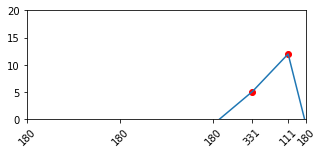

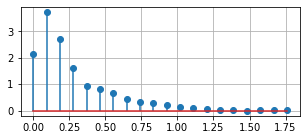

Index_731


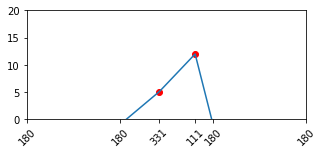

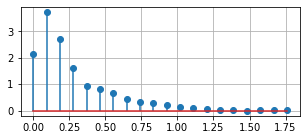

Index_733


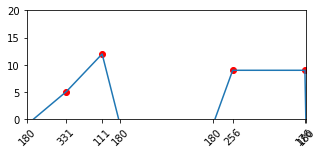

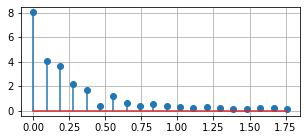

Index_735


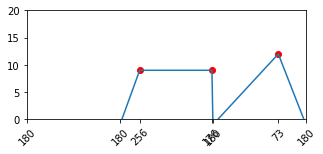

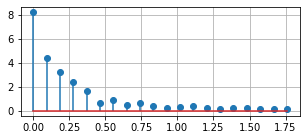

Index_737


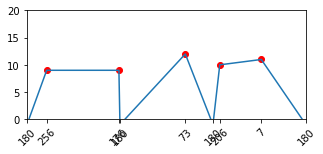

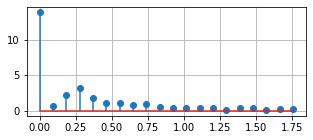

Index_739


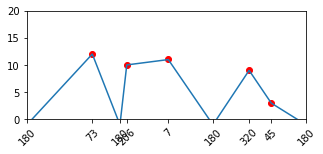

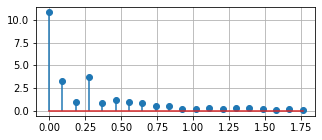

Index_741


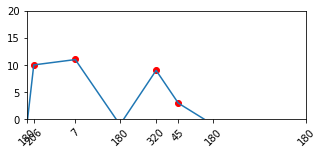

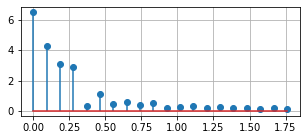

Index_743


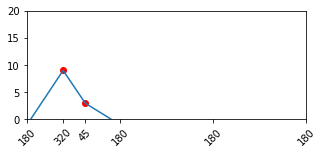

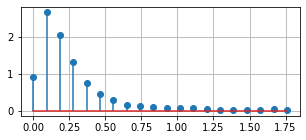

Index_746


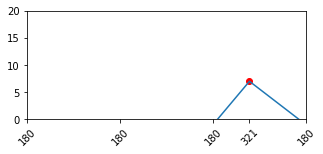

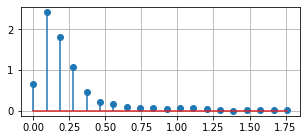

Index_748


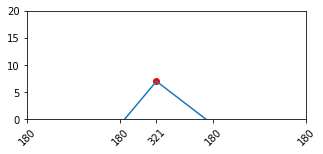

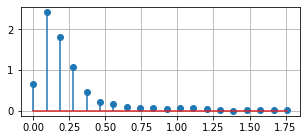

Index_750


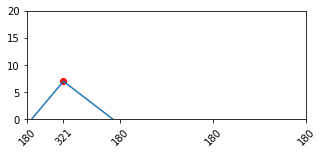

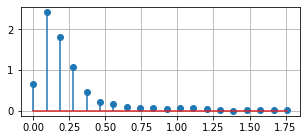

Index_752


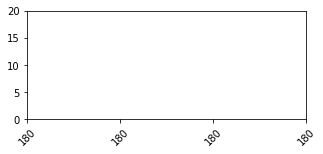

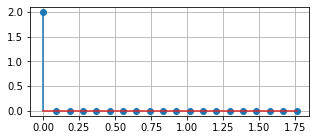

Index_754


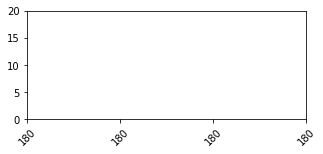

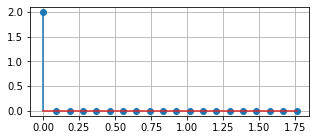

Index_756


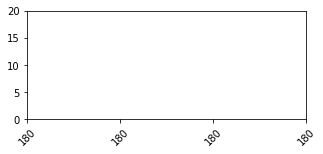

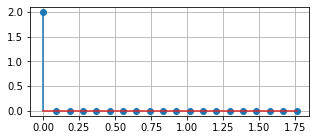

Index_758


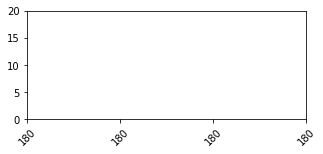

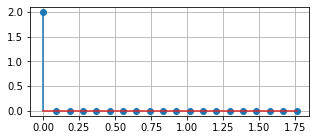

Index_760


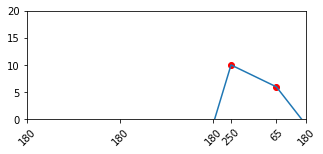

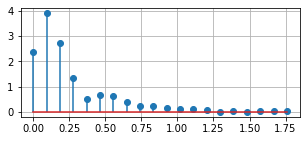

Index_762


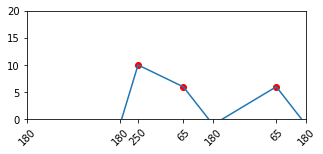

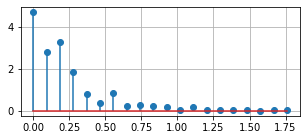

Index_764


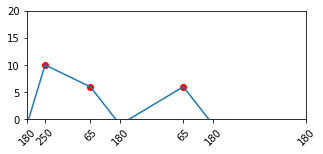

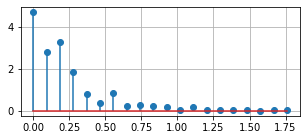

Index_766


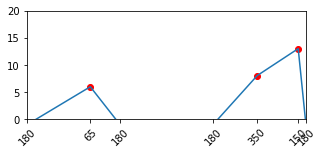

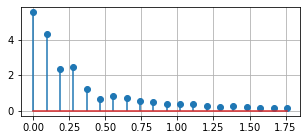

Index_768


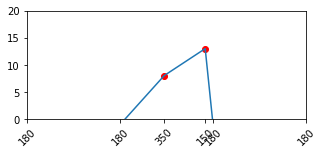

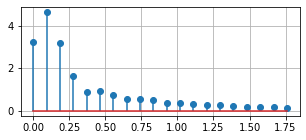

Index_771


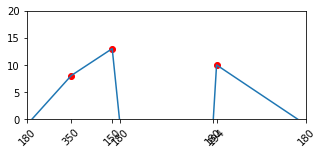

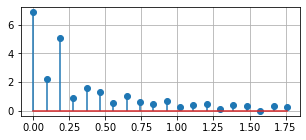

Index_773


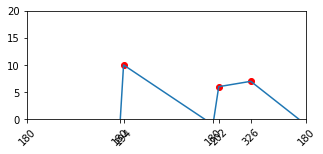

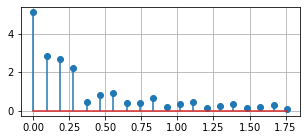

Index_775


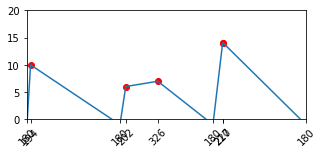

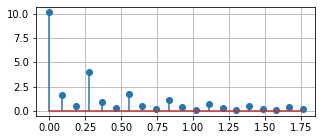

Index_828


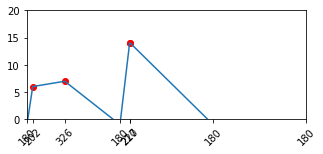

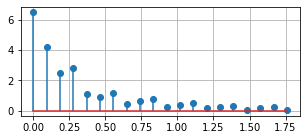

Index_830


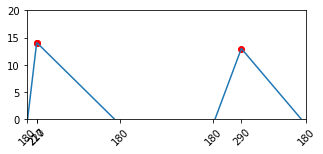

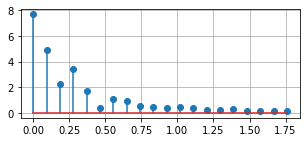

Index_832


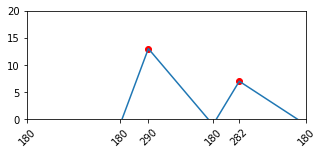

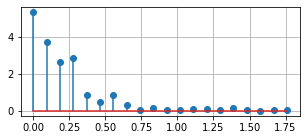

Index_834


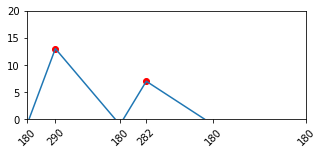

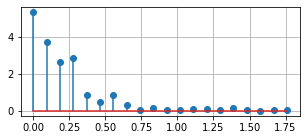

Index_836


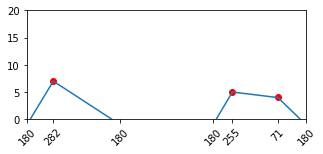

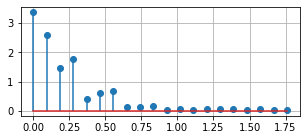

Index_838


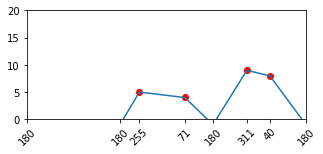

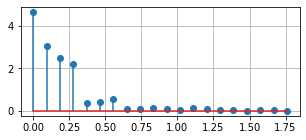

Index_839


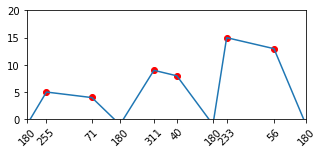

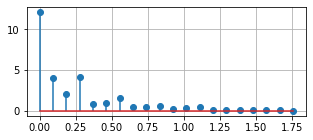

Index_841


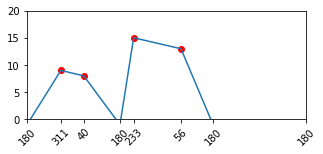

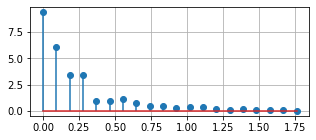

Index_843


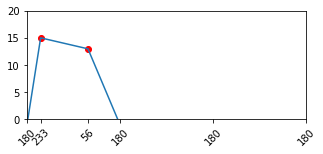

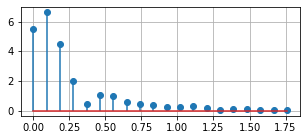

Index_846


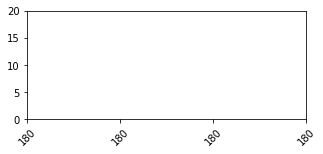

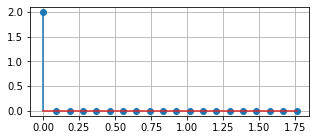

Index_847


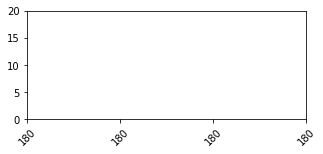

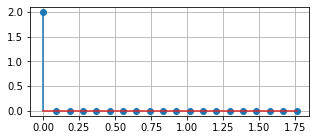

Index_849


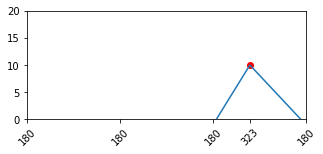

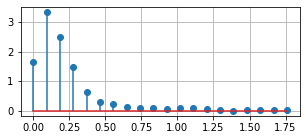

Index_851


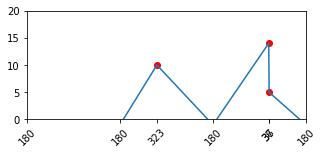

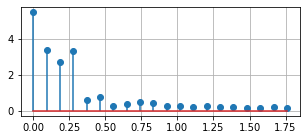

Index_853


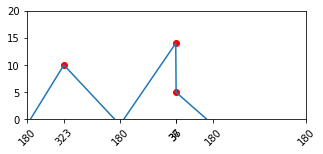

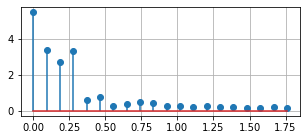

Index_855


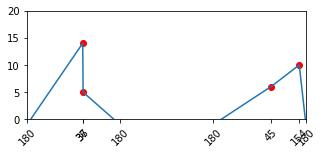

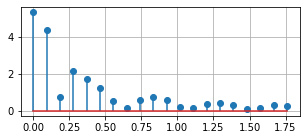

Index_858


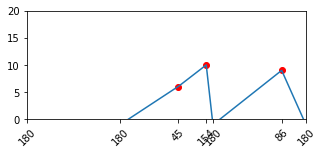

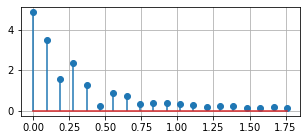

Index_860


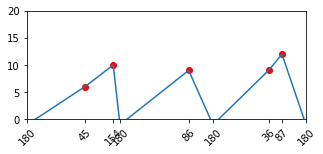

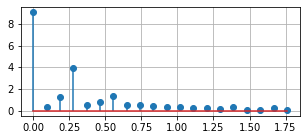

Index_862


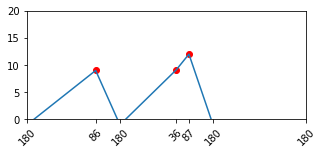

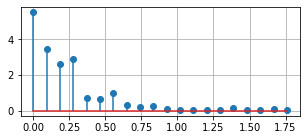

Index_864


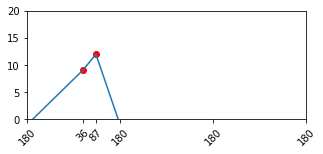

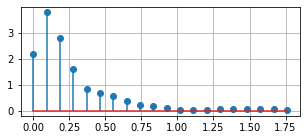

Index_866


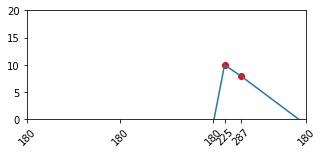

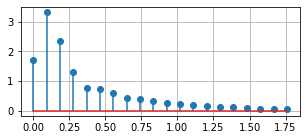

Index_868


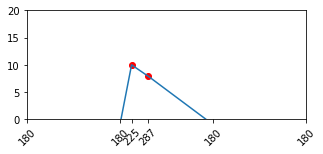

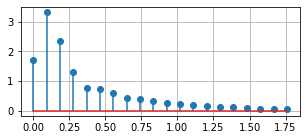

Index_870


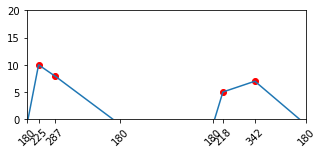

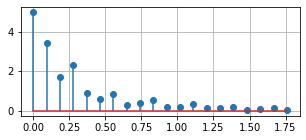

Index_872


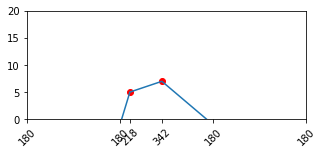

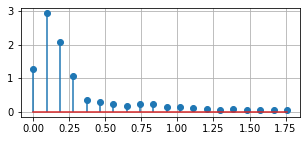

Index_874


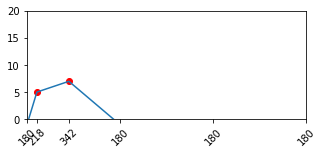

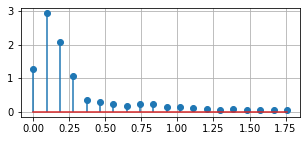

Index_876


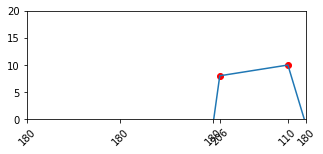

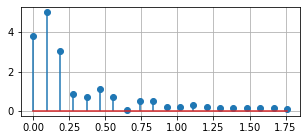

Index_878


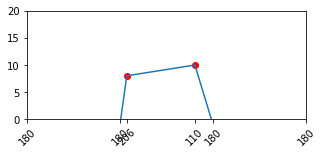

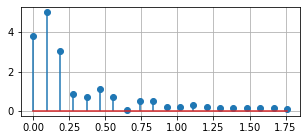

Index_880


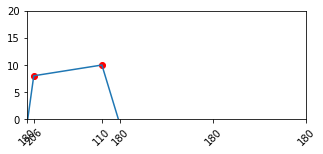

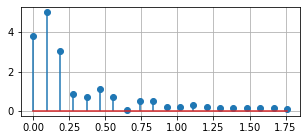

Index_882


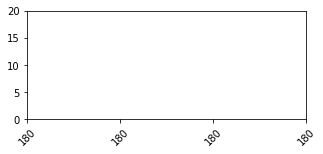

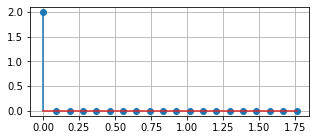

Index_884


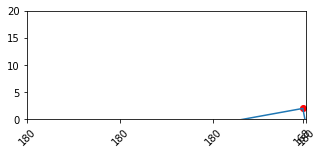

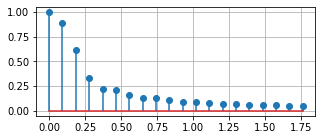

Index_886


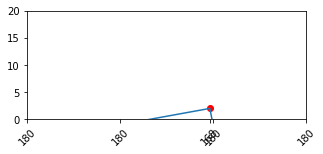

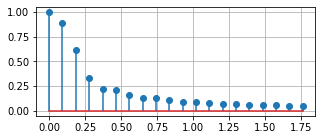

Index_889


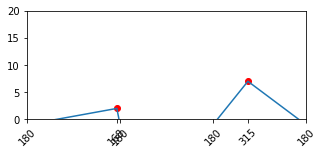

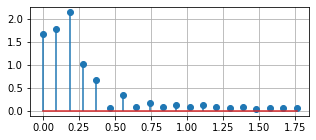

Index_891


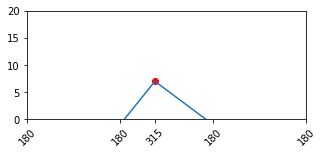

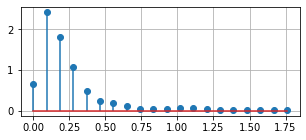

Index_893


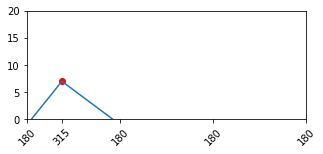

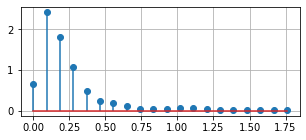

Index_896


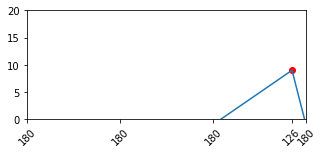

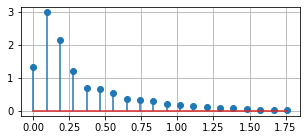

Index_897


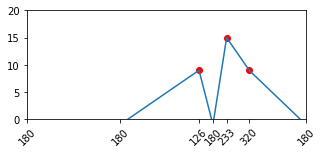

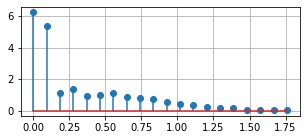

Index_900


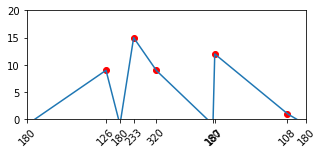

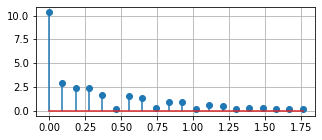

Index_901


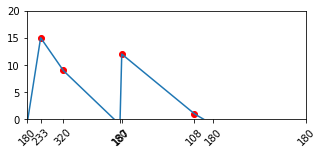

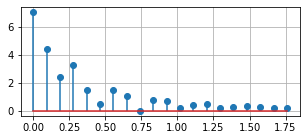

Index_903


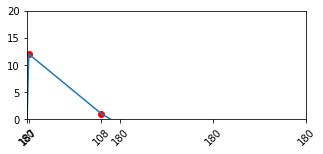

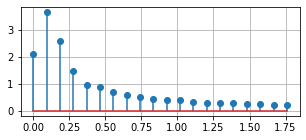

Index_905


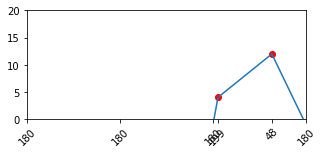

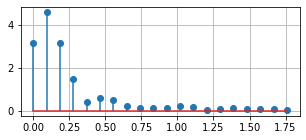

Index_907


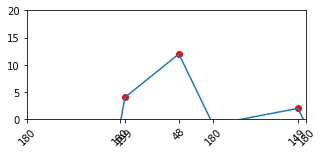

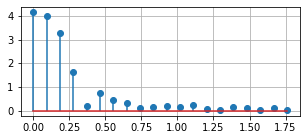

Index_910


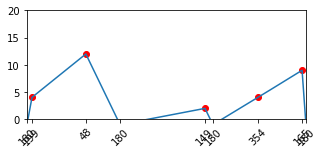

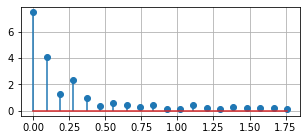

Index_911


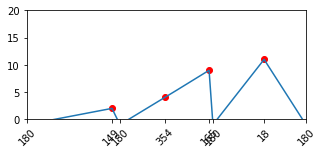

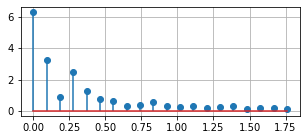

Index_914


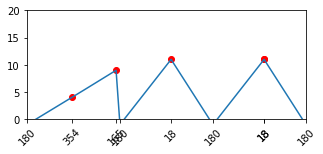

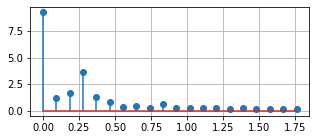

Index_916


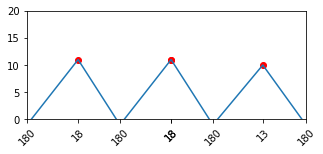

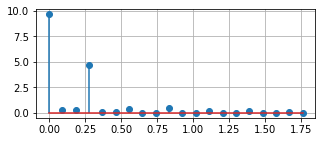

Index_918


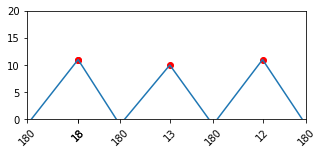

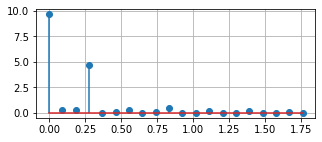

Index_919


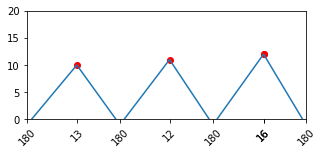

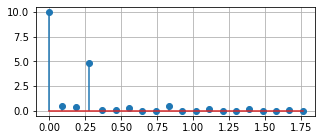

Index_921


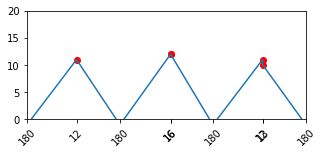

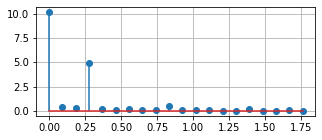

Index_923


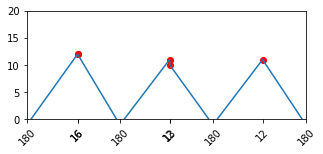

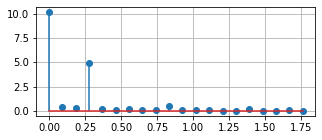

Index_925


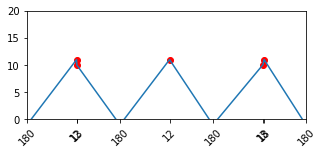

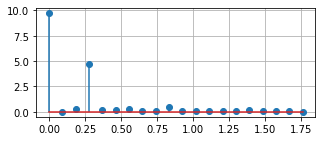

Index_927


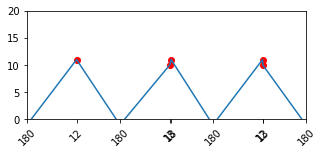

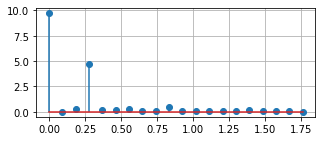

Index_929


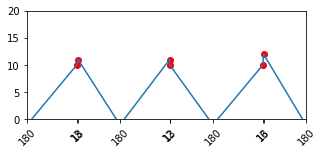

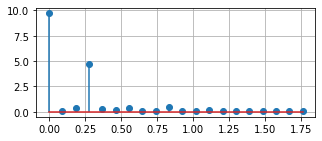

Index_931


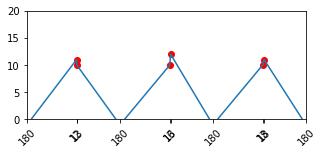

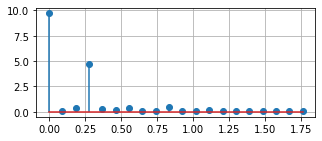

Index_933


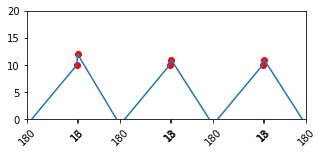

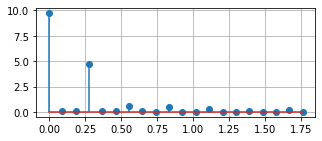

Index_935


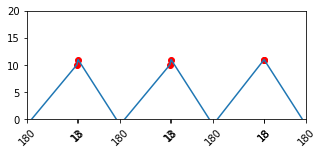

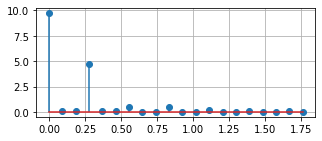

Index_938


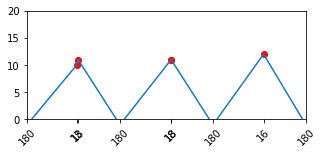

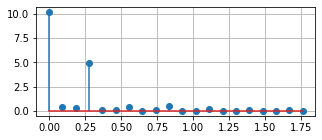

Index_940


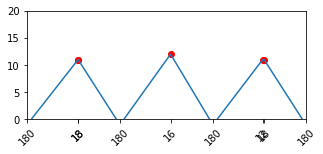

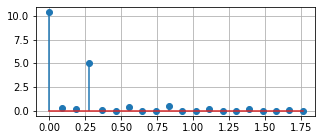

Index_942


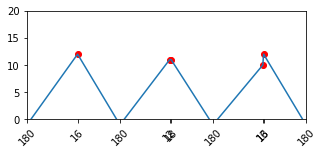

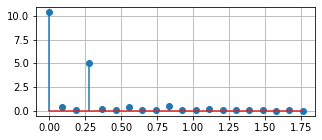

Index_945


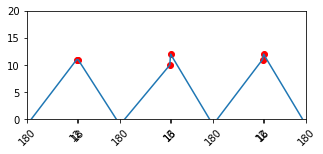

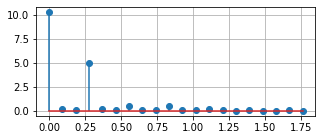

Index_946


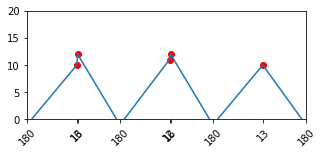

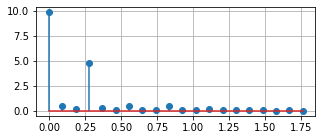

Index_948


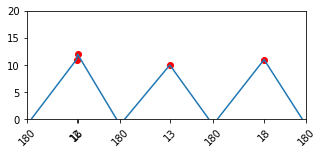

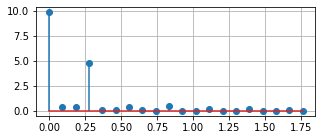

Index_950


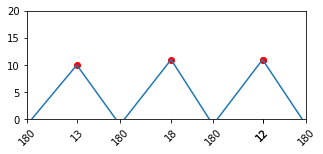

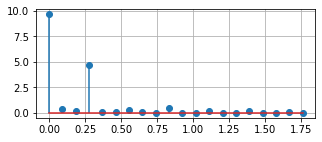

Index_952


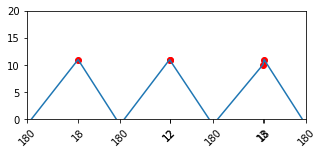

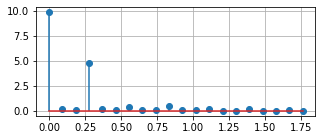

Index_954


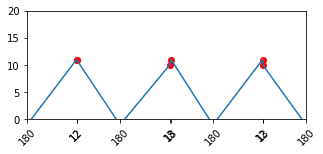

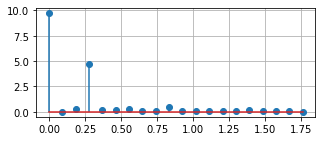

Index_956


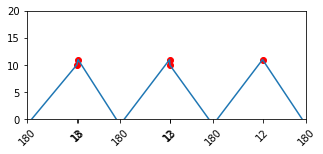

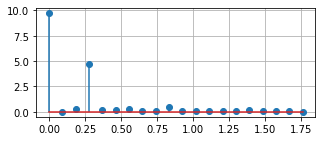

In [46]:
# 정상 / 이상 데이터에 대한 예시 그래프
machine_type = df["machineid"].unique()
step_type = df["stepid"].unique()
device_type = df["deviceid"].unique()

temp_df = df.copy()

case = 0
case_dict = dict()
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            if case in [9,10] :
                print("==="*30)
                print(f"Case{case}: {m,s,d}")
                case_dict["Case"+str(case)] = [m,s,d]
                    
                temp = df[(df.machineid == m) & (df.stepid == s) & (df.deviceid == d)].reset_index()
                if len(temp) == 0:
                    print("데이터 없음")
                    continue
                
                visualization_graph(temp, case, True)
                print("==="*30)

In [37]:
# fft후, amplitude 값 컬럼 추가
def add_amplitude(df):
    nRows = len(df) - cfg.n_window + 1
    for i in tqdm(range(nRows)):
        df_dist = df.distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
            
        df_deg = df.degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        
        intp, xnew = batch_graph(batch_deg, batch_dist, False)
        df.at[i+cfg.n_window-1,"amplitude"] = amp_data(intp(xnew)).astype('object')
    return df

In [38]:
# amplitude, case 컬럼 추가
machine_type = df["machineid"].unique()
step_type = df["stepid"].unique()
device_type = df["deviceid"].unique()

temp_df = pd.DataFrame()
case = 0
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            print(f"Case{case}: {m,s,d}")
            temp = df[(df.machineid == m) & (df.stepid == s) & (df.deviceid == d)].reset_index()
            if len(temp) == 0:
                print("데이터프레임 없음")
                continue
            
            temp = add_amplitude(temp)
            temp['case'] = case
            temp_df = pd.concat([temp_df, temp], axis=0)
temp_df = temp_df.sort_values(by='index').reset_index(drop=True)

Case1: ('A3D02', 'METROLOGY-TYPE-01', 'AC1')


100%|██████████| 85/85 [00:00<00:00, 1705.47it/s]


Case2: ('A3D02', 'METROLOGY-TYPE-01', 'AS1')


100%|██████████| 236/236 [00:00<00:00, 1858.40it/s]


Case3: ('A3D02', 'METROLOGY-TYPE-01', 'AS2')


100%|██████████| 23/23 [00:00<00:00, 1579.88it/s]


Case4: ('A3D02', 'METROLOGY-TYPE-01', 'AC2')


100%|██████████| 73/73 [00:00<00:00, 2091.25it/s]


Case5: ('A3D02', 'METROLOGY-TYPE-02', 'AC1')
데이터프레임 없음
Case6: ('A3D02', 'METROLOGY-TYPE-02', 'AS1')


100%|██████████| 73/73 [00:00<00:00, 1814.25it/s]


Case7: ('A3D02', 'METROLOGY-TYPE-02', 'AS2')
데이터프레임 없음
Case8: ('A3D02', 'METROLOGY-TYPE-02', 'AC2')
데이터프레임 없음
Case9: ('A3D01', 'METROLOGY-TYPE-01', 'AC1')


100%|██████████| 98/98 [00:00<00:00, 2189.18it/s]


Case10: ('A3D01', 'METROLOGY-TYPE-01', 'AS1')


100%|██████████| 292/292 [00:00<00:00, 1871.62it/s]


Case11: ('A3D01', 'METROLOGY-TYPE-01', 'AS2')
데이터프레임 없음
Case12: ('A3D01', 'METROLOGY-TYPE-01', 'AC2')


100%|██████████| 23/23 [00:00<00:00, 2332.37it/s]


Case13: ('A3D01', 'METROLOGY-TYPE-02', 'AC1')


100%|██████████| 48/48 [00:00<00:00, 1859.68it/s]


Case14: ('A3D01', 'METROLOGY-TYPE-02', 'AS1')


100%|██████████| 29/29 [00:00<00:00, 1819.57it/s]

Case15: ('A3D01', 'METROLOGY-TYPE-02', 'AS2')
데이터프레임 없음
Case16: ('A3D01', 'METROLOGY-TYPE-02', 'AC2')
데이터프레임 없음


In [39]:
data = temp_df[["amplitude", "case"]]

# null값 제거
data = data[data.amplitude.notnull()]
data

amplitude  case
4    [1.1365575147692653e-13, 1.6192659676815115, 0...    10
5    [1.146801705755631, 2.96404876893771, 2.465994...     1
6    [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    10
7    [4.665277777778155, 5.3708632752941865, 2.6225...     1
8    [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    10
..                                                 ...   ...
995  [4.626047904191197, 3.3859911884807077, 2.7075...     9
996  [8.302561669828556, 2.244704822194835, 0.72627...     9
997  [8.154513888887763, 2.1717257982185796, 1.5454...     9
998  [8.176097105508994, 4.171502919051563, 1.60114...     9
999  [7.763267973855518, 4.8720276357202, 2.8273775...     9

[980 rows x 2 columns]

In [40]:
# Class 라벨 추가
klarf_info = pd.read_csv("./klarf_scenario.txt", sep='\t')
klarf_info[klarf_info.Class != 0] = 1
temp_class = data.copy()
temp_class["class"] = klarf_info.Class
temp_class

amplitude  case  class
4    [1.1365575147692653e-13, 1.6192659676815115, 0...    10      0
5    [1.146801705755631, 2.96404876893771, 2.465994...     1      0
6    [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    10      0
7    [4.665277777778155, 5.3708632752941865, 2.6225...     1      0
8    [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    10      0
..                                                 ...   ...    ...
995  [4.626047904191197, 3.3859911884807077, 2.7075...     9      0
996  [8.302561669828556, 2.244704822194835, 0.72627...     9      0
997  [8.154513888887763, 2.1717257982185796, 1.5454...     9      0
998  [8.176097105508994, 4.171502919051563, 1.60114...     9      0
999  [7.763267973855518, 4.8720276357202, 2.8273775...     9      0

[980 rows x 3 columns]

In [43]:
def make_amplitude_df(df):
    arr = np.array(df.amplitude.iloc[0]).reshape(1,-1)
    cols = np.array([i for i in range(arr.shape[1])])
    idx = df.index
    for i in range(1,len(df)):
        arr = np.append(arr, df.amplitude.iloc[i].reshape(1,-1), axis=0)
        
    df = pd.DataFrame(arr, columns=cols, index=idx)
    return df
make_amplitude_df(temp_class)

0         1         2         3         4         5         6   \
4         0.0  1.619266  0.807481  0.197314  0.080493  0.058992  0.075456   
5    1.146802  2.964049  2.465994  1.790574   1.13485  0.724795  0.642353   
6         2.0       0.0       0.0       0.0       0.0       0.0       0.0   
7    4.665278  5.370863  2.622544  0.651904   0.41168  0.163603  0.158328   
8         2.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
995  4.626048  3.385991  2.707563  2.097916  0.521773  0.382991  0.858575   
996  8.302562  2.244705  0.726275  3.156077  0.678334  0.447021  1.203226   
997  8.154514  2.171726  1.545498  2.033282  1.452728  1.988546  1.357305   
998  8.176097  4.171503  1.601143  2.386357  1.499592  0.802269  1.115865   
999  7.763268  4.872028  2.827378  1.033151  0.588818  0.552214  0.219676   

           7         8         9         10        11        12        13  \
4    0.037879  0.037047  0.017829   0.01771  0.015055  0.021369  0.009182   
5     0.63276  0.546782   0.43558  0.388714  0.389892  0.368676  0.318733   
6         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
7     0.12981  0.171626  0.066428  0.007331  0.038082  0.067056  0.036145   
8         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.298287  0.188737  0.355108  0.215205  0.191675  0.184119  0.161724   
996   0.53705  0.496455  0.441641  0.292955  0.345931  0.315235    0.2425   
997  0.737181  0.273186  0.464242  0.696169  0.734668  0.566909  0.227702   
998  0.546227  0.218429  0.514973  0.406374  0.242814  0.464667  0.301295   
999  0.263335  0.261296  0.452327   0.43314  0.413778  0.344088  0.378207   

           14        15        16        17        18        19  
4    0.002776  0.007505  0.012868  0.005939  0.002375  0.004227  
5    0.281846  0.275687  0.269453  0.245077  0.219866  0.213095  
6         0.0       0.0       0.0       0.0       0.0       0.0  
7    0.040008  0.020854  0.021278  0.021244  0.032786  0.013963  
8         0.0       0.0       0.0       0.0       0.0       0.0  
..        ...       ...       ...       ...       ...       ...  
995  0.223369  0.099024   0.14715  0.177079  0.101042  0.103208  
996  0.232462  0.304978  0.232637   0.12203  0.239633  0.205435  
997  0.127268  0.397073  0.422123  0.437838  0.280759  0.128496  
998  0.123114  0.262318    0.2104   0.10801  0.242477  0.206391  
999  0.385542  0.375526  0.306423  0.252426  0.219497  0.199352  

[980 rows x 20 columns]

## FFT Amplitude 2차원/3차원 시각화

In [ ]:
temp_X = make_amplitude_df(temp_class)
temp_y = temp_class[["Class"]]
temp_case = temp_class[["Case"]]

In [ ]:
# 0~19까지의 컬럼에 대해 주성분분석 후, 2차원/3차원 상에 투상
from sklearn.manifold import TSNE
#temp_X = temp_X.iloc[:,1:6]
tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=cfg.seed)
tsne_X = tsne.fit_transform(temp_X)

tsne = TSNE(n_components=3, init='random', learning_rate='auto', random_state=cfg.seed)
tsne3_X = tsne.fit_transform(temp_X)

In [76]:
tsne_df = pd.DataFrame(tsne_X, index=temp_X.index, columns=['x','y'])
tsne_df = pd.concat([tsne_df, temp_y, temp_case], axis=1)

tsne3_df = pd.DataFrame(tsne3_X, index=temp_X.index, columns=['x','y','z'])
tsne3_df = pd.concat([tsne3_df, temp_y, temp_case], axis=1)

NameError: name 'tsne_X' is not defined

In [77]:
tsne3_df.head()

NameError: name 'tsne3_df' is not defined

In [105]:
tsne_df0 = tsne_df[tsne_df.Class == 0]
tsne_df1 = tsne_df[tsne_df.Class == 1]

tsne3_df0 = tsne3_df[tsne3_df.Class == 0]
tsne3_df1 = tsne3_df[tsne3_df.Class == 1]

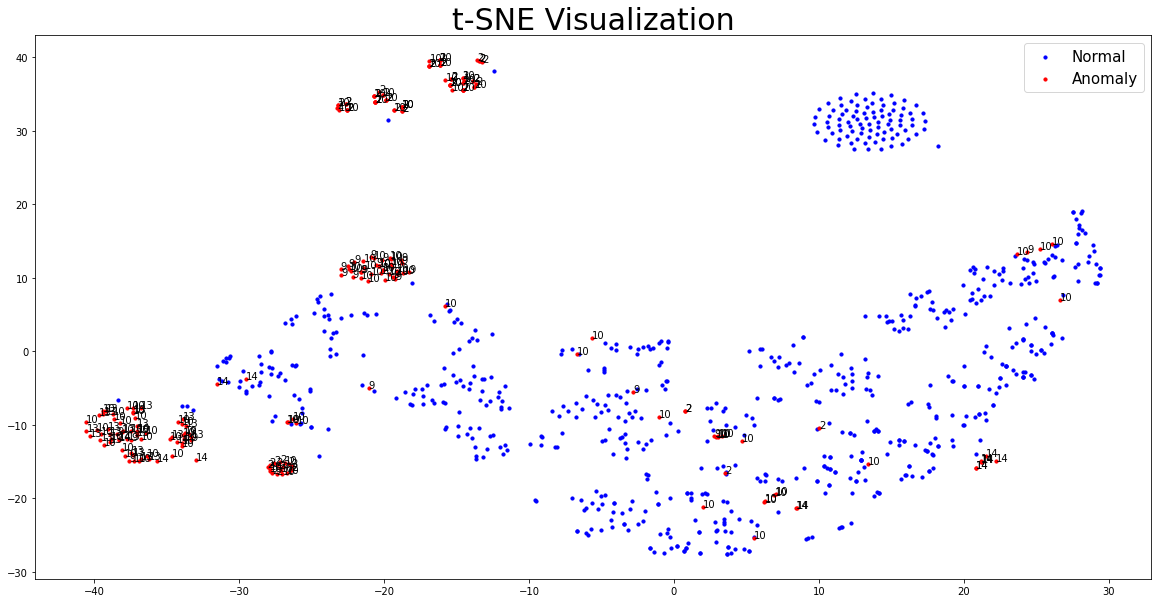

In [106]:
# 2차원 시각화
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(tsne_df0['x'], tsne_df0['y'], s=10, color='b', label='Normal')
ax.scatter(tsne_df1['x'], tsne_df1['y'], s=10, color='r', label='Anomaly')
for _, row in tsne_df1.iterrows():
    ax.text(row[0], row[1], int(row[3]))
plt.title("t-SNE Visualization", fontsize=30)
plt.legend(fontsize=15)
plt.show()

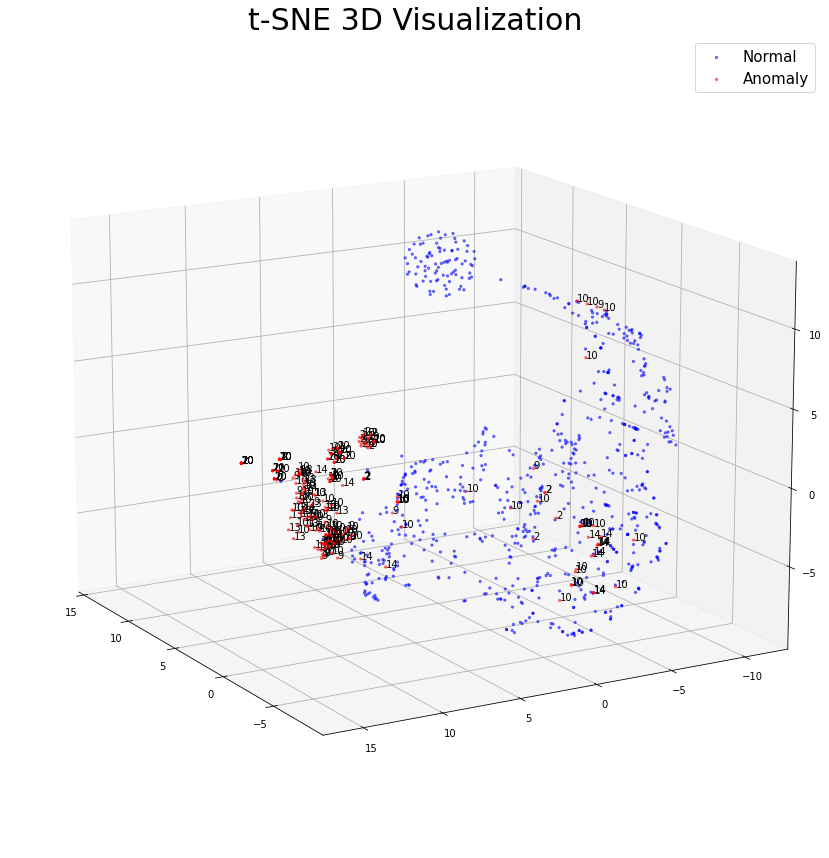

In [ ]:
# 3차원 시각화
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne3_df0['x'], tsne3_df0['y'], tsne3_df0['z'], s=5, color='b', alpha=0.5, label='Normal')
ax.scatter(tsne3_df1['x'], tsne3_df1['y'], tsne3_df1['z'], s=5, color='r', alpha=0.5, label='Anomaly')

for _, row in tsne3_df1.iterrows():
    ax.text(row[0], row[1], row[2], int(row[4]))
    
ax.view_init(elev=15., azim=150)
ax.legend(fontsize=15)
plt.title("t-SNE 3D Visualization", fontsize=30)
plt.show()

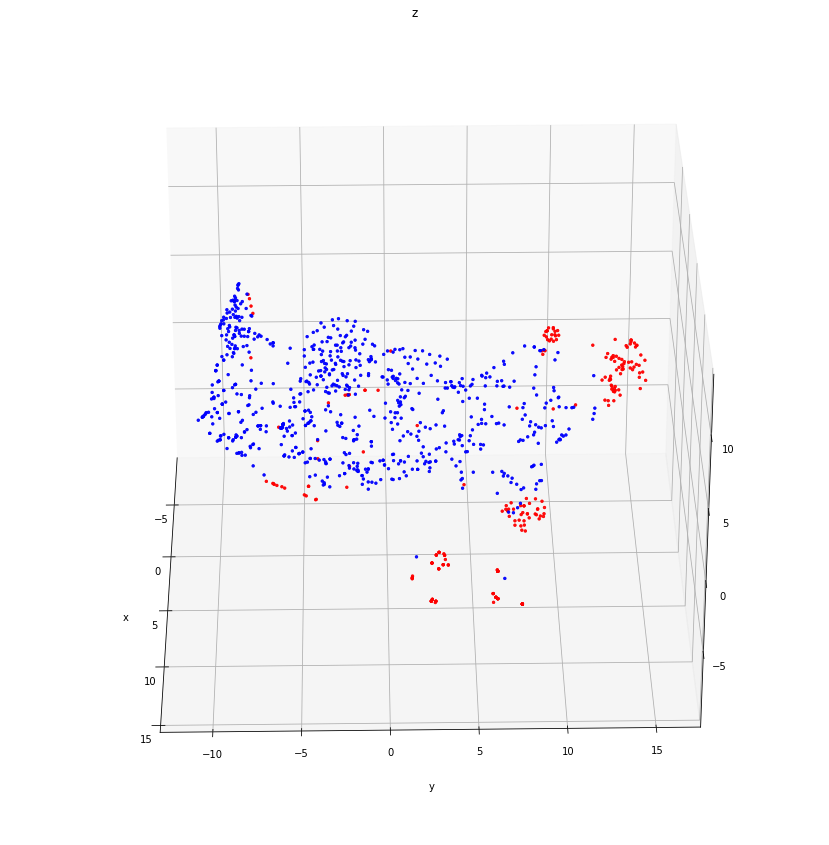

In [169]:
# 3차원 시각화 animation
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.set_xlabel("x", labelpad=16)
    ax.set_ylabel("y", labelpad=16)
    ax.set_title("z")
    
    ax.scatter(tsne3_df0["x"], tsne3_df0["y"], tsne3_df0["z"], color='b', s=5, alpha=0.5)
    ax.scatter(tsne3_df1["x"], tsne3_df1["y"], tsne3_df1["z"], color='r', s=5, alpha=0.5)
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
anim.save('3d_plot_7window.gif', fps=30)

## data

In [436]:
data_X = make_amplitude_df(temp_class).iloc[:,1:]
data_y = temp_class[["class"]]

train_clf_X, test_clf_X, train_clf_y ,test_clf_y = train_test_split(
    data_X, data_y, test_size=0.3, random_state=cfg.seed
)

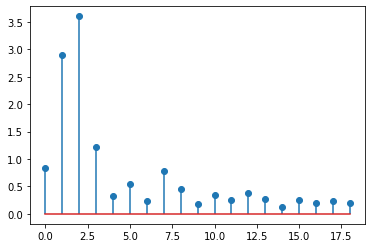

In [437]:
def fft_plot(arr):
    plt.stem(arr)
    plt.show()
    
fft_plot(train_clf_X.iloc[2,:])

## Normalization


In [439]:
from sklearn.preprocessing import Normalizer

norm = Normalizer(norm='max')
train_clf_X = pd.DataFrame(norm.fit_transform(train_clf_X), index=train_clf_X.index)
test_clf_X = norm.transform(test_clf_X)

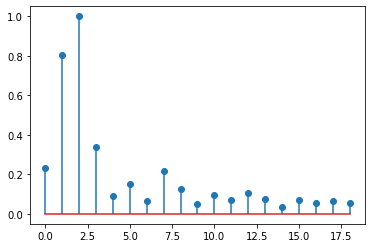

In [440]:
fft_plot(train_clf_X.iloc[2, :])
    

## Prototype Classification 
- RandomForest로 확인

In [441]:
# random forest
rf = RandomForestClassifier(random_state=cfg.seed)
rf.fit(train_clf_X, train_clf_y)
joblib.dump(rf, './model/basic_rf.pkl')

['./model/basic_rf.pkl']

In [442]:
def plot_heatmap(actual, predicted, title):
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(actual, predicted), annot=True, fmt='d', cbar=False, ax=ax)
    ax.set_xlabel("Predicted", fontsize=13)
    ax.set_ylabel("Actual", fontsize=13)
    ax.xaxis.set_ticklabels(["Normal", "Anomaly"])
    ax.yaxis.set_ticklabels(["Normal", "Anomaly"])
    ax.set_title(title, fontsize=15)
    plt.show()
    
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_comp(proba, actual):
    threshold_arr = np.linspace(0, 1, 20)
    acc_arr = []
    rec_arr = []
    pre_arr = []
    for th in threshold_arr:
        predicted = (proba[:,1] >= th).astype('int')
        acc_arr.append(accuracy_score(actual, predicted))
        rec_arr.append(recall_score(actual, predicted))
        pre_arr.append(precision_score(actual, predicted))

    plt.plot(threshold_arr, acc_arr, 'g', label='accuracy score')
    plt.plot(threshold_arr, rec_arr, 'r', label='recall score')
    plt.plot(threshold_arr, pre_arr, 'b', label='precision score')
    # plt.axhline(y=0.9, color='k', linestyle='--')
    # plt.axvline(x=0.25, color='k', linestyle='--')
    plt.title("Precision and Recall score comparision", fontsize=20)
    plt.xlabel("Threshold", fontsize=15)
    plt.xticks(np.arange(0,1.1,.1))
    plt.ylabel("Score", fontsize=15)
    plt.legend()
    plt.show()
    

accuracy_score: 0.949, recall score: 0.829, f1 score: 0.986
roc-auc score:  0.96


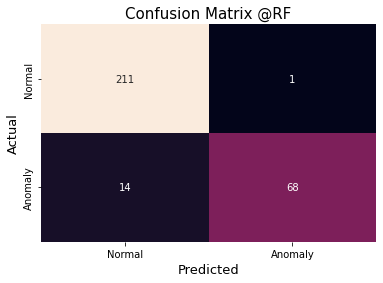

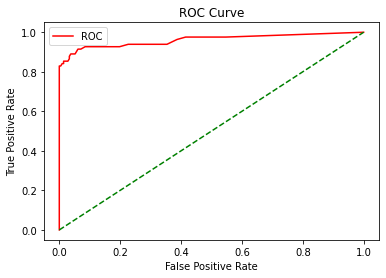

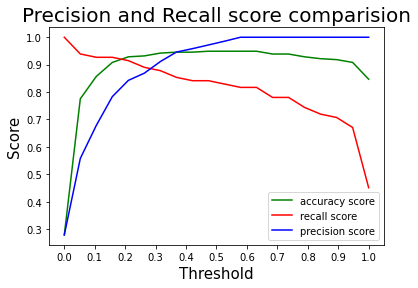

In [443]:
def plot_all(model, df_X, df_y, model_name):

    pred = model.predict(df_X)
    acc = accuracy_score(df_y, pred)
    rec = recall_score(df_y, pred)
    pre = precision_score(df_y, pred) 
    print("accuracy_score: {:.3f}, recall score: {:.3f}, f1 score: {:.3f}".format(acc, rec, pre))

    prob = model.predict_proba(df_X)[:,1]
    fper, tper, thresholds = roc_curve(df_y, prob)
    print('roc-auc score: ', round(roc_auc_score(df_y,prob),2))

    predicted_proba = model.predict_proba(df_X)

    plot_heatmap(df_y, pred, f"Confusion Matrix @{model_name}")
    plot_roc_curve(fper, tper)
    plot_comp(predicted_proba, df_y)
    
plot_all(rf, test_clf_X, test_clf_y, "RF")

## 모델링


### SVC

accuracy_score: 0.915, recall score: 0.768, f1 score: 0.913
roc-auc score:  0.89


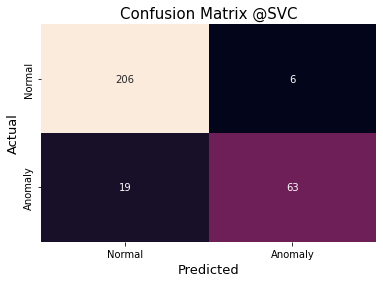

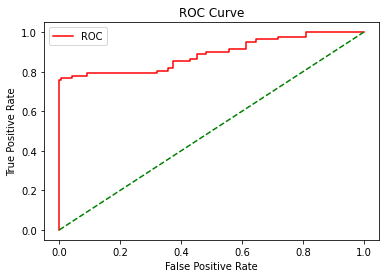

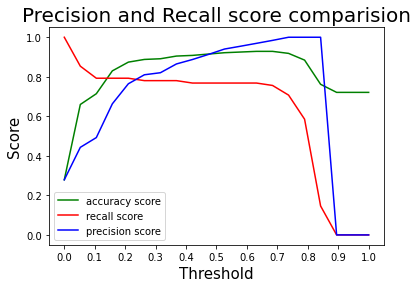

In [444]:
# svc
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=cfg.seed, probability=True)
model.fit(train_clf_X, train_clf_y)
saved_model = joblib.dump(model, './model/basic_svc.pkl')
plot_all(model, test_clf_X,  test_clf_y, "SVC")

accuracy_score: 0.908, recall score: 0.768, f1 score: 0.887
roc-auc score:  0.88


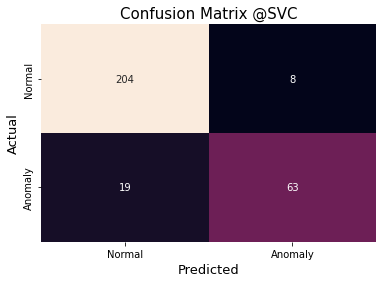

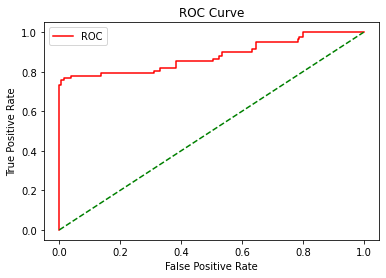

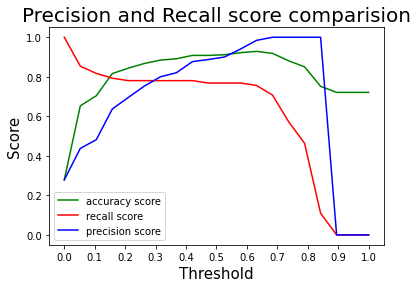

In [445]:
# SVC
from sklearn.svm import SVC
model = SVC(C=0.3, kernel='linear', random_state=cfg.seed, probability=True)
model.fit(train_clf_X, train_clf_y)
saved_model = joblib.dump(model, './model/tuned_svc.pkl')
plot_all(model, test_clf_X,  test_clf_y, "SVC")

### Logistic Regression

In [447]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=cfg.seed)
model.fit(train_clf_X, train_clf_y)
saved_model = joblib.dump(model, './model/basic_lr.pkl')

accuracy_score: 0.915, recall score: 0.768, f1 score: 0.913
roc-auc score:  0.88


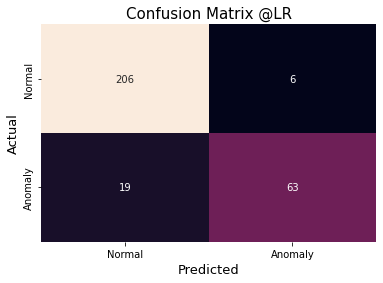

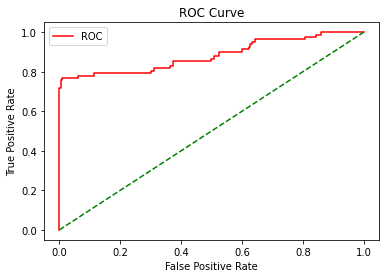

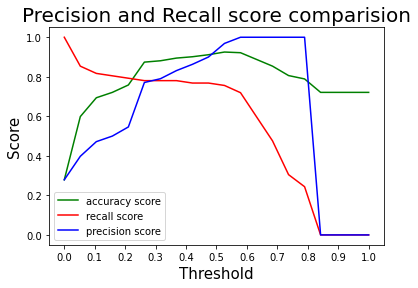

In [448]:
plot_all(model, test_clf_X,  test_clf_y, "LR")

## 예측값으로부터 이상원인 파악

In [170]:
temp = pd.DataFrame(pred, index=test_clf_X.index)
idx = temp[temp[0] == 1].index
anomaly_df = temp_df.iloc[idx,:].drop(columns=["index","MAP","Distance","Degree","Amplitude"]).sort_values("Timestamp")
anomaly_df

LotID     WaferID           Timestamp MachineID             StepID  \
30   AS10003SA  AS10003-04 2023-01-01 10:35:34     A3D02  Metrology-Type-01   
47   AS10003SA  AS10003-12 2023-01-01 14:07:57     A3D02  Metrology-Type-01   
50   AS10003SA  AS10003-13 2023-01-01 14:40:04     A3D02  Metrology-Type-01   
52   AS10003SA  AS10003-14 2023-01-01 15:09:43     A3D02  Metrology-Type-01   
126  AS10003SC  AS10003-23 2023-01-02 06:17:36     A3D01  Metrology-Type-01   
..         ...         ...                 ...       ...                ...   
964  AC10358SP  AC10358-04 2023-01-09 13:21:42     A3D01  Metrology-Type-01   
969  AC10358SP  AC10358-07 2023-01-09 14:17:46     A3D01  Metrology-Type-01   
970  AC10358SP  AC10358-08 2023-01-09 14:41:09     A3D01  Metrology-Type-01   
980  AC10358SP  AC10358-13 2023-01-09 16:49:50     A3D01  Metrology-Type-01   
982  AC10358SP  AC10358-14 2023-01-09 17:22:09     A3D01  Metrology-Type-01   

    DeviceID  Case  
30       AS1     2  
47       AS1     2  
50       AS1     2  
52       AS1     2  
126      AS1    10  
..       ...   ...  
964      AC1     9  
969      AC1     9  
970      AC1     9  
980      AC1     9  
982      AC1     9  

[68 rows x 7 columns]

In [190]:
anomaly_df["YMD"] = anomaly_df.Timestamp.apply(lambda x: datetime.strftime(x, "%Y-%m-%d"))
anomaly_df.YMD.unique()
for ymd in anomaly_df.YMD.unique():
    temp = anomaly_df[anomaly_df.YMD == ymd]
    print(f'============= {ymd} =============')
    print(f'검사장비 {temp.MachineID.unique()}')
    print(f'검사방법 {temp.StepID.unique()}')
    print(f'제품공정 {temp.DeviceID.unique()}')
    print("에 대한 확인이 필요합니다.\n")

============= 2023-01-01 =============
검사장비 ['A3D02']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-02 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-03 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01' 'Metrology-Type-02']
제품공정 ['AS1' 'AC1']
에 대한 확인이 필요합니다.

============= 2023-01-04 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-02']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-05 =============
검사장비 ['A3D01' 'A3D02']
검사방법 ['Metrology-Type-02' 'Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-06 =============
검사장비 ['A3D02']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-07 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-09 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1' 'AC1']
에 대한 확인이 필요합니다.



## 푸리에 변환의 이해를 위한 예시 시각화

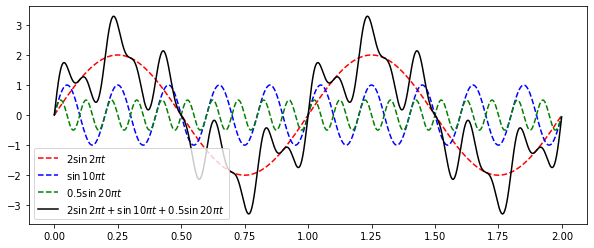

In [21]:
# 푸리에 적분 예시
fig = plt.figure(figsize=(10,4))
x = np.arange(0,2, 0.001)
y1 = 2*np.sin(2*np.pi*x)
y2 = np.sin(2*np.pi*5*x)
y3 = 0.5*np.sin(2*np.pi*10*x)
ySum = y1+y2+y3
plt.plot(x, y1, color='r', linestyle='--', label=r"${2}\sin {2\pi} t$")
plt.plot(x, y2, color='b', linestyle='--', label=r"$\sin {10\pi} t$")
plt.plot(x, y3, color='g', linestyle='--', label=r"${0.5}\sin {20\pi} t$")
plt.plot(x,ySum, color='k', label=r"${2}\sin{2\pi}t + \sin{10\pi}t + {0.5}\sin{20\pi}t$")
plt.legend()
plt.show()

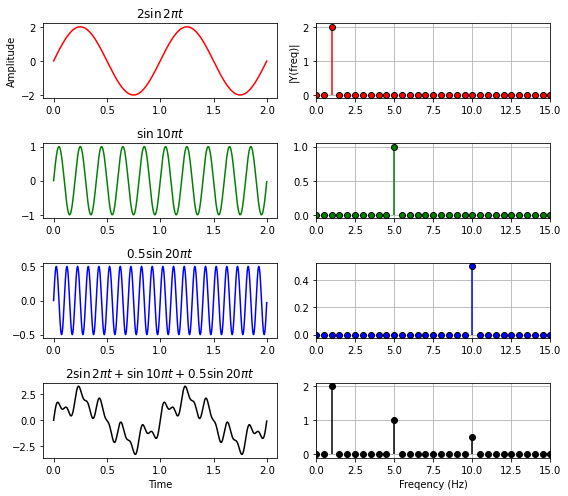

In [22]:
def fft_func(y):
    n = len(y)
    k = np.arange(n)
    Fs = 1/0.001
    T = n/Fs
    freq = k/T 
    freq = freq[range(int(n/2))]
    Y = 2* np.fft.fft(y)/n 
    amp = Y[range(int(n/2))]
    return freq, abs(amp)

def plot_fft(row, col, y, color):
    markers, stemlines, baseline = ax[row][col].stem(fft_func(y)[0], fft_func(y)[1])
    markers.set_color(color)
    markers.set_markeredgecolor('k')
    markers.set_marker('o')
    stemlines.set_color(color)
    baseline.set_visible(False)
    ax[row][col].set_xlim([0, 15])
    ax[row][col].grid()

fig, ax = plt.subplots(4, 2, figsize=(8,7))

ax[0][0].plot(x, y1, 'r')
ax[1][0].plot(x, y2, 'g')
ax[2][0].plot(x, y3, 'b')
ax[3][0].plot(x, ySum, 'k')
plot_fft(0,1,y1, 'r')
plot_fft(1,1,y2, 'g')
plot_fft(2,1,y3, 'b')
plot_fft(3,1,ySum, 'k')
ax[3][0].set_xlabel('Time')
ax[0][0].set_ylabel('Amplitude')
ax[0][1].set_ylabel('|Y(freq)|')
ax[3][1].set_xlabel('Freqency (Hz)')

ax[0][0].set_title(r"${2}\sin {2\pi} t$")
ax[1][0].set_title(r"$\sin {10\pi} t$")
ax[2][0].set_title(r"${0.5}\sin {20\pi} t$")
ax[3][0].set_title(r"${2}\sin{2\pi}t + \sin{10\pi}t + {0.5}\sin{20\pi}t$")

plt.tight_layout()
plt.show()

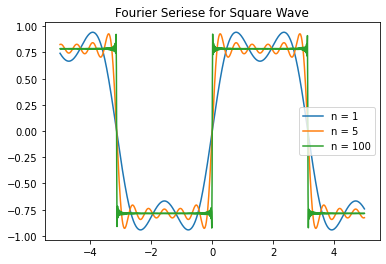

In [23]:
# 주기를 가진 사각파의 삼각함수 근사
def F(n, X):
    """
                   1
        F (t) = ------- sin ( (2n+1) t ) 
         n      2n + 1
    """
    return np.sin((2*n+1)*X)/(2*n+1)


def squarewave(n, X):
    """
          n
        Sigma  F (t)
         k=1
    """
    y = np.zeros(X.shape)
    for k in range(n+1):
        y = F(k, X) + y
    return y


X = np.linspace(-5, 5, 1000)
for i in (1, 5, 100):
    plt.plot(X, squarewave(i, X), label = f'n = {i}')
    
plt.title("Fourier Seriese for Square Wave")
plt.legend()
plt.show()

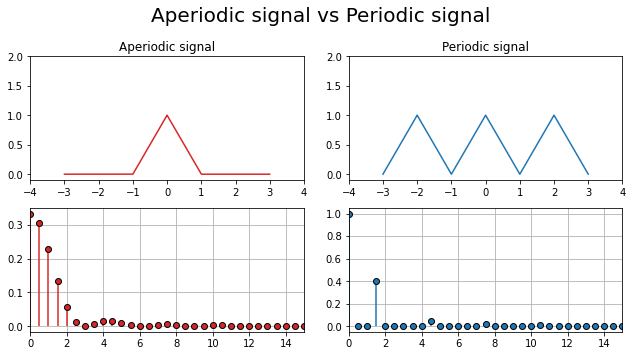

In [56]:
x = np.arange(-3, 3, 0.001)
y = np.array([])
y1 = np.array([])
for i in x:
    if 0 < i <= 1:
        y = np.append(y, -i+1)
        y1 = np.append(y1, -i+1)
    elif -1 < i <= 0:
        y = np.append(y, i+1)
        y1 = np.append(y1, i+1)
    elif -2 < i <= -1:
        y = np.append(y, 0)
        y1 = np.append(y1, -i-1)
    elif -3 < i <= -2:
        y = np.append(y, 0)
        y1 = np.append(y1, i+3)
    elif 1 < i <= 2:
        y = np.append(y, 0)
        y1 = np.append(y1, i-1)
    elif 2 < i <= 3:
        y = np.append(y, 0)
        y1 = np.append(y1, -i+3)
    else:
        y = np.append(y, 0)
        y1 = np.append(y1, 0)

def fft_func(y, sampling_rate=1000):
    n = len(y)
    k = np.arange(n)
    Fs = sampling_rate
    T = n/Fs
    freq = k/T 
    freq = freq[range(int(n/2))]
    Y = 2* np.fft.fft(y)/n 
    amp = Y[range(int(n/2))]
    return freq, abs(amp)

def plot_fft(row, col, y, color, sampling_rate=1000):
    markers, stemlines, baseline = ax[row][col].stem(fft_func(y, sampling_rate)[0], fft_func(y, sampling_rate)[1])
    markers.set_color(color)
    markers.set_markeredgecolor('k')
    markers.set_marker('o')
    stemlines.set_color(color)
    baseline.set_visible(False)
    ax[row][col].set_xlim([0, 15])
    ax[row][col].grid()

fig, ax = plt.subplots(2, 2, figsize=(9,5))
ax[0][0].plot(x,y, color='tab:red')
ax[0][0].set_xlim(-4,4)
ax[0][0].set_ylim(-0.1, 2)

ax[0][1].plot(x,y1)
ax[0][1].set_xlim(-4,4)
ax[0][1].set_ylim(-0.1, 2)
plot_fft(1,0, y, 'tab:red', 3000)
plot_fft(1,1, y1, 'tab:blue', 3000)
fig.suptitle("Aperiodic signal vs Periodic signal", fontsize=20)
ax[0][0].set_title("Aperiodic signal")
ax[0][1].set_title("Periodic signal")

plt.tight_layout()
plt.show()

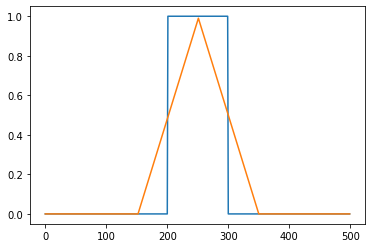

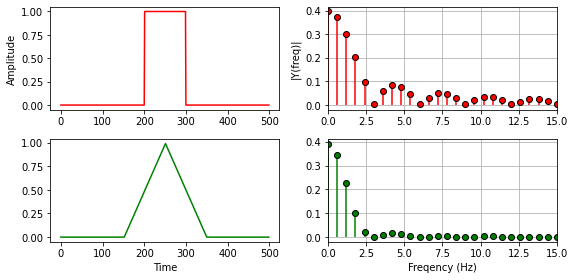

In [60]:
sample_rate = 100
num_samples = 500
wave = np.fromfunction(lambda i: (2*sample_rate < i) & (i < 3*sample_rate), (num_samples,)).astype('float')
wave1 = np.convolve(wave, wave, mode='same')/sample_rate
plt.plot(np.stack((wave, wave1), axis=1))
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(8,4))
ax[0][0].plot(wave, 'r')
ax[1][0].plot(wave1, 'g')
plot_fft(0,1,wave, 'r', 300)
plot_fft(1,1,wave1, 'g', 300)
ax[1][0].set_xlabel('Time')
ax[0][0].set_ylabel('Amplitude')
ax[0][1].set_ylabel('|Y(freq)|')
ax[1][1].set_xlabel('Freqency (Hz)')

plt.tight_layout()
plt.show()

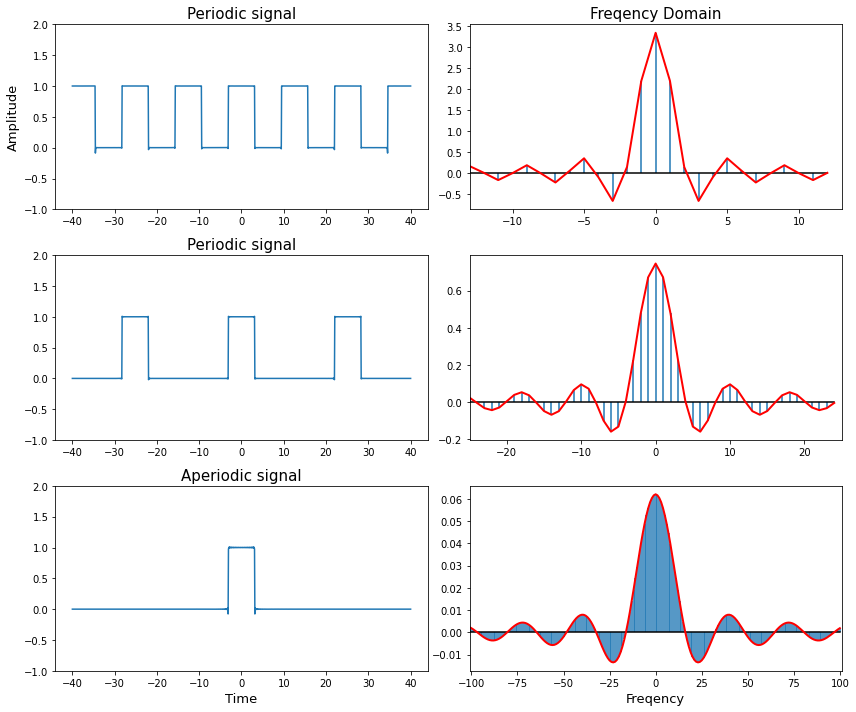

In [118]:
from scipy.signal import hilbert # envelope을 위한 패키지

# 사각파
def square_wave(t, timeDomain):
    T = t*np.pi
    f = 0
    num = 2000
    for n in range(-num, num):
        if n == 0:
            continue
        w = (n*2*np.pi)/T
        cn = np.sin((2*np.pi*n*np.pi)/T) /  (n*np.pi)
        f += cn*np.exp(1j*w*timeDomain)
    err = -np.mean(f[f < 0])
    f += err
    return f

# Fourier 변환
def fourier(t, timeDomain, f):
    T = t*np.pi
    cn = 0
    Fc = []
    Rs = round(T)
    nvec = np.arange(-Rs, Rs)
    for n in nvec:
        for i in range(len(timeDomain)-1):
            dt = timeDomain[i+1] - timeDomain[i]
            w = (2*np.pi*n)/T
            cn += f[i]*np.exp(-1j*w*timeDomain[i]) * dt
        Fc.append((1/T)*cn)
        cn = 0
    return nvec, Fc

tRange = 40
sampling_rate = 1000
timeDomain = np.linspace(-tRange, tRange, sampling_rate)

fig, ax = plt.subplots(3,2,figsize=(12, 10))

for i, t in enumerate([4, 8, 32]):
    # 사각파 plot
    f = square_wave(t, timeDomain)
    ax[i][0].plot(timeDomain, np.real(f))
    ax[i][0].set_ylim(-1, 2)
    
    # Fourier transform plot
    nvec, Fc = fourier(t, timeDomain, f)
    y = hilbert(np.real(Fc)).real
    
    markers, stemlines, baseline = ax[i][1].stem(nvec, np.real(Fc))
    markers.set_visible(False)
    baseline.set_color('k')
    ax[i][1].set_xlim(-np.fix(len(nvec)/2), np.fix(len(nvec)/2))
    ax[i][1].plot(nvec, y, linewidth=2, color='r')

ax[0][0].set_title("Periodic signal", fontsize=15)
ax[1][0].set_title("Periodic signal", fontsize=15)
ax[2][0].set_title("Aperiodic signal", fontsize=15)
ax[0][1].set_title("Freqency Domain", fontsize=15)
ax[0][0].set_ylabel("Amplitude", fontsize=13)
ax[2][0].set_xlabel("Time", fontsize=13)
ax[2][1].set_xlabel("Freqency", fontsize=13)

plt.tight_layout()
plt.show()